In [1]:
%%capture
##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes

!yes | pip3 uninstall pandas
!yes | pip3 uninstall geopandas

!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet;
!pip3 install pandas
!pip3 install geopandas
!pip3 install matplotlib
!pip3 install osmapi
!pip3 install geopy
!pip3 install plotly
!pip3 install folium

In [2]:
import osmnx as ox
from ipyleaflet import *
import networkx as nx
import plotly.graph_objects as obj
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import random
import pandas as pd
import osmapi as osm
import time
from collections import deque
from tqdm import tqdm
from itertools import islice
from utilities import *
import requests
from pathlib import Path
import json
import csv
import osmapi as osm
from typing import Dict, List, Any

# Get live traffic incidents

In [3]:
from bing_traffic.models.bounding_box import BoundingBox
from bing_traffic.models.traffic_incident import TrafficIncident

bing_traffic_config = json.loads(Path("./bing_traffic/config.json").read_text())
north_york_region = bing_traffic_config['regions'][1]
north_york_bounding_box = BoundingBox(north_york_region['south_latitude'], north_york_region['west_longitude'], north_york_region['north_latitude'], north_york_region['east_longitude'])

base_url = 'http://dev.virtualearth.net/REST/v1/Traffic/Incidents'
key = 'Anis5hbe2SmsonKyg6x65ccbQyiBorY9TNtjrG-6-ru9H7u4IdOHq-yX-Oo5PXmW'
response = requests.get(f'{base_url}/{north_york_bounding_box}?key={key}')
json_response = json.loads(response.text)['resourceSets'][0]['resources']
traffic_incidents = [TrafficIncident(traffic_incident) for traffic_incident in json_response]

for traffic_incident in traffic_incidents:
    print(traffic_incident)

King St WB, 
                    Construction on KING ST near PINE ST, Expect delays.,
                    Severity: 4, 
                    Road closed: True, 
                    Start timestamp (utc): 2020-11-29 20:00:00, 
                    End timestamp (utc): 2020-11-30 07:45:00, 
                    Origin coordinate: Lat = 43.705962, Lon = -79.515637, 
                    Destination coordinate: Lat = 43.707166, Lon = -79.510584
Queens Dr EB, 
                    Construction on QUEENS DR near ELM ST, Road closed. Take alternate route.,
                    Severity: 4, 
                    Road closed: True, 
                    Start timestamp (utc): 2020-11-29 20:00:00, 
                    End timestamp (utc): 2020-11-30 07:45:00, 
                    Origin coordinate: Lat = 43.705132, Lon = -79.515259, 
                    Destination coordinate: Lat = 43.703213, Lon = -79.517297
Ralph St NB, 
                    Construction on RALPH ST near ROSEMOUNT AVE, Road closed. T

# Helper Map class

In [4]:
import osmnx as ox
import osmapi as osm
from pathlib import Path
import csv
from geopandas import GeoDataFrame
from networkx.classes.multidigraph import MultiDiGraph
import pandas as pd
from typing import Dict, List

from models.edge import Edge
from models.coordinate import Coordinate


class Map:
    def __init__(self, place: str, cached_edges_coords_csv_path: Path) -> None:
        self.__place = place

        print('Loading cached edges coordinates...')
        self.__cached_edges_coords_map = self.__get_cached_edges_coords_map(cached_edges_coords_csv_path)

        print(f'Loading map ({place})...')
        self.__graph = ox.graph_from_place(place)
        ox_nodes_and_edges = ox.graph_to_gdfs(self.__graph)

        self.__ox_nodes = ox_nodes_and_edges[0]
        self.__ox_edges = ox_nodes_and_edges[1]
        self.__edges = None
        print('Map loaded.')

    def __get_cached_edges_coords_map(self, cached_edges_coords_csv_path: Path) -> Dict[int, Coordinate]:
        self.__validate_path_exists(cached_edges_coords_csv_path)
        cached_edges_coords_map = {}
        with open(cached_edges_coords_csv_path) as file:
            reader = csv.reader(file)
            rows = list(reader)
            for row in rows[1:]:
                osmid = int(row[0])
                lat = float(row[1])
                lon = float(row[2])
                cached_edges_coords_map[osmid] = Coordinate([lat, lon])
        
        return cached_edges_coords_map
    
    def __validate_path_exists(self, path: Path) -> Path:
        if (not path.exists()):        
            raise Exception(f'{path} does not exist')
    
    @property
    def graph(self) -> MultiDiGraph:
        return self.__graph
    
    @property
    def ox_nodes(self) -> GeoDataFrame:
        return self.__ox_nodes
    
    @property
    def ox_edges(self) -> GeoDataFrame:
        return self.__ox_edges
    
    @property
    def edges(self) -> List[Edge]:
        print('Getting edges...')
        return self.__edges if self.__edges is not None else self.__get_edges()
    
    def __get_edges(self) -> List[Edge]:
        print('Lazy loading edges...')
        edges = []
        ox_edges_dictionary = pd.DataFrame(self.ox_edges).to_dict()
        edges_count = len(ox_edges_dictionary['osmid'])
        for i in range(edges_count):
            print(f'({i}/{edges_count}) edges loaded')
            osmid = ox_edges_dictionary['osmid'][i]
            edge_type = ox_edges_dictionary['highway'][i]
            is_one_way = ox_edges_dictionary['oneway'][i] 
            max_speed = ox_edges_dictionary['maxspeed'][i]
            start_osmid = ox_edges_dictionary['u'][i]
            start_coordinate = self.__get_node_coordinates(start_osmid)
            end_osmid = ox_edges_dictionary['v'][i]
            end_coordinate = self.__get_node_coordinates(end_osmid)

            edges.append(Edge(osmid, edge_type, is_one_way, max_speed, start_osmid, end_osmid, start_coordinate, end_coordinate))
    
        self.__edges = edges
        
        return self.__edges
            
    def __get_node_coordinates(self, osmid: int) -> Coordinate:
        return self.__cached_edges_coords_map[osmid] if osmid in self.__cached_edges_coords_map else self.__get_node_from_osmapi(osmid)

    def __get_node_from_osmapi(self, osmid: int) -> Coordinate:
        api = osm.OsmApi()
        node = api.NodeGet(osmid)

        return Coordinate([node['lat'], node['lon']])


# Start of Graph Formulation

In [5]:
place = 'North York, Ontario, Canada'
cached_edges_coords_csv_path = Path('./map/data/north_york_edges_coords.csv')
north_york_map = Map(place, cached_edges_coords_csv_path)

G = north_york_map.graph
nodes = north_york_map.ox_nodes
edges = north_york_map.ox_edges

Loading cached edges coordinates...
Loading map (North York, Ontario, Canada)...
Map loaded.


# Init ny_nodes

In [6]:
ny_ox_nodes = north_york_map.ox_nodes
ny_nodes_dict = pd.DataFrame(ny_ox_nodes).to_dict()
ny_nodes_osmids = [osmid for osmid in ny_nodes_dict['osmid'].keys()]
ny_nodes = {}
for osmid in ny_nodes_osmids:
    ny_nodes[osmid] = {
        'osmid': osmid,
        'lat': ny_nodes_dict['y'][osmid],
        'lon': ny_nodes_dict['x'][osmid],
        'nearby_traffic_incidents': [],
        'nearby_traffic_clusters': [],
        'risk_score': 0
    }

# for ny_node in ny_nodes.values():
#     print(ny_node)

# Init ny_edges

In [7]:
# This will print the status as it takes a while to finish
ny_edges = north_york_map.edges

Getting edges...
Lazy loading edges...
(0/101172) edges loaded
(1/101172) edges loaded
(2/101172) edges loaded
(3/101172) edges loaded
(4/101172) edges loaded
(5/101172) edges loaded
(6/101172) edges loaded
(7/101172) edges loaded
(8/101172) edges loaded
(9/101172) edges loaded
(10/101172) edges loaded
(11/101172) edges loaded
(12/101172) edges loaded
(13/101172) edges loaded
(14/101172) edges loaded
(15/101172) edges loaded
(16/101172) edges loaded
(17/101172) edges loaded
(18/101172) edges loaded
(19/101172) edges loaded
(20/101172) edges loaded
(21/101172) edges loaded
(22/101172) edges loaded
(23/101172) edges loaded
(24/101172) edges loaded
(25/101172) edges loaded
(26/101172) edges loaded
(27/101172) edges loaded
(28/101172) edges loaded
(29/101172) edges loaded
(30/101172) edges loaded
(31/101172) edges loaded
(32/101172) edges loaded
(33/101172) edges loaded
(34/101172) edges loaded
(35/101172) edges loaded
(36/101172) edges loaded
(37/101172) edges loaded
(38/101172) edges loa

(341/101172) edges loaded
(342/101172) edges loaded
(343/101172) edges loaded
(344/101172) edges loaded
(345/101172) edges loaded
(346/101172) edges loaded
(347/101172) edges loaded
(348/101172) edges loaded
(349/101172) edges loaded
(350/101172) edges loaded
(351/101172) edges loaded
(352/101172) edges loaded
(353/101172) edges loaded
(354/101172) edges loaded
(355/101172) edges loaded
(356/101172) edges loaded
(357/101172) edges loaded
(358/101172) edges loaded
(359/101172) edges loaded
(360/101172) edges loaded
(361/101172) edges loaded
(362/101172) edges loaded
(363/101172) edges loaded
(364/101172) edges loaded
(365/101172) edges loaded
(366/101172) edges loaded
(367/101172) edges loaded
(368/101172) edges loaded
(369/101172) edges loaded
(370/101172) edges loaded
(371/101172) edges loaded
(372/101172) edges loaded
(373/101172) edges loaded
(374/101172) edges loaded
(375/101172) edges loaded
(376/101172) edges loaded
(377/101172) edges loaded
(378/101172) edges loaded
(379/101172)

(1087/101172) edges loaded
(1088/101172) edges loaded
(1089/101172) edges loaded
(1090/101172) edges loaded
(1091/101172) edges loaded
(1092/101172) edges loaded
(1093/101172) edges loaded
(1094/101172) edges loaded
(1095/101172) edges loaded
(1096/101172) edges loaded
(1097/101172) edges loaded
(1098/101172) edges loaded
(1099/101172) edges loaded
(1100/101172) edges loaded
(1101/101172) edges loaded
(1102/101172) edges loaded
(1103/101172) edges loaded
(1104/101172) edges loaded
(1105/101172) edges loaded
(1106/101172) edges loaded
(1107/101172) edges loaded
(1108/101172) edges loaded
(1109/101172) edges loaded
(1110/101172) edges loaded
(1111/101172) edges loaded
(1112/101172) edges loaded
(1113/101172) edges loaded
(1114/101172) edges loaded
(1115/101172) edges loaded
(1116/101172) edges loaded
(1117/101172) edges loaded
(1118/101172) edges loaded
(1119/101172) edges loaded
(1120/101172) edges loaded
(1121/101172) edges loaded
(1122/101172) edges loaded
(1123/101172) edges loaded
(

(1645/101172) edges loaded
(1646/101172) edges loaded
(1647/101172) edges loaded
(1648/101172) edges loaded
(1649/101172) edges loaded
(1650/101172) edges loaded
(1651/101172) edges loaded
(1652/101172) edges loaded
(1653/101172) edges loaded
(1654/101172) edges loaded
(1655/101172) edges loaded
(1656/101172) edges loaded
(1657/101172) edges loaded
(1658/101172) edges loaded
(1659/101172) edges loaded
(1660/101172) edges loaded
(1661/101172) edges loaded
(1662/101172) edges loaded
(1663/101172) edges loaded
(1664/101172) edges loaded
(1665/101172) edges loaded
(1666/101172) edges loaded
(1667/101172) edges loaded
(1668/101172) edges loaded
(1669/101172) edges loaded
(1670/101172) edges loaded
(1671/101172) edges loaded
(1672/101172) edges loaded
(1673/101172) edges loaded
(1674/101172) edges loaded
(1675/101172) edges loaded
(1676/101172) edges loaded
(1677/101172) edges loaded
(1678/101172) edges loaded
(1679/101172) edges loaded
(1680/101172) edges loaded
(1681/101172) edges loaded
(

(2038/101172) edges loaded
(2039/101172) edges loaded
(2040/101172) edges loaded
(2041/101172) edges loaded
(2042/101172) edges loaded
(2043/101172) edges loaded
(2044/101172) edges loaded
(2045/101172) edges loaded
(2046/101172) edges loaded
(2047/101172) edges loaded
(2048/101172) edges loaded
(2049/101172) edges loaded
(2050/101172) edges loaded
(2051/101172) edges loaded
(2052/101172) edges loaded
(2053/101172) edges loaded
(2054/101172) edges loaded
(2055/101172) edges loaded
(2056/101172) edges loaded
(2057/101172) edges loaded
(2058/101172) edges loaded
(2059/101172) edges loaded
(2060/101172) edges loaded
(2061/101172) edges loaded
(2062/101172) edges loaded
(2063/101172) edges loaded
(2064/101172) edges loaded
(2065/101172) edges loaded
(2066/101172) edges loaded
(2067/101172) edges loaded
(2068/101172) edges loaded
(2069/101172) edges loaded
(2070/101172) edges loaded
(2071/101172) edges loaded
(2072/101172) edges loaded
(2073/101172) edges loaded
(2074/101172) edges loaded
(

(2441/101172) edges loaded
(2442/101172) edges loaded
(2443/101172) edges loaded
(2444/101172) edges loaded
(2445/101172) edges loaded
(2446/101172) edges loaded
(2447/101172) edges loaded
(2448/101172) edges loaded
(2449/101172) edges loaded
(2450/101172) edges loaded
(2451/101172) edges loaded
(2452/101172) edges loaded
(2453/101172) edges loaded
(2454/101172) edges loaded
(2455/101172) edges loaded
(2456/101172) edges loaded
(2457/101172) edges loaded
(2458/101172) edges loaded
(2459/101172) edges loaded
(2460/101172) edges loaded
(2461/101172) edges loaded
(2462/101172) edges loaded
(2463/101172) edges loaded
(2464/101172) edges loaded
(2465/101172) edges loaded
(2466/101172) edges loaded
(2467/101172) edges loaded
(2468/101172) edges loaded
(2469/101172) edges loaded
(2470/101172) edges loaded
(2471/101172) edges loaded
(2472/101172) edges loaded
(2473/101172) edges loaded
(2474/101172) edges loaded
(2475/101172) edges loaded
(2476/101172) edges loaded
(2477/101172) edges loaded
(

(2801/101172) edges loaded
(2802/101172) edges loaded
(2803/101172) edges loaded
(2804/101172) edges loaded
(2805/101172) edges loaded
(2806/101172) edges loaded
(2807/101172) edges loaded
(2808/101172) edges loaded
(2809/101172) edges loaded
(2810/101172) edges loaded
(2811/101172) edges loaded
(2812/101172) edges loaded
(2813/101172) edges loaded
(2814/101172) edges loaded
(2815/101172) edges loaded
(2816/101172) edges loaded
(2817/101172) edges loaded
(2818/101172) edges loaded
(2819/101172) edges loaded
(2820/101172) edges loaded
(2821/101172) edges loaded
(2822/101172) edges loaded
(2823/101172) edges loaded
(2824/101172) edges loaded
(2825/101172) edges loaded
(2826/101172) edges loaded
(2827/101172) edges loaded
(2828/101172) edges loaded
(2829/101172) edges loaded
(2830/101172) edges loaded
(2831/101172) edges loaded
(2832/101172) edges loaded
(2833/101172) edges loaded
(2834/101172) edges loaded
(2835/101172) edges loaded
(2836/101172) edges loaded
(2837/101172) edges loaded
(

(3610/101172) edges loaded
(3611/101172) edges loaded
(3612/101172) edges loaded
(3613/101172) edges loaded
(3614/101172) edges loaded
(3615/101172) edges loaded
(3616/101172) edges loaded
(3617/101172) edges loaded
(3618/101172) edges loaded
(3619/101172) edges loaded
(3620/101172) edges loaded
(3621/101172) edges loaded
(3622/101172) edges loaded
(3623/101172) edges loaded
(3624/101172) edges loaded
(3625/101172) edges loaded
(3626/101172) edges loaded
(3627/101172) edges loaded
(3628/101172) edges loaded
(3629/101172) edges loaded
(3630/101172) edges loaded
(3631/101172) edges loaded
(3632/101172) edges loaded
(3633/101172) edges loaded
(3634/101172) edges loaded
(3635/101172) edges loaded
(3636/101172) edges loaded
(3637/101172) edges loaded
(3638/101172) edges loaded
(3639/101172) edges loaded
(3640/101172) edges loaded
(3641/101172) edges loaded
(3642/101172) edges loaded
(3643/101172) edges loaded
(3644/101172) edges loaded
(3645/101172) edges loaded
(3646/101172) edges loaded
(

(3975/101172) edges loaded
(3976/101172) edges loaded
(3977/101172) edges loaded
(3978/101172) edges loaded
(3979/101172) edges loaded
(3980/101172) edges loaded
(3981/101172) edges loaded
(3982/101172) edges loaded
(3983/101172) edges loaded
(3984/101172) edges loaded
(3985/101172) edges loaded
(3986/101172) edges loaded
(3987/101172) edges loaded
(3988/101172) edges loaded
(3989/101172) edges loaded
(3990/101172) edges loaded
(3991/101172) edges loaded
(3992/101172) edges loaded
(3993/101172) edges loaded
(3994/101172) edges loaded
(3995/101172) edges loaded
(3996/101172) edges loaded
(3997/101172) edges loaded
(3998/101172) edges loaded
(3999/101172) edges loaded
(4000/101172) edges loaded
(4001/101172) edges loaded
(4002/101172) edges loaded
(4003/101172) edges loaded
(4004/101172) edges loaded
(4005/101172) edges loaded
(4006/101172) edges loaded
(4007/101172) edges loaded
(4008/101172) edges loaded
(4009/101172) edges loaded
(4010/101172) edges loaded
(4011/101172) edges loaded
(

(4377/101172) edges loaded
(4378/101172) edges loaded
(4379/101172) edges loaded
(4380/101172) edges loaded
(4381/101172) edges loaded
(4382/101172) edges loaded
(4383/101172) edges loaded
(4384/101172) edges loaded
(4385/101172) edges loaded
(4386/101172) edges loaded
(4387/101172) edges loaded
(4388/101172) edges loaded
(4389/101172) edges loaded
(4390/101172) edges loaded
(4391/101172) edges loaded
(4392/101172) edges loaded
(4393/101172) edges loaded
(4394/101172) edges loaded
(4395/101172) edges loaded
(4396/101172) edges loaded
(4397/101172) edges loaded
(4398/101172) edges loaded
(4399/101172) edges loaded
(4400/101172) edges loaded
(4401/101172) edges loaded
(4402/101172) edges loaded
(4403/101172) edges loaded
(4404/101172) edges loaded
(4405/101172) edges loaded
(4406/101172) edges loaded
(4407/101172) edges loaded
(4408/101172) edges loaded
(4409/101172) edges loaded
(4410/101172) edges loaded
(4411/101172) edges loaded
(4412/101172) edges loaded
(4413/101172) edges loaded
(

(4915/101172) edges loaded
(4916/101172) edges loaded
(4917/101172) edges loaded
(4918/101172) edges loaded
(4919/101172) edges loaded
(4920/101172) edges loaded
(4921/101172) edges loaded
(4922/101172) edges loaded
(4923/101172) edges loaded
(4924/101172) edges loaded
(4925/101172) edges loaded
(4926/101172) edges loaded
(4927/101172) edges loaded
(4928/101172) edges loaded
(4929/101172) edges loaded
(4930/101172) edges loaded
(4931/101172) edges loaded
(4932/101172) edges loaded
(4933/101172) edges loaded
(4934/101172) edges loaded
(4935/101172) edges loaded
(4936/101172) edges loaded
(4937/101172) edges loaded
(4938/101172) edges loaded
(4939/101172) edges loaded
(4940/101172) edges loaded
(4941/101172) edges loaded
(4942/101172) edges loaded
(4943/101172) edges loaded
(4944/101172) edges loaded
(4945/101172) edges loaded
(4946/101172) edges loaded
(4947/101172) edges loaded
(4948/101172) edges loaded
(4949/101172) edges loaded
(4950/101172) edges loaded
(4951/101172) edges loaded
(

(5633/101172) edges loaded
(5634/101172) edges loaded
(5635/101172) edges loaded
(5636/101172) edges loaded
(5637/101172) edges loaded
(5638/101172) edges loaded
(5639/101172) edges loaded
(5640/101172) edges loaded
(5641/101172) edges loaded
(5642/101172) edges loaded
(5643/101172) edges loaded
(5644/101172) edges loaded
(5645/101172) edges loaded
(5646/101172) edges loaded
(5647/101172) edges loaded
(5648/101172) edges loaded
(5649/101172) edges loaded
(5650/101172) edges loaded
(5651/101172) edges loaded
(5652/101172) edges loaded
(5653/101172) edges loaded
(5654/101172) edges loaded
(5655/101172) edges loaded
(5656/101172) edges loaded
(5657/101172) edges loaded
(5658/101172) edges loaded
(5659/101172) edges loaded
(5660/101172) edges loaded
(5661/101172) edges loaded
(5662/101172) edges loaded
(5663/101172) edges loaded
(5664/101172) edges loaded
(5665/101172) edges loaded
(5666/101172) edges loaded
(5667/101172) edges loaded
(5668/101172) edges loaded
(5669/101172) edges loaded
(

(5955/101172) edges loaded
(5956/101172) edges loaded
(5957/101172) edges loaded
(5958/101172) edges loaded
(5959/101172) edges loaded
(5960/101172) edges loaded
(5961/101172) edges loaded
(5962/101172) edges loaded
(5963/101172) edges loaded
(5964/101172) edges loaded
(5965/101172) edges loaded
(5966/101172) edges loaded
(5967/101172) edges loaded
(5968/101172) edges loaded
(5969/101172) edges loaded
(5970/101172) edges loaded
(5971/101172) edges loaded
(5972/101172) edges loaded
(5973/101172) edges loaded
(5974/101172) edges loaded
(5975/101172) edges loaded
(5976/101172) edges loaded
(5977/101172) edges loaded
(5978/101172) edges loaded
(5979/101172) edges loaded
(5980/101172) edges loaded
(5981/101172) edges loaded
(5982/101172) edges loaded
(5983/101172) edges loaded
(5984/101172) edges loaded
(5985/101172) edges loaded
(5986/101172) edges loaded
(5987/101172) edges loaded
(5988/101172) edges loaded
(5989/101172) edges loaded
(5990/101172) edges loaded
(5991/101172) edges loaded
(

(6315/101172) edges loaded
(6316/101172) edges loaded
(6317/101172) edges loaded
(6318/101172) edges loaded
(6319/101172) edges loaded
(6320/101172) edges loaded
(6321/101172) edges loaded
(6322/101172) edges loaded
(6323/101172) edges loaded
(6324/101172) edges loaded
(6325/101172) edges loaded
(6326/101172) edges loaded
(6327/101172) edges loaded
(6328/101172) edges loaded
(6329/101172) edges loaded
(6330/101172) edges loaded
(6331/101172) edges loaded
(6332/101172) edges loaded
(6333/101172) edges loaded
(6334/101172) edges loaded
(6335/101172) edges loaded
(6336/101172) edges loaded
(6337/101172) edges loaded
(6338/101172) edges loaded
(6339/101172) edges loaded
(6340/101172) edges loaded
(6341/101172) edges loaded
(6342/101172) edges loaded
(6343/101172) edges loaded
(6344/101172) edges loaded
(6345/101172) edges loaded
(6346/101172) edges loaded
(6347/101172) edges loaded
(6348/101172) edges loaded
(6349/101172) edges loaded
(6350/101172) edges loaded
(6351/101172) edges loaded
(

(6721/101172) edges loaded
(6722/101172) edges loaded
(6723/101172) edges loaded
(6724/101172) edges loaded
(6725/101172) edges loaded
(6726/101172) edges loaded
(6727/101172) edges loaded
(6728/101172) edges loaded
(6729/101172) edges loaded
(6730/101172) edges loaded
(6731/101172) edges loaded
(6732/101172) edges loaded
(6733/101172) edges loaded
(6734/101172) edges loaded
(6735/101172) edges loaded
(6736/101172) edges loaded
(6737/101172) edges loaded
(6738/101172) edges loaded
(6739/101172) edges loaded
(6740/101172) edges loaded
(6741/101172) edges loaded
(6742/101172) edges loaded
(6743/101172) edges loaded
(6744/101172) edges loaded
(6745/101172) edges loaded
(6746/101172) edges loaded
(6747/101172) edges loaded
(6748/101172) edges loaded
(6749/101172) edges loaded
(6750/101172) edges loaded
(6751/101172) edges loaded
(6752/101172) edges loaded
(6753/101172) edges loaded
(6754/101172) edges loaded
(6755/101172) edges loaded
(6756/101172) edges loaded
(6757/101172) edges loaded
(

(7522/101172) edges loaded
(7523/101172) edges loaded
(7524/101172) edges loaded
(7525/101172) edges loaded
(7526/101172) edges loaded
(7527/101172) edges loaded
(7528/101172) edges loaded
(7529/101172) edges loaded
(7530/101172) edges loaded
(7531/101172) edges loaded
(7532/101172) edges loaded
(7533/101172) edges loaded
(7534/101172) edges loaded
(7535/101172) edges loaded
(7536/101172) edges loaded
(7537/101172) edges loaded
(7538/101172) edges loaded
(7539/101172) edges loaded
(7540/101172) edges loaded
(7541/101172) edges loaded
(7542/101172) edges loaded
(7543/101172) edges loaded
(7544/101172) edges loaded
(7545/101172) edges loaded
(7546/101172) edges loaded
(7547/101172) edges loaded
(7548/101172) edges loaded
(7549/101172) edges loaded
(7550/101172) edges loaded
(7551/101172) edges loaded
(7552/101172) edges loaded
(7553/101172) edges loaded
(7554/101172) edges loaded
(7555/101172) edges loaded
(7556/101172) edges loaded
(7557/101172) edges loaded
(7558/101172) edges loaded
(

(7848/101172) edges loaded
(7849/101172) edges loaded
(7850/101172) edges loaded
(7851/101172) edges loaded
(7852/101172) edges loaded
(7853/101172) edges loaded
(7854/101172) edges loaded
(7855/101172) edges loaded
(7856/101172) edges loaded
(7857/101172) edges loaded
(7858/101172) edges loaded
(7859/101172) edges loaded
(7860/101172) edges loaded
(7861/101172) edges loaded
(7862/101172) edges loaded
(7863/101172) edges loaded
(7864/101172) edges loaded
(7865/101172) edges loaded
(7866/101172) edges loaded
(7867/101172) edges loaded
(7868/101172) edges loaded
(7869/101172) edges loaded
(7870/101172) edges loaded
(7871/101172) edges loaded
(7872/101172) edges loaded
(7873/101172) edges loaded
(7874/101172) edges loaded
(7875/101172) edges loaded
(7876/101172) edges loaded
(7877/101172) edges loaded
(7878/101172) edges loaded
(7879/101172) edges loaded
(7880/101172) edges loaded
(7881/101172) edges loaded
(7882/101172) edges loaded
(7883/101172) edges loaded
(7884/101172) edges loaded
(

(8276/101172) edges loaded
(8277/101172) edges loaded
(8278/101172) edges loaded
(8279/101172) edges loaded
(8280/101172) edges loaded
(8281/101172) edges loaded
(8282/101172) edges loaded
(8283/101172) edges loaded
(8284/101172) edges loaded
(8285/101172) edges loaded
(8286/101172) edges loaded
(8287/101172) edges loaded
(8288/101172) edges loaded
(8289/101172) edges loaded
(8290/101172) edges loaded
(8291/101172) edges loaded
(8292/101172) edges loaded
(8293/101172) edges loaded
(8294/101172) edges loaded
(8295/101172) edges loaded
(8296/101172) edges loaded
(8297/101172) edges loaded
(8298/101172) edges loaded
(8299/101172) edges loaded
(8300/101172) edges loaded
(8301/101172) edges loaded
(8302/101172) edges loaded
(8303/101172) edges loaded
(8304/101172) edges loaded
(8305/101172) edges loaded
(8306/101172) edges loaded
(8307/101172) edges loaded
(8308/101172) edges loaded
(8309/101172) edges loaded
(8310/101172) edges loaded
(8311/101172) edges loaded
(8312/101172) edges loaded
(

(9293/101172) edges loaded
(9294/101172) edges loaded
(9295/101172) edges loaded
(9296/101172) edges loaded
(9297/101172) edges loaded
(9298/101172) edges loaded
(9299/101172) edges loaded
(9300/101172) edges loaded
(9301/101172) edges loaded
(9302/101172) edges loaded
(9303/101172) edges loaded
(9304/101172) edges loaded
(9305/101172) edges loaded
(9306/101172) edges loaded
(9307/101172) edges loaded
(9308/101172) edges loaded
(9309/101172) edges loaded
(9310/101172) edges loaded
(9311/101172) edges loaded
(9312/101172) edges loaded
(9313/101172) edges loaded
(9314/101172) edges loaded
(9315/101172) edges loaded
(9316/101172) edges loaded
(9317/101172) edges loaded
(9318/101172) edges loaded
(9319/101172) edges loaded
(9320/101172) edges loaded
(9321/101172) edges loaded
(9322/101172) edges loaded
(9323/101172) edges loaded
(9324/101172) edges loaded
(9325/101172) edges loaded
(9326/101172) edges loaded
(9327/101172) edges loaded
(9328/101172) edges loaded
(9329/101172) edges loaded
(

(10085/101172) edges loaded
(10086/101172) edges loaded
(10087/101172) edges loaded
(10088/101172) edges loaded
(10089/101172) edges loaded
(10090/101172) edges loaded
(10091/101172) edges loaded
(10092/101172) edges loaded
(10093/101172) edges loaded
(10094/101172) edges loaded
(10095/101172) edges loaded
(10096/101172) edges loaded
(10097/101172) edges loaded
(10098/101172) edges loaded
(10099/101172) edges loaded
(10100/101172) edges loaded
(10101/101172) edges loaded
(10102/101172) edges loaded
(10103/101172) edges loaded
(10104/101172) edges loaded
(10105/101172) edges loaded
(10106/101172) edges loaded
(10107/101172) edges loaded
(10108/101172) edges loaded
(10109/101172) edges loaded
(10110/101172) edges loaded
(10111/101172) edges loaded
(10112/101172) edges loaded
(10113/101172) edges loaded
(10114/101172) edges loaded
(10115/101172) edges loaded
(10116/101172) edges loaded
(10117/101172) edges loaded
(10118/101172) edges loaded
(10119/101172) edges loaded
(10120/101172) edges

(10445/101172) edges loaded
(10446/101172) edges loaded
(10447/101172) edges loaded
(10448/101172) edges loaded
(10449/101172) edges loaded
(10450/101172) edges loaded
(10451/101172) edges loaded
(10452/101172) edges loaded
(10453/101172) edges loaded
(10454/101172) edges loaded
(10455/101172) edges loaded
(10456/101172) edges loaded
(10457/101172) edges loaded
(10458/101172) edges loaded
(10459/101172) edges loaded
(10460/101172) edges loaded
(10461/101172) edges loaded
(10462/101172) edges loaded
(10463/101172) edges loaded
(10464/101172) edges loaded
(10465/101172) edges loaded
(10466/101172) edges loaded
(10467/101172) edges loaded
(10468/101172) edges loaded
(10469/101172) edges loaded
(10470/101172) edges loaded
(10471/101172) edges loaded
(10472/101172) edges loaded
(10473/101172) edges loaded
(10474/101172) edges loaded
(10475/101172) edges loaded
(10476/101172) edges loaded
(10477/101172) edges loaded
(10478/101172) edges loaded
(10479/101172) edges loaded
(10480/101172) edges

(10877/101172) edges loaded
(10878/101172) edges loaded
(10879/101172) edges loaded
(10880/101172) edges loaded
(10881/101172) edges loaded
(10882/101172) edges loaded
(10883/101172) edges loaded
(10884/101172) edges loaded
(10885/101172) edges loaded
(10886/101172) edges loaded
(10887/101172) edges loaded
(10888/101172) edges loaded
(10889/101172) edges loaded
(10890/101172) edges loaded
(10891/101172) edges loaded
(10892/101172) edges loaded
(10893/101172) edges loaded
(10894/101172) edges loaded
(10895/101172) edges loaded
(10896/101172) edges loaded
(10897/101172) edges loaded
(10898/101172) edges loaded
(10899/101172) edges loaded
(10900/101172) edges loaded
(10901/101172) edges loaded
(10902/101172) edges loaded
(10903/101172) edges loaded
(10904/101172) edges loaded
(10905/101172) edges loaded
(10906/101172) edges loaded
(10907/101172) edges loaded
(10908/101172) edges loaded
(10909/101172) edges loaded
(10910/101172) edges loaded
(10911/101172) edges loaded
(10912/101172) edges

(11529/101172) edges loaded
(11530/101172) edges loaded
(11531/101172) edges loaded
(11532/101172) edges loaded
(11533/101172) edges loaded
(11534/101172) edges loaded
(11535/101172) edges loaded
(11536/101172) edges loaded
(11537/101172) edges loaded
(11538/101172) edges loaded
(11539/101172) edges loaded
(11540/101172) edges loaded
(11541/101172) edges loaded
(11542/101172) edges loaded
(11543/101172) edges loaded
(11544/101172) edges loaded
(11545/101172) edges loaded
(11546/101172) edges loaded
(11547/101172) edges loaded
(11548/101172) edges loaded
(11549/101172) edges loaded
(11550/101172) edges loaded
(11551/101172) edges loaded
(11552/101172) edges loaded
(11553/101172) edges loaded
(11554/101172) edges loaded
(11555/101172) edges loaded
(11556/101172) edges loaded
(11557/101172) edges loaded
(11558/101172) edges loaded
(11559/101172) edges loaded
(11560/101172) edges loaded
(11561/101172) edges loaded
(11562/101172) edges loaded
(11563/101172) edges loaded
(11564/101172) edges

(12445/101172) edges loaded
(12446/101172) edges loaded
(12447/101172) edges loaded
(12448/101172) edges loaded
(12449/101172) edges loaded
(12450/101172) edges loaded
(12451/101172) edges loaded
(12452/101172) edges loaded
(12453/101172) edges loaded
(12454/101172) edges loaded
(12455/101172) edges loaded
(12456/101172) edges loaded
(12457/101172) edges loaded
(12458/101172) edges loaded
(12459/101172) edges loaded
(12460/101172) edges loaded
(12461/101172) edges loaded
(12462/101172) edges loaded
(12463/101172) edges loaded
(12464/101172) edges loaded
(12465/101172) edges loaded
(12466/101172) edges loaded
(12467/101172) edges loaded
(12468/101172) edges loaded
(12469/101172) edges loaded
(12470/101172) edges loaded
(12471/101172) edges loaded
(12472/101172) edges loaded
(12473/101172) edges loaded
(12474/101172) edges loaded
(12475/101172) edges loaded
(12476/101172) edges loaded
(12477/101172) edges loaded
(12478/101172) edges loaded
(12479/101172) edges loaded
(12480/101172) edges

(12780/101172) edges loaded
(12781/101172) edges loaded
(12782/101172) edges loaded
(12783/101172) edges loaded
(12784/101172) edges loaded
(12785/101172) edges loaded
(12786/101172) edges loaded
(12787/101172) edges loaded
(12788/101172) edges loaded
(12789/101172) edges loaded
(12790/101172) edges loaded
(12791/101172) edges loaded
(12792/101172) edges loaded
(12793/101172) edges loaded
(12794/101172) edges loaded
(12795/101172) edges loaded
(12796/101172) edges loaded
(12797/101172) edges loaded
(12798/101172) edges loaded
(12799/101172) edges loaded
(12800/101172) edges loaded
(12801/101172) edges loaded
(12802/101172) edges loaded
(12803/101172) edges loaded
(12804/101172) edges loaded
(12805/101172) edges loaded
(12806/101172) edges loaded
(12807/101172) edges loaded
(12808/101172) edges loaded
(12809/101172) edges loaded
(12810/101172) edges loaded
(12811/101172) edges loaded
(12812/101172) edges loaded
(12813/101172) edges loaded
(12814/101172) edges loaded
(12815/101172) edges

(13181/101172) edges loaded
(13182/101172) edges loaded
(13183/101172) edges loaded
(13184/101172) edges loaded
(13185/101172) edges loaded
(13186/101172) edges loaded
(13187/101172) edges loaded
(13188/101172) edges loaded
(13189/101172) edges loaded
(13190/101172) edges loaded
(13191/101172) edges loaded
(13192/101172) edges loaded
(13193/101172) edges loaded
(13194/101172) edges loaded
(13195/101172) edges loaded
(13196/101172) edges loaded
(13197/101172) edges loaded
(13198/101172) edges loaded
(13199/101172) edges loaded
(13200/101172) edges loaded
(13201/101172) edges loaded
(13202/101172) edges loaded
(13203/101172) edges loaded
(13204/101172) edges loaded
(13205/101172) edges loaded
(13206/101172) edges loaded
(13207/101172) edges loaded
(13208/101172) edges loaded
(13209/101172) edges loaded
(13210/101172) edges loaded
(13211/101172) edges loaded
(13212/101172) edges loaded
(13213/101172) edges loaded
(13214/101172) edges loaded
(13215/101172) edges loaded
(13216/101172) edges

(13507/101172) edges loaded
(13508/101172) edges loaded
(13509/101172) edges loaded
(13510/101172) edges loaded
(13511/101172) edges loaded
(13512/101172) edges loaded
(13513/101172) edges loaded
(13514/101172) edges loaded
(13515/101172) edges loaded
(13516/101172) edges loaded
(13517/101172) edges loaded
(13518/101172) edges loaded
(13519/101172) edges loaded
(13520/101172) edges loaded
(13521/101172) edges loaded
(13522/101172) edges loaded
(13523/101172) edges loaded
(13524/101172) edges loaded
(13525/101172) edges loaded
(13526/101172) edges loaded
(13527/101172) edges loaded
(13528/101172) edges loaded
(13529/101172) edges loaded
(13530/101172) edges loaded
(13531/101172) edges loaded
(13532/101172) edges loaded
(13533/101172) edges loaded
(13534/101172) edges loaded
(13535/101172) edges loaded
(13536/101172) edges loaded
(13537/101172) edges loaded
(13538/101172) edges loaded
(13539/101172) edges loaded
(13540/101172) edges loaded
(13541/101172) edges loaded
(13542/101172) edges

(13941/101172) edges loaded
(13942/101172) edges loaded
(13943/101172) edges loaded
(13944/101172) edges loaded
(13945/101172) edges loaded
(13946/101172) edges loaded
(13947/101172) edges loaded
(13948/101172) edges loaded
(13949/101172) edges loaded
(13950/101172) edges loaded
(13951/101172) edges loaded
(13952/101172) edges loaded
(13953/101172) edges loaded
(13954/101172) edges loaded
(13955/101172) edges loaded
(13956/101172) edges loaded
(13957/101172) edges loaded
(13958/101172) edges loaded
(13959/101172) edges loaded
(13960/101172) edges loaded
(13961/101172) edges loaded
(13962/101172) edges loaded
(13963/101172) edges loaded
(13964/101172) edges loaded
(13965/101172) edges loaded
(13966/101172) edges loaded
(13967/101172) edges loaded
(13968/101172) edges loaded
(13969/101172) edges loaded
(13970/101172) edges loaded
(13971/101172) edges loaded
(13972/101172) edges loaded
(13973/101172) edges loaded
(13974/101172) edges loaded
(13975/101172) edges loaded
(13976/101172) edges

(14516/101172) edges loaded
(14517/101172) edges loaded
(14518/101172) edges loaded
(14519/101172) edges loaded
(14520/101172) edges loaded
(14521/101172) edges loaded
(14522/101172) edges loaded
(14523/101172) edges loaded
(14524/101172) edges loaded
(14525/101172) edges loaded
(14526/101172) edges loaded
(14527/101172) edges loaded
(14528/101172) edges loaded
(14529/101172) edges loaded
(14530/101172) edges loaded
(14531/101172) edges loaded
(14532/101172) edges loaded
(14533/101172) edges loaded
(14534/101172) edges loaded
(14535/101172) edges loaded
(14536/101172) edges loaded
(14537/101172) edges loaded
(14538/101172) edges loaded
(14539/101172) edges loaded
(14540/101172) edges loaded
(14541/101172) edges loaded
(14542/101172) edges loaded
(14543/101172) edges loaded
(14544/101172) edges loaded
(14545/101172) edges loaded
(14546/101172) edges loaded
(14547/101172) edges loaded
(14548/101172) edges loaded
(14549/101172) edges loaded
(14550/101172) edges loaded
(14551/101172) edges

(14892/101172) edges loaded
(14893/101172) edges loaded
(14894/101172) edges loaded
(14895/101172) edges loaded
(14896/101172) edges loaded
(14897/101172) edges loaded
(14898/101172) edges loaded
(14899/101172) edges loaded
(14900/101172) edges loaded
(14901/101172) edges loaded
(14902/101172) edges loaded
(14903/101172) edges loaded
(14904/101172) edges loaded
(14905/101172) edges loaded
(14906/101172) edges loaded
(14907/101172) edges loaded
(14908/101172) edges loaded
(14909/101172) edges loaded
(14910/101172) edges loaded
(14911/101172) edges loaded
(14912/101172) edges loaded
(14913/101172) edges loaded
(14914/101172) edges loaded
(14915/101172) edges loaded
(14916/101172) edges loaded
(14917/101172) edges loaded
(14918/101172) edges loaded
(14919/101172) edges loaded
(14920/101172) edges loaded
(14921/101172) edges loaded
(14922/101172) edges loaded
(14923/101172) edges loaded
(14924/101172) edges loaded
(14925/101172) edges loaded
(14926/101172) edges loaded
(14927/101172) edges

(15243/101172) edges loaded
(15244/101172) edges loaded
(15245/101172) edges loaded
(15246/101172) edges loaded
(15247/101172) edges loaded
(15248/101172) edges loaded
(15249/101172) edges loaded
(15250/101172) edges loaded
(15251/101172) edges loaded
(15252/101172) edges loaded
(15253/101172) edges loaded
(15254/101172) edges loaded
(15255/101172) edges loaded
(15256/101172) edges loaded
(15257/101172) edges loaded
(15258/101172) edges loaded
(15259/101172) edges loaded
(15260/101172) edges loaded
(15261/101172) edges loaded
(15262/101172) edges loaded
(15263/101172) edges loaded
(15264/101172) edges loaded
(15265/101172) edges loaded
(15266/101172) edges loaded
(15267/101172) edges loaded
(15268/101172) edges loaded
(15269/101172) edges loaded
(15270/101172) edges loaded
(15271/101172) edges loaded
(15272/101172) edges loaded
(15273/101172) edges loaded
(15274/101172) edges loaded
(15275/101172) edges loaded
(15276/101172) edges loaded
(15277/101172) edges loaded
(15278/101172) edges

(15540/101172) edges loaded
(15541/101172) edges loaded
(15542/101172) edges loaded
(15543/101172) edges loaded
(15544/101172) edges loaded
(15545/101172) edges loaded
(15546/101172) edges loaded
(15547/101172) edges loaded
(15548/101172) edges loaded
(15549/101172) edges loaded
(15550/101172) edges loaded
(15551/101172) edges loaded
(15552/101172) edges loaded
(15553/101172) edges loaded
(15554/101172) edges loaded
(15555/101172) edges loaded
(15556/101172) edges loaded
(15557/101172) edges loaded
(15558/101172) edges loaded
(15559/101172) edges loaded
(15560/101172) edges loaded
(15561/101172) edges loaded
(15562/101172) edges loaded
(15563/101172) edges loaded
(15564/101172) edges loaded
(15565/101172) edges loaded
(15566/101172) edges loaded
(15567/101172) edges loaded
(15568/101172) edges loaded
(15569/101172) edges loaded
(15570/101172) edges loaded
(15571/101172) edges loaded
(15572/101172) edges loaded
(15573/101172) edges loaded
(15574/101172) edges loaded
(15575/101172) edges

(15979/101172) edges loaded
(15980/101172) edges loaded
(15981/101172) edges loaded
(15982/101172) edges loaded
(15983/101172) edges loaded
(15984/101172) edges loaded
(15985/101172) edges loaded
(15986/101172) edges loaded
(15987/101172) edges loaded
(15988/101172) edges loaded
(15989/101172) edges loaded
(15990/101172) edges loaded
(15991/101172) edges loaded
(15992/101172) edges loaded
(15993/101172) edges loaded
(15994/101172) edges loaded
(15995/101172) edges loaded
(15996/101172) edges loaded
(15997/101172) edges loaded
(15998/101172) edges loaded
(15999/101172) edges loaded
(16000/101172) edges loaded
(16001/101172) edges loaded
(16002/101172) edges loaded
(16003/101172) edges loaded
(16004/101172) edges loaded
(16005/101172) edges loaded
(16006/101172) edges loaded
(16007/101172) edges loaded
(16008/101172) edges loaded
(16009/101172) edges loaded
(16010/101172) edges loaded
(16011/101172) edges loaded
(16012/101172) edges loaded
(16013/101172) edges loaded
(16014/101172) edges

(16327/101172) edges loaded
(16328/101172) edges loaded
(16329/101172) edges loaded
(16330/101172) edges loaded
(16331/101172) edges loaded
(16332/101172) edges loaded
(16333/101172) edges loaded
(16334/101172) edges loaded
(16335/101172) edges loaded
(16336/101172) edges loaded
(16337/101172) edges loaded
(16338/101172) edges loaded
(16339/101172) edges loaded
(16340/101172) edges loaded
(16341/101172) edges loaded
(16342/101172) edges loaded
(16343/101172) edges loaded
(16344/101172) edges loaded
(16345/101172) edges loaded
(16346/101172) edges loaded
(16347/101172) edges loaded
(16348/101172) edges loaded
(16349/101172) edges loaded
(16350/101172) edges loaded
(16351/101172) edges loaded
(16352/101172) edges loaded
(16353/101172) edges loaded
(16354/101172) edges loaded
(16355/101172) edges loaded
(16356/101172) edges loaded
(16357/101172) edges loaded
(16358/101172) edges loaded
(16359/101172) edges loaded
(16360/101172) edges loaded
(16361/101172) edges loaded
(16362/101172) edges

(17105/101172) edges loaded
(17106/101172) edges loaded
(17107/101172) edges loaded
(17108/101172) edges loaded
(17109/101172) edges loaded
(17110/101172) edges loaded
(17111/101172) edges loaded
(17112/101172) edges loaded
(17113/101172) edges loaded
(17114/101172) edges loaded
(17115/101172) edges loaded
(17116/101172) edges loaded
(17117/101172) edges loaded
(17118/101172) edges loaded
(17119/101172) edges loaded
(17120/101172) edges loaded
(17121/101172) edges loaded
(17122/101172) edges loaded
(17123/101172) edges loaded
(17124/101172) edges loaded
(17125/101172) edges loaded
(17126/101172) edges loaded
(17127/101172) edges loaded
(17128/101172) edges loaded
(17129/101172) edges loaded
(17130/101172) edges loaded
(17131/101172) edges loaded
(17132/101172) edges loaded
(17133/101172) edges loaded
(17134/101172) edges loaded
(17135/101172) edges loaded
(17136/101172) edges loaded
(17137/101172) edges loaded
(17138/101172) edges loaded
(17139/101172) edges loaded
(17140/101172) edges

(19080/101172) edges loaded
(19081/101172) edges loaded
(19082/101172) edges loaded
(19083/101172) edges loaded
(19084/101172) edges loaded
(19085/101172) edges loaded
(19086/101172) edges loaded
(19087/101172) edges loaded
(19088/101172) edges loaded
(19089/101172) edges loaded
(19090/101172) edges loaded
(19091/101172) edges loaded
(19092/101172) edges loaded
(19093/101172) edges loaded
(19094/101172) edges loaded
(19095/101172) edges loaded
(19096/101172) edges loaded
(19097/101172) edges loaded
(19098/101172) edges loaded
(19099/101172) edges loaded
(19100/101172) edges loaded
(19101/101172) edges loaded
(19102/101172) edges loaded
(19103/101172) edges loaded
(19104/101172) edges loaded
(19105/101172) edges loaded
(19106/101172) edges loaded
(19107/101172) edges loaded
(19108/101172) edges loaded
(19109/101172) edges loaded
(19110/101172) edges loaded
(19111/101172) edges loaded
(19112/101172) edges loaded
(19113/101172) edges loaded
(19114/101172) edges loaded
(19115/101172) edges

(19458/101172) edges loaded
(19459/101172) edges loaded
(19460/101172) edges loaded
(19461/101172) edges loaded
(19462/101172) edges loaded
(19463/101172) edges loaded
(19464/101172) edges loaded
(19465/101172) edges loaded
(19466/101172) edges loaded
(19467/101172) edges loaded
(19468/101172) edges loaded
(19469/101172) edges loaded
(19470/101172) edges loaded
(19471/101172) edges loaded
(19472/101172) edges loaded
(19473/101172) edges loaded
(19474/101172) edges loaded
(19475/101172) edges loaded
(19476/101172) edges loaded
(19477/101172) edges loaded
(19478/101172) edges loaded
(19479/101172) edges loaded
(19480/101172) edges loaded
(19481/101172) edges loaded
(19482/101172) edges loaded
(19483/101172) edges loaded
(19484/101172) edges loaded
(19485/101172) edges loaded
(19486/101172) edges loaded
(19487/101172) edges loaded
(19488/101172) edges loaded
(19489/101172) edges loaded
(19490/101172) edges loaded
(19491/101172) edges loaded
(19492/101172) edges loaded
(19493/101172) edges

(19786/101172) edges loaded
(19787/101172) edges loaded
(19788/101172) edges loaded
(19789/101172) edges loaded
(19790/101172) edges loaded
(19791/101172) edges loaded
(19792/101172) edges loaded
(19793/101172) edges loaded
(19794/101172) edges loaded
(19795/101172) edges loaded
(19796/101172) edges loaded
(19797/101172) edges loaded
(19798/101172) edges loaded
(19799/101172) edges loaded
(19800/101172) edges loaded
(19801/101172) edges loaded
(19802/101172) edges loaded
(19803/101172) edges loaded
(19804/101172) edges loaded
(19805/101172) edges loaded
(19806/101172) edges loaded
(19807/101172) edges loaded
(19808/101172) edges loaded
(19809/101172) edges loaded
(19810/101172) edges loaded
(19811/101172) edges loaded
(19812/101172) edges loaded
(19813/101172) edges loaded
(19814/101172) edges loaded
(19815/101172) edges loaded
(19816/101172) edges loaded
(19817/101172) edges loaded
(19818/101172) edges loaded
(19819/101172) edges loaded
(19820/101172) edges loaded
(19821/101172) edges

(20255/101172) edges loaded
(20256/101172) edges loaded
(20257/101172) edges loaded
(20258/101172) edges loaded
(20259/101172) edges loaded
(20260/101172) edges loaded
(20261/101172) edges loaded
(20262/101172) edges loaded
(20263/101172) edges loaded
(20264/101172) edges loaded
(20265/101172) edges loaded
(20266/101172) edges loaded
(20267/101172) edges loaded
(20268/101172) edges loaded
(20269/101172) edges loaded
(20270/101172) edges loaded
(20271/101172) edges loaded
(20272/101172) edges loaded
(20273/101172) edges loaded
(20274/101172) edges loaded
(20275/101172) edges loaded
(20276/101172) edges loaded
(20277/101172) edges loaded
(20278/101172) edges loaded
(20279/101172) edges loaded
(20280/101172) edges loaded
(20281/101172) edges loaded
(20282/101172) edges loaded
(20283/101172) edges loaded
(20284/101172) edges loaded
(20285/101172) edges loaded
(20286/101172) edges loaded
(20287/101172) edges loaded
(20288/101172) edges loaded
(20289/101172) edges loaded
(20290/101172) edges

(21642/101172) edges loaded
(21643/101172) edges loaded
(21644/101172) edges loaded
(21645/101172) edges loaded
(21646/101172) edges loaded
(21647/101172) edges loaded
(21648/101172) edges loaded
(21649/101172) edges loaded
(21650/101172) edges loaded
(21651/101172) edges loaded
(21652/101172) edges loaded
(21653/101172) edges loaded
(21654/101172) edges loaded
(21655/101172) edges loaded
(21656/101172) edges loaded
(21657/101172) edges loaded
(21658/101172) edges loaded
(21659/101172) edges loaded
(21660/101172) edges loaded
(21661/101172) edges loaded
(21662/101172) edges loaded
(21663/101172) edges loaded
(21664/101172) edges loaded
(21665/101172) edges loaded
(21666/101172) edges loaded
(21667/101172) edges loaded
(21668/101172) edges loaded
(21669/101172) edges loaded
(21670/101172) edges loaded
(21671/101172) edges loaded
(21672/101172) edges loaded
(21673/101172) edges loaded
(21674/101172) edges loaded
(21675/101172) edges loaded
(21676/101172) edges loaded
(21677/101172) edges

(23947/101172) edges loaded
(23948/101172) edges loaded
(23949/101172) edges loaded
(23950/101172) edges loaded
(23951/101172) edges loaded
(23952/101172) edges loaded
(23953/101172) edges loaded
(23954/101172) edges loaded
(23955/101172) edges loaded
(23956/101172) edges loaded
(23957/101172) edges loaded
(23958/101172) edges loaded
(23959/101172) edges loaded
(23960/101172) edges loaded
(23961/101172) edges loaded
(23962/101172) edges loaded
(23963/101172) edges loaded
(23964/101172) edges loaded
(23965/101172) edges loaded
(23966/101172) edges loaded
(23967/101172) edges loaded
(23968/101172) edges loaded
(23969/101172) edges loaded
(23970/101172) edges loaded
(23971/101172) edges loaded
(23972/101172) edges loaded
(23973/101172) edges loaded
(23974/101172) edges loaded
(23975/101172) edges loaded
(23976/101172) edges loaded
(23977/101172) edges loaded
(23978/101172) edges loaded
(23979/101172) edges loaded
(23980/101172) edges loaded
(23981/101172) edges loaded
(23982/101172) edges

(24516/101172) edges loaded
(24517/101172) edges loaded
(24518/101172) edges loaded
(24519/101172) edges loaded
(24520/101172) edges loaded
(24521/101172) edges loaded
(24522/101172) edges loaded
(24523/101172) edges loaded
(24524/101172) edges loaded
(24525/101172) edges loaded
(24526/101172) edges loaded
(24527/101172) edges loaded
(24528/101172) edges loaded
(24529/101172) edges loaded
(24530/101172) edges loaded
(24531/101172) edges loaded
(24532/101172) edges loaded
(24533/101172) edges loaded
(24534/101172) edges loaded
(24535/101172) edges loaded
(24536/101172) edges loaded
(24537/101172) edges loaded
(24538/101172) edges loaded
(24539/101172) edges loaded
(24540/101172) edges loaded
(24541/101172) edges loaded
(24542/101172) edges loaded
(24543/101172) edges loaded
(24544/101172) edges loaded
(24545/101172) edges loaded
(24546/101172) edges loaded
(24547/101172) edges loaded
(24548/101172) edges loaded
(24549/101172) edges loaded
(24550/101172) edges loaded
(24551/101172) edges

(24856/101172) edges loaded
(24857/101172) edges loaded
(24858/101172) edges loaded
(24859/101172) edges loaded
(24860/101172) edges loaded
(24861/101172) edges loaded
(24862/101172) edges loaded
(24863/101172) edges loaded
(24864/101172) edges loaded
(24865/101172) edges loaded
(24866/101172) edges loaded
(24867/101172) edges loaded
(24868/101172) edges loaded
(24869/101172) edges loaded
(24870/101172) edges loaded
(24871/101172) edges loaded
(24872/101172) edges loaded
(24873/101172) edges loaded
(24874/101172) edges loaded
(24875/101172) edges loaded
(24876/101172) edges loaded
(24877/101172) edges loaded
(24878/101172) edges loaded
(24879/101172) edges loaded
(24880/101172) edges loaded
(24881/101172) edges loaded
(24882/101172) edges loaded
(24883/101172) edges loaded
(24884/101172) edges loaded
(24885/101172) edges loaded
(24886/101172) edges loaded
(24887/101172) edges loaded
(24888/101172) edges loaded
(24889/101172) edges loaded
(24890/101172) edges loaded
(24891/101172) edges

(25243/101172) edges loaded
(25244/101172) edges loaded
(25245/101172) edges loaded
(25246/101172) edges loaded
(25247/101172) edges loaded
(25248/101172) edges loaded
(25249/101172) edges loaded
(25250/101172) edges loaded
(25251/101172) edges loaded
(25252/101172) edges loaded
(25253/101172) edges loaded
(25254/101172) edges loaded
(25255/101172) edges loaded
(25256/101172) edges loaded
(25257/101172) edges loaded
(25258/101172) edges loaded
(25259/101172) edges loaded
(25260/101172) edges loaded
(25261/101172) edges loaded
(25262/101172) edges loaded
(25263/101172) edges loaded
(25264/101172) edges loaded
(25265/101172) edges loaded
(25266/101172) edges loaded
(25267/101172) edges loaded
(25268/101172) edges loaded
(25269/101172) edges loaded
(25270/101172) edges loaded
(25271/101172) edges loaded
(25272/101172) edges loaded
(25273/101172) edges loaded
(25274/101172) edges loaded
(25275/101172) edges loaded
(25276/101172) edges loaded
(25277/101172) edges loaded
(25278/101172) edges

(26009/101172) edges loaded
(26010/101172) edges loaded
(26011/101172) edges loaded
(26012/101172) edges loaded
(26013/101172) edges loaded
(26014/101172) edges loaded
(26015/101172) edges loaded
(26016/101172) edges loaded
(26017/101172) edges loaded
(26018/101172) edges loaded
(26019/101172) edges loaded
(26020/101172) edges loaded
(26021/101172) edges loaded
(26022/101172) edges loaded
(26023/101172) edges loaded
(26024/101172) edges loaded
(26025/101172) edges loaded
(26026/101172) edges loaded
(26027/101172) edges loaded
(26028/101172) edges loaded
(26029/101172) edges loaded
(26030/101172) edges loaded
(26031/101172) edges loaded
(26032/101172) edges loaded
(26033/101172) edges loaded
(26034/101172) edges loaded
(26035/101172) edges loaded
(26036/101172) edges loaded
(26037/101172) edges loaded
(26038/101172) edges loaded
(26039/101172) edges loaded
(26040/101172) edges loaded
(26041/101172) edges loaded
(26042/101172) edges loaded
(26043/101172) edges loaded
(26044/101172) edges

(26559/101172) edges loaded
(26560/101172) edges loaded
(26561/101172) edges loaded
(26562/101172) edges loaded
(26563/101172) edges loaded
(26564/101172) edges loaded
(26565/101172) edges loaded
(26566/101172) edges loaded
(26567/101172) edges loaded
(26568/101172) edges loaded
(26569/101172) edges loaded
(26570/101172) edges loaded
(26571/101172) edges loaded
(26572/101172) edges loaded
(26573/101172) edges loaded
(26574/101172) edges loaded
(26575/101172) edges loaded
(26576/101172) edges loaded
(26577/101172) edges loaded
(26578/101172) edges loaded
(26579/101172) edges loaded
(26580/101172) edges loaded
(26581/101172) edges loaded
(26582/101172) edges loaded
(26583/101172) edges loaded
(26584/101172) edges loaded
(26585/101172) edges loaded
(26586/101172) edges loaded
(26587/101172) edges loaded
(26588/101172) edges loaded
(26589/101172) edges loaded
(26590/101172) edges loaded
(26591/101172) edges loaded
(26592/101172) edges loaded
(26593/101172) edges loaded
(26594/101172) edges

(26877/101172) edges loaded
(26878/101172) edges loaded
(26879/101172) edges loaded
(26880/101172) edges loaded
(26881/101172) edges loaded
(26882/101172) edges loaded
(26883/101172) edges loaded
(26884/101172) edges loaded
(26885/101172) edges loaded
(26886/101172) edges loaded
(26887/101172) edges loaded
(26888/101172) edges loaded
(26889/101172) edges loaded
(26890/101172) edges loaded
(26891/101172) edges loaded
(26892/101172) edges loaded
(26893/101172) edges loaded
(26894/101172) edges loaded
(26895/101172) edges loaded
(26896/101172) edges loaded
(26897/101172) edges loaded
(26898/101172) edges loaded
(26899/101172) edges loaded
(26900/101172) edges loaded
(26901/101172) edges loaded
(26902/101172) edges loaded
(26903/101172) edges loaded
(26904/101172) edges loaded
(26905/101172) edges loaded
(26906/101172) edges loaded
(26907/101172) edges loaded
(26908/101172) edges loaded
(26909/101172) edges loaded
(26910/101172) edges loaded
(26911/101172) edges loaded
(26912/101172) edges

(27291/101172) edges loaded
(27292/101172) edges loaded
(27293/101172) edges loaded
(27294/101172) edges loaded
(27295/101172) edges loaded
(27296/101172) edges loaded
(27297/101172) edges loaded
(27298/101172) edges loaded
(27299/101172) edges loaded
(27300/101172) edges loaded
(27301/101172) edges loaded
(27302/101172) edges loaded
(27303/101172) edges loaded
(27304/101172) edges loaded
(27305/101172) edges loaded
(27306/101172) edges loaded
(27307/101172) edges loaded
(27308/101172) edges loaded
(27309/101172) edges loaded
(27310/101172) edges loaded
(27311/101172) edges loaded
(27312/101172) edges loaded
(27313/101172) edges loaded
(27314/101172) edges loaded
(27315/101172) edges loaded
(27316/101172) edges loaded
(27317/101172) edges loaded
(27318/101172) edges loaded
(27319/101172) edges loaded
(27320/101172) edges loaded
(27321/101172) edges loaded
(27322/101172) edges loaded
(27323/101172) edges loaded
(27324/101172) edges loaded
(27325/101172) edges loaded
(27326/101172) edges

(27833/101172) edges loaded
(27834/101172) edges loaded
(27835/101172) edges loaded
(27836/101172) edges loaded
(27837/101172) edges loaded
(27838/101172) edges loaded
(27839/101172) edges loaded
(27840/101172) edges loaded
(27841/101172) edges loaded
(27842/101172) edges loaded
(27843/101172) edges loaded
(27844/101172) edges loaded
(27845/101172) edges loaded
(27846/101172) edges loaded
(27847/101172) edges loaded
(27848/101172) edges loaded
(27849/101172) edges loaded
(27850/101172) edges loaded
(27851/101172) edges loaded
(27852/101172) edges loaded
(27853/101172) edges loaded
(27854/101172) edges loaded
(27855/101172) edges loaded
(27856/101172) edges loaded
(27857/101172) edges loaded
(27858/101172) edges loaded
(27859/101172) edges loaded
(27860/101172) edges loaded
(27861/101172) edges loaded
(27862/101172) edges loaded
(27863/101172) edges loaded
(27864/101172) edges loaded
(27865/101172) edges loaded
(27866/101172) edges loaded
(27867/101172) edges loaded
(27868/101172) edges

(28163/101172) edges loaded
(28164/101172) edges loaded
(28165/101172) edges loaded
(28166/101172) edges loaded
(28167/101172) edges loaded
(28168/101172) edges loaded
(28169/101172) edges loaded
(28170/101172) edges loaded
(28171/101172) edges loaded
(28172/101172) edges loaded
(28173/101172) edges loaded
(28174/101172) edges loaded
(28175/101172) edges loaded
(28176/101172) edges loaded
(28177/101172) edges loaded
(28178/101172) edges loaded
(28179/101172) edges loaded
(28180/101172) edges loaded
(28181/101172) edges loaded
(28182/101172) edges loaded
(28183/101172) edges loaded
(28184/101172) edges loaded
(28185/101172) edges loaded
(28186/101172) edges loaded
(28187/101172) edges loaded
(28188/101172) edges loaded
(28189/101172) edges loaded
(28190/101172) edges loaded
(28191/101172) edges loaded
(28192/101172) edges loaded
(28193/101172) edges loaded
(28194/101172) edges loaded
(28195/101172) edges loaded
(28196/101172) edges loaded
(28197/101172) edges loaded
(28198/101172) edges

(28769/101172) edges loaded
(28770/101172) edges loaded
(28771/101172) edges loaded
(28772/101172) edges loaded
(28773/101172) edges loaded
(28774/101172) edges loaded
(28775/101172) edges loaded
(28776/101172) edges loaded
(28777/101172) edges loaded
(28778/101172) edges loaded
(28779/101172) edges loaded
(28780/101172) edges loaded
(28781/101172) edges loaded
(28782/101172) edges loaded
(28783/101172) edges loaded
(28784/101172) edges loaded
(28785/101172) edges loaded
(28786/101172) edges loaded
(28787/101172) edges loaded
(28788/101172) edges loaded
(28789/101172) edges loaded
(28790/101172) edges loaded
(28791/101172) edges loaded
(28792/101172) edges loaded
(28793/101172) edges loaded
(28794/101172) edges loaded
(28795/101172) edges loaded
(28796/101172) edges loaded
(28797/101172) edges loaded
(28798/101172) edges loaded
(28799/101172) edges loaded
(28800/101172) edges loaded
(28801/101172) edges loaded
(28802/101172) edges loaded
(28803/101172) edges loaded
(28804/101172) edges

(29736/101172) edges loaded
(29737/101172) edges loaded
(29738/101172) edges loaded
(29739/101172) edges loaded
(29740/101172) edges loaded
(29741/101172) edges loaded
(29742/101172) edges loaded
(29743/101172) edges loaded
(29744/101172) edges loaded
(29745/101172) edges loaded
(29746/101172) edges loaded
(29747/101172) edges loaded
(29748/101172) edges loaded
(29749/101172) edges loaded
(29750/101172) edges loaded
(29751/101172) edges loaded
(29752/101172) edges loaded
(29753/101172) edges loaded
(29754/101172) edges loaded
(29755/101172) edges loaded
(29756/101172) edges loaded
(29757/101172) edges loaded
(29758/101172) edges loaded
(29759/101172) edges loaded
(29760/101172) edges loaded
(29761/101172) edges loaded
(29762/101172) edges loaded
(29763/101172) edges loaded
(29764/101172) edges loaded
(29765/101172) edges loaded
(29766/101172) edges loaded
(29767/101172) edges loaded
(29768/101172) edges loaded
(29769/101172) edges loaded
(29770/101172) edges loaded
(29771/101172) edges

(30298/101172) edges loaded
(30299/101172) edges loaded
(30300/101172) edges loaded
(30301/101172) edges loaded
(30302/101172) edges loaded
(30303/101172) edges loaded
(30304/101172) edges loaded
(30305/101172) edges loaded
(30306/101172) edges loaded
(30307/101172) edges loaded
(30308/101172) edges loaded
(30309/101172) edges loaded
(30310/101172) edges loaded
(30311/101172) edges loaded
(30312/101172) edges loaded
(30313/101172) edges loaded
(30314/101172) edges loaded
(30315/101172) edges loaded
(30316/101172) edges loaded
(30317/101172) edges loaded
(30318/101172) edges loaded
(30319/101172) edges loaded
(30320/101172) edges loaded
(30321/101172) edges loaded
(30322/101172) edges loaded
(30323/101172) edges loaded
(30324/101172) edges loaded
(30325/101172) edges loaded
(30326/101172) edges loaded
(30327/101172) edges loaded
(30328/101172) edges loaded
(30329/101172) edges loaded
(30330/101172) edges loaded
(30331/101172) edges loaded
(30332/101172) edges loaded
(30333/101172) edges

(30634/101172) edges loaded
(30635/101172) edges loaded
(30636/101172) edges loaded
(30637/101172) edges loaded
(30638/101172) edges loaded
(30639/101172) edges loaded
(30640/101172) edges loaded
(30641/101172) edges loaded
(30642/101172) edges loaded
(30643/101172) edges loaded
(30644/101172) edges loaded
(30645/101172) edges loaded
(30646/101172) edges loaded
(30647/101172) edges loaded
(30648/101172) edges loaded
(30649/101172) edges loaded
(30650/101172) edges loaded
(30651/101172) edges loaded
(30652/101172) edges loaded
(30653/101172) edges loaded
(30654/101172) edges loaded
(30655/101172) edges loaded
(30656/101172) edges loaded
(30657/101172) edges loaded
(30658/101172) edges loaded
(30659/101172) edges loaded
(30660/101172) edges loaded
(30661/101172) edges loaded
(30662/101172) edges loaded
(30663/101172) edges loaded
(30664/101172) edges loaded
(30665/101172) edges loaded
(30666/101172) edges loaded
(30667/101172) edges loaded
(30668/101172) edges loaded
(30669/101172) edges

(30927/101172) edges loaded
(30928/101172) edges loaded
(30929/101172) edges loaded
(30930/101172) edges loaded
(30931/101172) edges loaded
(30932/101172) edges loaded
(30933/101172) edges loaded
(30934/101172) edges loaded
(30935/101172) edges loaded
(30936/101172) edges loaded
(30937/101172) edges loaded
(30938/101172) edges loaded
(30939/101172) edges loaded
(30940/101172) edges loaded
(30941/101172) edges loaded
(30942/101172) edges loaded
(30943/101172) edges loaded
(30944/101172) edges loaded
(30945/101172) edges loaded
(30946/101172) edges loaded
(30947/101172) edges loaded
(30948/101172) edges loaded
(30949/101172) edges loaded
(30950/101172) edges loaded
(30951/101172) edges loaded
(30952/101172) edges loaded
(30953/101172) edges loaded
(30954/101172) edges loaded
(30955/101172) edges loaded
(30956/101172) edges loaded
(30957/101172) edges loaded
(30958/101172) edges loaded
(30959/101172) edges loaded
(30960/101172) edges loaded
(30961/101172) edges loaded
(30962/101172) edges

(31535/101172) edges loaded
(31536/101172) edges loaded
(31537/101172) edges loaded
(31538/101172) edges loaded
(31539/101172) edges loaded
(31540/101172) edges loaded
(31541/101172) edges loaded
(31542/101172) edges loaded
(31543/101172) edges loaded
(31544/101172) edges loaded
(31545/101172) edges loaded
(31546/101172) edges loaded
(31547/101172) edges loaded
(31548/101172) edges loaded
(31549/101172) edges loaded
(31550/101172) edges loaded
(31551/101172) edges loaded
(31552/101172) edges loaded
(31553/101172) edges loaded
(31554/101172) edges loaded
(31555/101172) edges loaded
(31556/101172) edges loaded
(31557/101172) edges loaded
(31558/101172) edges loaded
(31559/101172) edges loaded
(31560/101172) edges loaded
(31561/101172) edges loaded
(31562/101172) edges loaded
(31563/101172) edges loaded
(31564/101172) edges loaded
(31565/101172) edges loaded
(31566/101172) edges loaded
(31567/101172) edges loaded
(31568/101172) edges loaded
(31569/101172) edges loaded
(31570/101172) edges

(32250/101172) edges loaded
(32251/101172) edges loaded
(32252/101172) edges loaded
(32253/101172) edges loaded
(32254/101172) edges loaded
(32255/101172) edges loaded
(32256/101172) edges loaded
(32257/101172) edges loaded
(32258/101172) edges loaded
(32259/101172) edges loaded
(32260/101172) edges loaded
(32261/101172) edges loaded
(32262/101172) edges loaded
(32263/101172) edges loaded
(32264/101172) edges loaded
(32265/101172) edges loaded
(32266/101172) edges loaded
(32267/101172) edges loaded
(32268/101172) edges loaded
(32269/101172) edges loaded
(32270/101172) edges loaded
(32271/101172) edges loaded
(32272/101172) edges loaded
(32273/101172) edges loaded
(32274/101172) edges loaded
(32275/101172) edges loaded
(32276/101172) edges loaded
(32277/101172) edges loaded
(32278/101172) edges loaded
(32279/101172) edges loaded
(32280/101172) edges loaded
(32281/101172) edges loaded
(32282/101172) edges loaded
(32283/101172) edges loaded
(32284/101172) edges loaded
(32285/101172) edges

(32804/101172) edges loaded
(32805/101172) edges loaded
(32806/101172) edges loaded
(32807/101172) edges loaded
(32808/101172) edges loaded
(32809/101172) edges loaded
(32810/101172) edges loaded
(32811/101172) edges loaded
(32812/101172) edges loaded
(32813/101172) edges loaded
(32814/101172) edges loaded
(32815/101172) edges loaded
(32816/101172) edges loaded
(32817/101172) edges loaded
(32818/101172) edges loaded
(32819/101172) edges loaded
(32820/101172) edges loaded
(32821/101172) edges loaded
(32822/101172) edges loaded
(32823/101172) edges loaded
(32824/101172) edges loaded
(32825/101172) edges loaded
(32826/101172) edges loaded
(32827/101172) edges loaded
(32828/101172) edges loaded
(32829/101172) edges loaded
(32830/101172) edges loaded
(32831/101172) edges loaded
(32832/101172) edges loaded
(32833/101172) edges loaded
(32834/101172) edges loaded
(32835/101172) edges loaded
(32836/101172) edges loaded
(32837/101172) edges loaded
(32838/101172) edges loaded
(32839/101172) edges

(33136/101172) edges loaded
(33137/101172) edges loaded
(33138/101172) edges loaded
(33139/101172) edges loaded
(33140/101172) edges loaded
(33141/101172) edges loaded
(33142/101172) edges loaded
(33143/101172) edges loaded
(33144/101172) edges loaded
(33145/101172) edges loaded
(33146/101172) edges loaded
(33147/101172) edges loaded
(33148/101172) edges loaded
(33149/101172) edges loaded
(33150/101172) edges loaded
(33151/101172) edges loaded
(33152/101172) edges loaded
(33153/101172) edges loaded
(33154/101172) edges loaded
(33155/101172) edges loaded
(33156/101172) edges loaded
(33157/101172) edges loaded
(33158/101172) edges loaded
(33159/101172) edges loaded
(33160/101172) edges loaded
(33161/101172) edges loaded
(33162/101172) edges loaded
(33163/101172) edges loaded
(33164/101172) edges loaded
(33165/101172) edges loaded
(33166/101172) edges loaded
(33167/101172) edges loaded
(33168/101172) edges loaded
(33169/101172) edges loaded
(33170/101172) edges loaded
(33171/101172) edges

(34094/101172) edges loaded
(34095/101172) edges loaded
(34096/101172) edges loaded
(34097/101172) edges loaded
(34098/101172) edges loaded
(34099/101172) edges loaded
(34100/101172) edges loaded
(34101/101172) edges loaded
(34102/101172) edges loaded
(34103/101172) edges loaded
(34104/101172) edges loaded
(34105/101172) edges loaded
(34106/101172) edges loaded
(34107/101172) edges loaded
(34108/101172) edges loaded
(34109/101172) edges loaded
(34110/101172) edges loaded
(34111/101172) edges loaded
(34112/101172) edges loaded
(34113/101172) edges loaded
(34114/101172) edges loaded
(34115/101172) edges loaded
(34116/101172) edges loaded
(34117/101172) edges loaded
(34118/101172) edges loaded
(34119/101172) edges loaded
(34120/101172) edges loaded
(34121/101172) edges loaded
(34122/101172) edges loaded
(34123/101172) edges loaded
(34124/101172) edges loaded
(34125/101172) edges loaded
(34126/101172) edges loaded
(34127/101172) edges loaded
(34128/101172) edges loaded
(34129/101172) edges

(34632/101172) edges loaded
(34633/101172) edges loaded
(34634/101172) edges loaded
(34635/101172) edges loaded
(34636/101172) edges loaded
(34637/101172) edges loaded
(34638/101172) edges loaded
(34639/101172) edges loaded
(34640/101172) edges loaded
(34641/101172) edges loaded
(34642/101172) edges loaded
(34643/101172) edges loaded
(34644/101172) edges loaded
(34645/101172) edges loaded
(34646/101172) edges loaded
(34647/101172) edges loaded
(34648/101172) edges loaded
(34649/101172) edges loaded
(34650/101172) edges loaded
(34651/101172) edges loaded
(34652/101172) edges loaded
(34653/101172) edges loaded
(34654/101172) edges loaded
(34655/101172) edges loaded
(34656/101172) edges loaded
(34657/101172) edges loaded
(34658/101172) edges loaded
(34659/101172) edges loaded
(34660/101172) edges loaded
(34661/101172) edges loaded
(34662/101172) edges loaded
(34663/101172) edges loaded
(34664/101172) edges loaded
(34665/101172) edges loaded
(34666/101172) edges loaded
(34667/101172) edges

(34931/101172) edges loaded
(34932/101172) edges loaded
(34933/101172) edges loaded
(34934/101172) edges loaded
(34935/101172) edges loaded
(34936/101172) edges loaded
(34937/101172) edges loaded
(34938/101172) edges loaded
(34939/101172) edges loaded
(34940/101172) edges loaded
(34941/101172) edges loaded
(34942/101172) edges loaded
(34943/101172) edges loaded
(34944/101172) edges loaded
(34945/101172) edges loaded
(34946/101172) edges loaded
(34947/101172) edges loaded
(34948/101172) edges loaded
(34949/101172) edges loaded
(34950/101172) edges loaded
(34951/101172) edges loaded
(34952/101172) edges loaded
(34953/101172) edges loaded
(34954/101172) edges loaded
(34955/101172) edges loaded
(34956/101172) edges loaded
(34957/101172) edges loaded
(34958/101172) edges loaded
(34959/101172) edges loaded
(34960/101172) edges loaded
(34961/101172) edges loaded
(34962/101172) edges loaded
(34963/101172) edges loaded
(34964/101172) edges loaded
(34965/101172) edges loaded
(34966/101172) edges

(35227/101172) edges loaded
(35228/101172) edges loaded
(35229/101172) edges loaded
(35230/101172) edges loaded
(35231/101172) edges loaded
(35232/101172) edges loaded
(35233/101172) edges loaded
(35234/101172) edges loaded
(35235/101172) edges loaded
(35236/101172) edges loaded
(35237/101172) edges loaded
(35238/101172) edges loaded
(35239/101172) edges loaded
(35240/101172) edges loaded
(35241/101172) edges loaded
(35242/101172) edges loaded
(35243/101172) edges loaded
(35244/101172) edges loaded
(35245/101172) edges loaded
(35246/101172) edges loaded
(35247/101172) edges loaded
(35248/101172) edges loaded
(35249/101172) edges loaded
(35250/101172) edges loaded
(35251/101172) edges loaded
(35252/101172) edges loaded
(35253/101172) edges loaded
(35254/101172) edges loaded
(35255/101172) edges loaded
(35256/101172) edges loaded
(35257/101172) edges loaded
(35258/101172) edges loaded
(35259/101172) edges loaded
(35260/101172) edges loaded
(35261/101172) edges loaded
(35262/101172) edges

(36091/101172) edges loaded
(36092/101172) edges loaded
(36093/101172) edges loaded
(36094/101172) edges loaded
(36095/101172) edges loaded
(36096/101172) edges loaded
(36097/101172) edges loaded
(36098/101172) edges loaded
(36099/101172) edges loaded
(36100/101172) edges loaded
(36101/101172) edges loaded
(36102/101172) edges loaded
(36103/101172) edges loaded
(36104/101172) edges loaded
(36105/101172) edges loaded
(36106/101172) edges loaded
(36107/101172) edges loaded
(36108/101172) edges loaded
(36109/101172) edges loaded
(36110/101172) edges loaded
(36111/101172) edges loaded
(36112/101172) edges loaded
(36113/101172) edges loaded
(36114/101172) edges loaded
(36115/101172) edges loaded
(36116/101172) edges loaded
(36117/101172) edges loaded
(36118/101172) edges loaded
(36119/101172) edges loaded
(36120/101172) edges loaded
(36121/101172) edges loaded
(36122/101172) edges loaded
(36123/101172) edges loaded
(36124/101172) edges loaded
(36125/101172) edges loaded
(36126/101172) edges

(36461/101172) edges loaded
(36462/101172) edges loaded
(36463/101172) edges loaded
(36464/101172) edges loaded
(36465/101172) edges loaded
(36466/101172) edges loaded
(36467/101172) edges loaded
(36468/101172) edges loaded
(36469/101172) edges loaded
(36470/101172) edges loaded
(36471/101172) edges loaded
(36472/101172) edges loaded
(36473/101172) edges loaded
(36474/101172) edges loaded
(36475/101172) edges loaded
(36476/101172) edges loaded
(36477/101172) edges loaded
(36478/101172) edges loaded
(36479/101172) edges loaded
(36480/101172) edges loaded
(36481/101172) edges loaded
(36482/101172) edges loaded
(36483/101172) edges loaded
(36484/101172) edges loaded
(36485/101172) edges loaded
(36486/101172) edges loaded
(36487/101172) edges loaded
(36488/101172) edges loaded
(36489/101172) edges loaded
(36490/101172) edges loaded
(36491/101172) edges loaded
(36492/101172) edges loaded
(36493/101172) edges loaded
(36494/101172) edges loaded
(36495/101172) edges loaded
(36496/101172) edges

(36981/101172) edges loaded
(36982/101172) edges loaded
(36983/101172) edges loaded
(36984/101172) edges loaded
(36985/101172) edges loaded
(36986/101172) edges loaded
(36987/101172) edges loaded
(36988/101172) edges loaded
(36989/101172) edges loaded
(36990/101172) edges loaded
(36991/101172) edges loaded
(36992/101172) edges loaded
(36993/101172) edges loaded
(36994/101172) edges loaded
(36995/101172) edges loaded
(36996/101172) edges loaded
(36997/101172) edges loaded
(36998/101172) edges loaded
(36999/101172) edges loaded
(37000/101172) edges loaded
(37001/101172) edges loaded
(37002/101172) edges loaded
(37003/101172) edges loaded
(37004/101172) edges loaded
(37005/101172) edges loaded
(37006/101172) edges loaded
(37007/101172) edges loaded
(37008/101172) edges loaded
(37009/101172) edges loaded
(37010/101172) edges loaded
(37011/101172) edges loaded
(37012/101172) edges loaded
(37013/101172) edges loaded
(37014/101172) edges loaded
(37015/101172) edges loaded
(37016/101172) edges

(38186/101172) edges loaded
(38187/101172) edges loaded
(38188/101172) edges loaded
(38189/101172) edges loaded
(38190/101172) edges loaded
(38191/101172) edges loaded
(38192/101172) edges loaded
(38193/101172) edges loaded
(38194/101172) edges loaded
(38195/101172) edges loaded
(38196/101172) edges loaded
(38197/101172) edges loaded
(38198/101172) edges loaded
(38199/101172) edges loaded
(38200/101172) edges loaded
(38201/101172) edges loaded
(38202/101172) edges loaded
(38203/101172) edges loaded
(38204/101172) edges loaded
(38205/101172) edges loaded
(38206/101172) edges loaded
(38207/101172) edges loaded
(38208/101172) edges loaded
(38209/101172) edges loaded
(38210/101172) edges loaded
(38211/101172) edges loaded
(38212/101172) edges loaded
(38213/101172) edges loaded
(38214/101172) edges loaded
(38215/101172) edges loaded
(38216/101172) edges loaded
(38217/101172) edges loaded
(38218/101172) edges loaded
(38219/101172) edges loaded
(38220/101172) edges loaded
(38221/101172) edges

(38529/101172) edges loaded
(38530/101172) edges loaded
(38531/101172) edges loaded
(38532/101172) edges loaded
(38533/101172) edges loaded
(38534/101172) edges loaded
(38535/101172) edges loaded
(38536/101172) edges loaded
(38537/101172) edges loaded
(38538/101172) edges loaded
(38539/101172) edges loaded
(38540/101172) edges loaded
(38541/101172) edges loaded
(38542/101172) edges loaded
(38543/101172) edges loaded
(38544/101172) edges loaded
(38545/101172) edges loaded
(38546/101172) edges loaded
(38547/101172) edges loaded
(38548/101172) edges loaded
(38549/101172) edges loaded
(38550/101172) edges loaded
(38551/101172) edges loaded
(38552/101172) edges loaded
(38553/101172) edges loaded
(38554/101172) edges loaded
(38555/101172) edges loaded
(38556/101172) edges loaded
(38557/101172) edges loaded
(38558/101172) edges loaded
(38559/101172) edges loaded
(38560/101172) edges loaded
(38561/101172) edges loaded
(38562/101172) edges loaded
(38563/101172) edges loaded
(38564/101172) edges

(38851/101172) edges loaded
(38852/101172) edges loaded
(38853/101172) edges loaded
(38854/101172) edges loaded
(38855/101172) edges loaded
(38856/101172) edges loaded
(38857/101172) edges loaded
(38858/101172) edges loaded
(38859/101172) edges loaded
(38860/101172) edges loaded
(38861/101172) edges loaded
(38862/101172) edges loaded
(38863/101172) edges loaded
(38864/101172) edges loaded
(38865/101172) edges loaded
(38866/101172) edges loaded
(38867/101172) edges loaded
(38868/101172) edges loaded
(38869/101172) edges loaded
(38870/101172) edges loaded
(38871/101172) edges loaded
(38872/101172) edges loaded
(38873/101172) edges loaded
(38874/101172) edges loaded
(38875/101172) edges loaded
(38876/101172) edges loaded
(38877/101172) edges loaded
(38878/101172) edges loaded
(38879/101172) edges loaded
(38880/101172) edges loaded
(38881/101172) edges loaded
(38882/101172) edges loaded
(38883/101172) edges loaded
(38884/101172) edges loaded
(38885/101172) edges loaded
(38886/101172) edges

(39188/101172) edges loaded
(39189/101172) edges loaded
(39190/101172) edges loaded
(39191/101172) edges loaded
(39192/101172) edges loaded
(39193/101172) edges loaded
(39194/101172) edges loaded
(39195/101172) edges loaded
(39196/101172) edges loaded
(39197/101172) edges loaded
(39198/101172) edges loaded
(39199/101172) edges loaded
(39200/101172) edges loaded
(39201/101172) edges loaded
(39202/101172) edges loaded
(39203/101172) edges loaded
(39204/101172) edges loaded
(39205/101172) edges loaded
(39206/101172) edges loaded
(39207/101172) edges loaded
(39208/101172) edges loaded
(39209/101172) edges loaded
(39210/101172) edges loaded
(39211/101172) edges loaded
(39212/101172) edges loaded
(39213/101172) edges loaded
(39214/101172) edges loaded
(39215/101172) edges loaded
(39216/101172) edges loaded
(39217/101172) edges loaded
(39218/101172) edges loaded
(39219/101172) edges loaded
(39220/101172) edges loaded
(39221/101172) edges loaded
(39222/101172) edges loaded
(39223/101172) edges

(39657/101172) edges loaded
(39658/101172) edges loaded
(39659/101172) edges loaded
(39660/101172) edges loaded
(39661/101172) edges loaded
(39662/101172) edges loaded
(39663/101172) edges loaded
(39664/101172) edges loaded
(39665/101172) edges loaded
(39666/101172) edges loaded
(39667/101172) edges loaded
(39668/101172) edges loaded
(39669/101172) edges loaded
(39670/101172) edges loaded
(39671/101172) edges loaded
(39672/101172) edges loaded
(39673/101172) edges loaded
(39674/101172) edges loaded
(39675/101172) edges loaded
(39676/101172) edges loaded
(39677/101172) edges loaded
(39678/101172) edges loaded
(39679/101172) edges loaded
(39680/101172) edges loaded
(39681/101172) edges loaded
(39682/101172) edges loaded
(39683/101172) edges loaded
(39684/101172) edges loaded
(39685/101172) edges loaded
(39686/101172) edges loaded
(39687/101172) edges loaded
(39688/101172) edges loaded
(39689/101172) edges loaded
(39690/101172) edges loaded
(39691/101172) edges loaded
(39692/101172) edges

(40154/101172) edges loaded
(40155/101172) edges loaded
(40156/101172) edges loaded
(40157/101172) edges loaded
(40158/101172) edges loaded
(40159/101172) edges loaded
(40160/101172) edges loaded
(40161/101172) edges loaded
(40162/101172) edges loaded
(40163/101172) edges loaded
(40164/101172) edges loaded
(40165/101172) edges loaded
(40166/101172) edges loaded
(40167/101172) edges loaded
(40168/101172) edges loaded
(40169/101172) edges loaded
(40170/101172) edges loaded
(40171/101172) edges loaded
(40172/101172) edges loaded
(40173/101172) edges loaded
(40174/101172) edges loaded
(40175/101172) edges loaded
(40176/101172) edges loaded
(40177/101172) edges loaded
(40178/101172) edges loaded
(40179/101172) edges loaded
(40180/101172) edges loaded
(40181/101172) edges loaded
(40182/101172) edges loaded
(40183/101172) edges loaded
(40184/101172) edges loaded
(40185/101172) edges loaded
(40186/101172) edges loaded
(40187/101172) edges loaded
(40188/101172) edges loaded
(40189/101172) edges

(40793/101172) edges loaded
(40794/101172) edges loaded
(40795/101172) edges loaded
(40796/101172) edges loaded
(40797/101172) edges loaded
(40798/101172) edges loaded
(40799/101172) edges loaded
(40800/101172) edges loaded
(40801/101172) edges loaded
(40802/101172) edges loaded
(40803/101172) edges loaded
(40804/101172) edges loaded
(40805/101172) edges loaded
(40806/101172) edges loaded
(40807/101172) edges loaded
(40808/101172) edges loaded
(40809/101172) edges loaded
(40810/101172) edges loaded
(40811/101172) edges loaded
(40812/101172) edges loaded
(40813/101172) edges loaded
(40814/101172) edges loaded
(40815/101172) edges loaded
(40816/101172) edges loaded
(40817/101172) edges loaded
(40818/101172) edges loaded
(40819/101172) edges loaded
(40820/101172) edges loaded
(40821/101172) edges loaded
(40822/101172) edges loaded
(40823/101172) edges loaded
(40824/101172) edges loaded
(40825/101172) edges loaded
(40826/101172) edges loaded
(40827/101172) edges loaded
(40828/101172) edges

(42522/101172) edges loaded
(42523/101172) edges loaded
(42524/101172) edges loaded
(42525/101172) edges loaded
(42526/101172) edges loaded
(42527/101172) edges loaded
(42528/101172) edges loaded
(42529/101172) edges loaded
(42530/101172) edges loaded
(42531/101172) edges loaded
(42532/101172) edges loaded
(42533/101172) edges loaded
(42534/101172) edges loaded
(42535/101172) edges loaded
(42536/101172) edges loaded
(42537/101172) edges loaded
(42538/101172) edges loaded
(42539/101172) edges loaded
(42540/101172) edges loaded
(42541/101172) edges loaded
(42542/101172) edges loaded
(42543/101172) edges loaded
(42544/101172) edges loaded
(42545/101172) edges loaded
(42546/101172) edges loaded
(42547/101172) edges loaded
(42548/101172) edges loaded
(42549/101172) edges loaded
(42550/101172) edges loaded
(42551/101172) edges loaded
(42552/101172) edges loaded
(42553/101172) edges loaded
(42554/101172) edges loaded
(42555/101172) edges loaded
(42556/101172) edges loaded
(42557/101172) edges

(43217/101172) edges loaded
(43218/101172) edges loaded
(43219/101172) edges loaded
(43220/101172) edges loaded
(43221/101172) edges loaded
(43222/101172) edges loaded
(43223/101172) edges loaded
(43224/101172) edges loaded
(43225/101172) edges loaded
(43226/101172) edges loaded
(43227/101172) edges loaded
(43228/101172) edges loaded
(43229/101172) edges loaded
(43230/101172) edges loaded
(43231/101172) edges loaded
(43232/101172) edges loaded
(43233/101172) edges loaded
(43234/101172) edges loaded
(43235/101172) edges loaded
(43236/101172) edges loaded
(43237/101172) edges loaded
(43238/101172) edges loaded
(43239/101172) edges loaded
(43240/101172) edges loaded
(43241/101172) edges loaded
(43242/101172) edges loaded
(43243/101172) edges loaded
(43244/101172) edges loaded
(43245/101172) edges loaded
(43246/101172) edges loaded
(43247/101172) edges loaded
(43248/101172) edges loaded
(43249/101172) edges loaded
(43250/101172) edges loaded
(43251/101172) edges loaded
(43252/101172) edges

(43692/101172) edges loaded
(43693/101172) edges loaded
(43694/101172) edges loaded
(43695/101172) edges loaded
(43696/101172) edges loaded
(43697/101172) edges loaded
(43698/101172) edges loaded
(43699/101172) edges loaded
(43700/101172) edges loaded
(43701/101172) edges loaded
(43702/101172) edges loaded
(43703/101172) edges loaded
(43704/101172) edges loaded
(43705/101172) edges loaded
(43706/101172) edges loaded
(43707/101172) edges loaded
(43708/101172) edges loaded
(43709/101172) edges loaded
(43710/101172) edges loaded
(43711/101172) edges loaded
(43712/101172) edges loaded
(43713/101172) edges loaded
(43714/101172) edges loaded
(43715/101172) edges loaded
(43716/101172) edges loaded
(43717/101172) edges loaded
(43718/101172) edges loaded
(43719/101172) edges loaded
(43720/101172) edges loaded
(43721/101172) edges loaded
(43722/101172) edges loaded
(43723/101172) edges loaded
(43724/101172) edges loaded
(43725/101172) edges loaded
(43726/101172) edges loaded
(43727/101172) edges

(45314/101172) edges loaded
(45315/101172) edges loaded
(45316/101172) edges loaded
(45317/101172) edges loaded
(45318/101172) edges loaded
(45319/101172) edges loaded
(45320/101172) edges loaded
(45321/101172) edges loaded
(45322/101172) edges loaded
(45323/101172) edges loaded
(45324/101172) edges loaded
(45325/101172) edges loaded
(45326/101172) edges loaded
(45327/101172) edges loaded
(45328/101172) edges loaded
(45329/101172) edges loaded
(45330/101172) edges loaded
(45331/101172) edges loaded
(45332/101172) edges loaded
(45333/101172) edges loaded
(45334/101172) edges loaded
(45335/101172) edges loaded
(45336/101172) edges loaded
(45337/101172) edges loaded
(45338/101172) edges loaded
(45339/101172) edges loaded
(45340/101172) edges loaded
(45341/101172) edges loaded
(45342/101172) edges loaded
(45343/101172) edges loaded
(45344/101172) edges loaded
(45345/101172) edges loaded
(45346/101172) edges loaded
(45347/101172) edges loaded
(45348/101172) edges loaded
(45349/101172) edges

(45766/101172) edges loaded
(45767/101172) edges loaded
(45768/101172) edges loaded
(45769/101172) edges loaded
(45770/101172) edges loaded
(45771/101172) edges loaded
(45772/101172) edges loaded
(45773/101172) edges loaded
(45774/101172) edges loaded
(45775/101172) edges loaded
(45776/101172) edges loaded
(45777/101172) edges loaded
(45778/101172) edges loaded
(45779/101172) edges loaded
(45780/101172) edges loaded
(45781/101172) edges loaded
(45782/101172) edges loaded
(45783/101172) edges loaded
(45784/101172) edges loaded
(45785/101172) edges loaded
(45786/101172) edges loaded
(45787/101172) edges loaded
(45788/101172) edges loaded
(45789/101172) edges loaded
(45790/101172) edges loaded
(45791/101172) edges loaded
(45792/101172) edges loaded
(45793/101172) edges loaded
(45794/101172) edges loaded
(45795/101172) edges loaded
(45796/101172) edges loaded
(45797/101172) edges loaded
(45798/101172) edges loaded
(45799/101172) edges loaded
(45800/101172) edges loaded
(45801/101172) edges

(46088/101172) edges loaded
(46089/101172) edges loaded
(46090/101172) edges loaded
(46091/101172) edges loaded
(46092/101172) edges loaded
(46093/101172) edges loaded
(46094/101172) edges loaded
(46095/101172) edges loaded
(46096/101172) edges loaded
(46097/101172) edges loaded
(46098/101172) edges loaded
(46099/101172) edges loaded
(46100/101172) edges loaded
(46101/101172) edges loaded
(46102/101172) edges loaded
(46103/101172) edges loaded
(46104/101172) edges loaded
(46105/101172) edges loaded
(46106/101172) edges loaded
(46107/101172) edges loaded
(46108/101172) edges loaded
(46109/101172) edges loaded
(46110/101172) edges loaded
(46111/101172) edges loaded
(46112/101172) edges loaded
(46113/101172) edges loaded
(46114/101172) edges loaded
(46115/101172) edges loaded
(46116/101172) edges loaded
(46117/101172) edges loaded
(46118/101172) edges loaded
(46119/101172) edges loaded
(46120/101172) edges loaded
(46121/101172) edges loaded
(46122/101172) edges loaded
(46123/101172) edges

(46435/101172) edges loaded
(46436/101172) edges loaded
(46437/101172) edges loaded
(46438/101172) edges loaded
(46439/101172) edges loaded
(46440/101172) edges loaded
(46441/101172) edges loaded
(46442/101172) edges loaded
(46443/101172) edges loaded
(46444/101172) edges loaded
(46445/101172) edges loaded
(46446/101172) edges loaded
(46447/101172) edges loaded
(46448/101172) edges loaded
(46449/101172) edges loaded
(46450/101172) edges loaded
(46451/101172) edges loaded
(46452/101172) edges loaded
(46453/101172) edges loaded
(46454/101172) edges loaded
(46455/101172) edges loaded
(46456/101172) edges loaded
(46457/101172) edges loaded
(46458/101172) edges loaded
(46459/101172) edges loaded
(46460/101172) edges loaded
(46461/101172) edges loaded
(46462/101172) edges loaded
(46463/101172) edges loaded
(46464/101172) edges loaded
(46465/101172) edges loaded
(46466/101172) edges loaded
(46467/101172) edges loaded
(46468/101172) edges loaded
(46469/101172) edges loaded
(46470/101172) edges

(46857/101172) edges loaded
(46858/101172) edges loaded
(46859/101172) edges loaded
(46860/101172) edges loaded
(46861/101172) edges loaded
(46862/101172) edges loaded
(46863/101172) edges loaded
(46864/101172) edges loaded
(46865/101172) edges loaded
(46866/101172) edges loaded
(46867/101172) edges loaded
(46868/101172) edges loaded
(46869/101172) edges loaded
(46870/101172) edges loaded
(46871/101172) edges loaded
(46872/101172) edges loaded
(46873/101172) edges loaded
(46874/101172) edges loaded
(46875/101172) edges loaded
(46876/101172) edges loaded
(46877/101172) edges loaded
(46878/101172) edges loaded
(46879/101172) edges loaded
(46880/101172) edges loaded
(46881/101172) edges loaded
(46882/101172) edges loaded
(46883/101172) edges loaded
(46884/101172) edges loaded
(46885/101172) edges loaded
(46886/101172) edges loaded
(46887/101172) edges loaded
(46888/101172) edges loaded
(46889/101172) edges loaded
(46890/101172) edges loaded
(46891/101172) edges loaded
(46892/101172) edges

(47313/101172) edges loaded
(47314/101172) edges loaded
(47315/101172) edges loaded
(47316/101172) edges loaded
(47317/101172) edges loaded
(47318/101172) edges loaded
(47319/101172) edges loaded
(47320/101172) edges loaded
(47321/101172) edges loaded
(47322/101172) edges loaded
(47323/101172) edges loaded
(47324/101172) edges loaded
(47325/101172) edges loaded
(47326/101172) edges loaded
(47327/101172) edges loaded
(47328/101172) edges loaded
(47329/101172) edges loaded
(47330/101172) edges loaded
(47331/101172) edges loaded
(47332/101172) edges loaded
(47333/101172) edges loaded
(47334/101172) edges loaded
(47335/101172) edges loaded
(47336/101172) edges loaded
(47337/101172) edges loaded
(47338/101172) edges loaded
(47339/101172) edges loaded
(47340/101172) edges loaded
(47341/101172) edges loaded
(47342/101172) edges loaded
(47343/101172) edges loaded
(47344/101172) edges loaded
(47345/101172) edges loaded
(47346/101172) edges loaded
(47347/101172) edges loaded
(47348/101172) edges

(48520/101172) edges loaded
(48521/101172) edges loaded
(48522/101172) edges loaded
(48523/101172) edges loaded
(48524/101172) edges loaded
(48525/101172) edges loaded
(48526/101172) edges loaded
(48527/101172) edges loaded
(48528/101172) edges loaded
(48529/101172) edges loaded
(48530/101172) edges loaded
(48531/101172) edges loaded
(48532/101172) edges loaded
(48533/101172) edges loaded
(48534/101172) edges loaded
(48535/101172) edges loaded
(48536/101172) edges loaded
(48537/101172) edges loaded
(48538/101172) edges loaded
(48539/101172) edges loaded
(48540/101172) edges loaded
(48541/101172) edges loaded
(48542/101172) edges loaded
(48543/101172) edges loaded
(48544/101172) edges loaded
(48545/101172) edges loaded
(48546/101172) edges loaded
(48547/101172) edges loaded
(48548/101172) edges loaded
(48549/101172) edges loaded
(48550/101172) edges loaded
(48551/101172) edges loaded
(48552/101172) edges loaded
(48553/101172) edges loaded
(48554/101172) edges loaded
(48555/101172) edges

(49683/101172) edges loaded
(49684/101172) edges loaded
(49685/101172) edges loaded
(49686/101172) edges loaded
(49687/101172) edges loaded
(49688/101172) edges loaded
(49689/101172) edges loaded
(49690/101172) edges loaded
(49691/101172) edges loaded
(49692/101172) edges loaded
(49693/101172) edges loaded
(49694/101172) edges loaded
(49695/101172) edges loaded
(49696/101172) edges loaded
(49697/101172) edges loaded
(49698/101172) edges loaded
(49699/101172) edges loaded
(49700/101172) edges loaded
(49701/101172) edges loaded
(49702/101172) edges loaded
(49703/101172) edges loaded
(49704/101172) edges loaded
(49705/101172) edges loaded
(49706/101172) edges loaded
(49707/101172) edges loaded
(49708/101172) edges loaded
(49709/101172) edges loaded
(49710/101172) edges loaded
(49711/101172) edges loaded
(49712/101172) edges loaded
(49713/101172) edges loaded
(49714/101172) edges loaded
(49715/101172) edges loaded
(49716/101172) edges loaded
(49717/101172) edges loaded
(49718/101172) edges

(50311/101172) edges loaded
(50312/101172) edges loaded
(50313/101172) edges loaded
(50314/101172) edges loaded
(50315/101172) edges loaded
(50316/101172) edges loaded
(50317/101172) edges loaded
(50318/101172) edges loaded
(50319/101172) edges loaded
(50320/101172) edges loaded
(50321/101172) edges loaded
(50322/101172) edges loaded
(50323/101172) edges loaded
(50324/101172) edges loaded
(50325/101172) edges loaded
(50326/101172) edges loaded
(50327/101172) edges loaded
(50328/101172) edges loaded
(50329/101172) edges loaded
(50330/101172) edges loaded
(50331/101172) edges loaded
(50332/101172) edges loaded
(50333/101172) edges loaded
(50334/101172) edges loaded
(50335/101172) edges loaded
(50336/101172) edges loaded
(50337/101172) edges loaded
(50338/101172) edges loaded
(50339/101172) edges loaded
(50340/101172) edges loaded
(50341/101172) edges loaded
(50342/101172) edges loaded
(50343/101172) edges loaded
(50344/101172) edges loaded
(50345/101172) edges loaded
(50346/101172) edges

(51253/101172) edges loaded
(51254/101172) edges loaded
(51255/101172) edges loaded
(51256/101172) edges loaded
(51257/101172) edges loaded
(51258/101172) edges loaded
(51259/101172) edges loaded
(51260/101172) edges loaded
(51261/101172) edges loaded
(51262/101172) edges loaded
(51263/101172) edges loaded
(51264/101172) edges loaded
(51265/101172) edges loaded
(51266/101172) edges loaded
(51267/101172) edges loaded
(51268/101172) edges loaded
(51269/101172) edges loaded
(51270/101172) edges loaded
(51271/101172) edges loaded
(51272/101172) edges loaded
(51273/101172) edges loaded
(51274/101172) edges loaded
(51275/101172) edges loaded
(51276/101172) edges loaded
(51277/101172) edges loaded
(51278/101172) edges loaded
(51279/101172) edges loaded
(51280/101172) edges loaded
(51281/101172) edges loaded
(51282/101172) edges loaded
(51283/101172) edges loaded
(51284/101172) edges loaded
(51285/101172) edges loaded
(51286/101172) edges loaded
(51287/101172) edges loaded
(51288/101172) edges

(52414/101172) edges loaded
(52415/101172) edges loaded
(52416/101172) edges loaded
(52417/101172) edges loaded
(52418/101172) edges loaded
(52419/101172) edges loaded
(52420/101172) edges loaded
(52421/101172) edges loaded
(52422/101172) edges loaded
(52423/101172) edges loaded
(52424/101172) edges loaded
(52425/101172) edges loaded
(52426/101172) edges loaded
(52427/101172) edges loaded
(52428/101172) edges loaded
(52429/101172) edges loaded
(52430/101172) edges loaded
(52431/101172) edges loaded
(52432/101172) edges loaded
(52433/101172) edges loaded
(52434/101172) edges loaded
(52435/101172) edges loaded
(52436/101172) edges loaded
(52437/101172) edges loaded
(52438/101172) edges loaded
(52439/101172) edges loaded
(52440/101172) edges loaded
(52441/101172) edges loaded
(52442/101172) edges loaded
(52443/101172) edges loaded
(52444/101172) edges loaded
(52445/101172) edges loaded
(52446/101172) edges loaded
(52447/101172) edges loaded
(52448/101172) edges loaded
(52449/101172) edges

(52920/101172) edges loaded
(52921/101172) edges loaded
(52922/101172) edges loaded
(52923/101172) edges loaded
(52924/101172) edges loaded
(52925/101172) edges loaded
(52926/101172) edges loaded
(52927/101172) edges loaded
(52928/101172) edges loaded
(52929/101172) edges loaded
(52930/101172) edges loaded
(52931/101172) edges loaded
(52932/101172) edges loaded
(52933/101172) edges loaded
(52934/101172) edges loaded
(52935/101172) edges loaded
(52936/101172) edges loaded
(52937/101172) edges loaded
(52938/101172) edges loaded
(52939/101172) edges loaded
(52940/101172) edges loaded
(52941/101172) edges loaded
(52942/101172) edges loaded
(52943/101172) edges loaded
(52944/101172) edges loaded
(52945/101172) edges loaded
(52946/101172) edges loaded
(52947/101172) edges loaded
(52948/101172) edges loaded
(52949/101172) edges loaded
(52950/101172) edges loaded
(52951/101172) edges loaded
(52952/101172) edges loaded
(52953/101172) edges loaded
(52954/101172) edges loaded
(52955/101172) edges

(53317/101172) edges loaded
(53318/101172) edges loaded
(53319/101172) edges loaded
(53320/101172) edges loaded
(53321/101172) edges loaded
(53322/101172) edges loaded
(53323/101172) edges loaded
(53324/101172) edges loaded
(53325/101172) edges loaded
(53326/101172) edges loaded
(53327/101172) edges loaded
(53328/101172) edges loaded
(53329/101172) edges loaded
(53330/101172) edges loaded
(53331/101172) edges loaded
(53332/101172) edges loaded
(53333/101172) edges loaded
(53334/101172) edges loaded
(53335/101172) edges loaded
(53336/101172) edges loaded
(53337/101172) edges loaded
(53338/101172) edges loaded
(53339/101172) edges loaded
(53340/101172) edges loaded
(53341/101172) edges loaded
(53342/101172) edges loaded
(53343/101172) edges loaded
(53344/101172) edges loaded
(53345/101172) edges loaded
(53346/101172) edges loaded
(53347/101172) edges loaded
(53348/101172) edges loaded
(53349/101172) edges loaded
(53350/101172) edges loaded
(53351/101172) edges loaded
(53352/101172) edges

(53616/101172) edges loaded
(53617/101172) edges loaded
(53618/101172) edges loaded
(53619/101172) edges loaded
(53620/101172) edges loaded
(53621/101172) edges loaded
(53622/101172) edges loaded
(53623/101172) edges loaded
(53624/101172) edges loaded
(53625/101172) edges loaded
(53626/101172) edges loaded
(53627/101172) edges loaded
(53628/101172) edges loaded
(53629/101172) edges loaded
(53630/101172) edges loaded
(53631/101172) edges loaded
(53632/101172) edges loaded
(53633/101172) edges loaded
(53634/101172) edges loaded
(53635/101172) edges loaded
(53636/101172) edges loaded
(53637/101172) edges loaded
(53638/101172) edges loaded
(53639/101172) edges loaded
(53640/101172) edges loaded
(53641/101172) edges loaded
(53642/101172) edges loaded
(53643/101172) edges loaded
(53644/101172) edges loaded
(53645/101172) edges loaded
(53646/101172) edges loaded
(53647/101172) edges loaded
(53648/101172) edges loaded
(53649/101172) edges loaded
(53650/101172) edges loaded
(53651/101172) edges

(54100/101172) edges loaded
(54101/101172) edges loaded
(54102/101172) edges loaded
(54103/101172) edges loaded
(54104/101172) edges loaded
(54105/101172) edges loaded
(54106/101172) edges loaded
(54107/101172) edges loaded
(54108/101172) edges loaded
(54109/101172) edges loaded
(54110/101172) edges loaded
(54111/101172) edges loaded
(54112/101172) edges loaded
(54113/101172) edges loaded
(54114/101172) edges loaded
(54115/101172) edges loaded
(54116/101172) edges loaded
(54117/101172) edges loaded
(54118/101172) edges loaded
(54119/101172) edges loaded
(54120/101172) edges loaded
(54121/101172) edges loaded
(54122/101172) edges loaded
(54123/101172) edges loaded
(54124/101172) edges loaded
(54125/101172) edges loaded
(54126/101172) edges loaded
(54127/101172) edges loaded
(54128/101172) edges loaded
(54129/101172) edges loaded
(54130/101172) edges loaded
(54131/101172) edges loaded
(54132/101172) edges loaded
(54133/101172) edges loaded
(54134/101172) edges loaded
(54135/101172) edges

(54399/101172) edges loaded
(54400/101172) edges loaded
(54401/101172) edges loaded
(54402/101172) edges loaded
(54403/101172) edges loaded
(54404/101172) edges loaded
(54405/101172) edges loaded
(54406/101172) edges loaded
(54407/101172) edges loaded
(54408/101172) edges loaded
(54409/101172) edges loaded
(54410/101172) edges loaded
(54411/101172) edges loaded
(54412/101172) edges loaded
(54413/101172) edges loaded
(54414/101172) edges loaded
(54415/101172) edges loaded
(54416/101172) edges loaded
(54417/101172) edges loaded
(54418/101172) edges loaded
(54419/101172) edges loaded
(54420/101172) edges loaded
(54421/101172) edges loaded
(54422/101172) edges loaded
(54423/101172) edges loaded
(54424/101172) edges loaded
(54425/101172) edges loaded
(54426/101172) edges loaded
(54427/101172) edges loaded
(54428/101172) edges loaded
(54429/101172) edges loaded
(54430/101172) edges loaded
(54431/101172) edges loaded
(54432/101172) edges loaded
(54433/101172) edges loaded
(54434/101172) edges

(55049/101172) edges loaded
(55050/101172) edges loaded
(55051/101172) edges loaded
(55052/101172) edges loaded
(55053/101172) edges loaded
(55054/101172) edges loaded
(55055/101172) edges loaded
(55056/101172) edges loaded
(55057/101172) edges loaded
(55058/101172) edges loaded
(55059/101172) edges loaded
(55060/101172) edges loaded
(55061/101172) edges loaded
(55062/101172) edges loaded
(55063/101172) edges loaded
(55064/101172) edges loaded
(55065/101172) edges loaded
(55066/101172) edges loaded
(55067/101172) edges loaded
(55068/101172) edges loaded
(55069/101172) edges loaded
(55070/101172) edges loaded
(55071/101172) edges loaded
(55072/101172) edges loaded
(55073/101172) edges loaded
(55074/101172) edges loaded
(55075/101172) edges loaded
(55076/101172) edges loaded
(55077/101172) edges loaded
(55078/101172) edges loaded
(55079/101172) edges loaded
(55080/101172) edges loaded
(55081/101172) edges loaded
(55082/101172) edges loaded
(55083/101172) edges loaded
(55084/101172) edges

(55461/101172) edges loaded
(55462/101172) edges loaded
(55463/101172) edges loaded
(55464/101172) edges loaded
(55465/101172) edges loaded
(55466/101172) edges loaded
(55467/101172) edges loaded
(55468/101172) edges loaded
(55469/101172) edges loaded
(55470/101172) edges loaded
(55471/101172) edges loaded
(55472/101172) edges loaded
(55473/101172) edges loaded
(55474/101172) edges loaded
(55475/101172) edges loaded
(55476/101172) edges loaded
(55477/101172) edges loaded
(55478/101172) edges loaded
(55479/101172) edges loaded
(55480/101172) edges loaded
(55481/101172) edges loaded
(55482/101172) edges loaded
(55483/101172) edges loaded
(55484/101172) edges loaded
(55485/101172) edges loaded
(55486/101172) edges loaded
(55487/101172) edges loaded
(55488/101172) edges loaded
(55489/101172) edges loaded
(55490/101172) edges loaded
(55491/101172) edges loaded
(55492/101172) edges loaded
(55493/101172) edges loaded
(55494/101172) edges loaded
(55495/101172) edges loaded
(55496/101172) edges

(55773/101172) edges loaded
(55774/101172) edges loaded
(55775/101172) edges loaded
(55776/101172) edges loaded
(55777/101172) edges loaded
(55778/101172) edges loaded
(55779/101172) edges loaded
(55780/101172) edges loaded
(55781/101172) edges loaded
(55782/101172) edges loaded
(55783/101172) edges loaded
(55784/101172) edges loaded
(55785/101172) edges loaded
(55786/101172) edges loaded
(55787/101172) edges loaded
(55788/101172) edges loaded
(55789/101172) edges loaded
(55790/101172) edges loaded
(55791/101172) edges loaded
(55792/101172) edges loaded
(55793/101172) edges loaded
(55794/101172) edges loaded
(55795/101172) edges loaded
(55796/101172) edges loaded
(55797/101172) edges loaded
(55798/101172) edges loaded
(55799/101172) edges loaded
(55800/101172) edges loaded
(55801/101172) edges loaded
(55802/101172) edges loaded
(55803/101172) edges loaded
(55804/101172) edges loaded
(55805/101172) edges loaded
(55806/101172) edges loaded
(55807/101172) edges loaded
(55808/101172) edges

(56897/101172) edges loaded
(56898/101172) edges loaded
(56899/101172) edges loaded
(56900/101172) edges loaded
(56901/101172) edges loaded
(56902/101172) edges loaded
(56903/101172) edges loaded
(56904/101172) edges loaded
(56905/101172) edges loaded
(56906/101172) edges loaded
(56907/101172) edges loaded
(56908/101172) edges loaded
(56909/101172) edges loaded
(56910/101172) edges loaded
(56911/101172) edges loaded
(56912/101172) edges loaded
(56913/101172) edges loaded
(56914/101172) edges loaded
(56915/101172) edges loaded
(56916/101172) edges loaded
(56917/101172) edges loaded
(56918/101172) edges loaded
(56919/101172) edges loaded
(56920/101172) edges loaded
(56921/101172) edges loaded
(56922/101172) edges loaded
(56923/101172) edges loaded
(56924/101172) edges loaded
(56925/101172) edges loaded
(56926/101172) edges loaded
(56927/101172) edges loaded
(56928/101172) edges loaded
(56929/101172) edges loaded
(56930/101172) edges loaded
(56931/101172) edges loaded
(56932/101172) edges

(57501/101172) edges loaded
(57502/101172) edges loaded
(57503/101172) edges loaded
(57504/101172) edges loaded
(57505/101172) edges loaded
(57506/101172) edges loaded
(57507/101172) edges loaded
(57508/101172) edges loaded
(57509/101172) edges loaded
(57510/101172) edges loaded
(57511/101172) edges loaded
(57512/101172) edges loaded
(57513/101172) edges loaded
(57514/101172) edges loaded
(57515/101172) edges loaded
(57516/101172) edges loaded
(57517/101172) edges loaded
(57518/101172) edges loaded
(57519/101172) edges loaded
(57520/101172) edges loaded
(57521/101172) edges loaded
(57522/101172) edges loaded
(57523/101172) edges loaded
(57524/101172) edges loaded
(57525/101172) edges loaded
(57526/101172) edges loaded
(57527/101172) edges loaded
(57528/101172) edges loaded
(57529/101172) edges loaded
(57530/101172) edges loaded
(57531/101172) edges loaded
(57532/101172) edges loaded
(57533/101172) edges loaded
(57534/101172) edges loaded
(57535/101172) edges loaded
(57536/101172) edges

(57805/101172) edges loaded
(57806/101172) edges loaded
(57807/101172) edges loaded
(57808/101172) edges loaded
(57809/101172) edges loaded
(57810/101172) edges loaded
(57811/101172) edges loaded
(57812/101172) edges loaded
(57813/101172) edges loaded
(57814/101172) edges loaded
(57815/101172) edges loaded
(57816/101172) edges loaded
(57817/101172) edges loaded
(57818/101172) edges loaded
(57819/101172) edges loaded
(57820/101172) edges loaded
(57821/101172) edges loaded
(57822/101172) edges loaded
(57823/101172) edges loaded
(57824/101172) edges loaded
(57825/101172) edges loaded
(57826/101172) edges loaded
(57827/101172) edges loaded
(57828/101172) edges loaded
(57829/101172) edges loaded
(57830/101172) edges loaded
(57831/101172) edges loaded
(57832/101172) edges loaded
(57833/101172) edges loaded
(57834/101172) edges loaded
(57835/101172) edges loaded
(57836/101172) edges loaded
(57837/101172) edges loaded
(57838/101172) edges loaded
(57839/101172) edges loaded
(57840/101172) edges

(59212/101172) edges loaded
(59213/101172) edges loaded
(59214/101172) edges loaded
(59215/101172) edges loaded
(59216/101172) edges loaded
(59217/101172) edges loaded
(59218/101172) edges loaded
(59219/101172) edges loaded
(59220/101172) edges loaded
(59221/101172) edges loaded
(59222/101172) edges loaded
(59223/101172) edges loaded
(59224/101172) edges loaded
(59225/101172) edges loaded
(59226/101172) edges loaded
(59227/101172) edges loaded
(59228/101172) edges loaded
(59229/101172) edges loaded
(59230/101172) edges loaded
(59231/101172) edges loaded
(59232/101172) edges loaded
(59233/101172) edges loaded
(59234/101172) edges loaded
(59235/101172) edges loaded
(59236/101172) edges loaded
(59237/101172) edges loaded
(59238/101172) edges loaded
(59239/101172) edges loaded
(59240/101172) edges loaded
(59241/101172) edges loaded
(59242/101172) edges loaded
(59243/101172) edges loaded
(59244/101172) edges loaded
(59245/101172) edges loaded
(59246/101172) edges loaded
(59247/101172) edges

(59734/101172) edges loaded
(59735/101172) edges loaded
(59736/101172) edges loaded
(59737/101172) edges loaded
(59738/101172) edges loaded
(59739/101172) edges loaded
(59740/101172) edges loaded
(59741/101172) edges loaded
(59742/101172) edges loaded
(59743/101172) edges loaded
(59744/101172) edges loaded
(59745/101172) edges loaded
(59746/101172) edges loaded
(59747/101172) edges loaded
(59748/101172) edges loaded
(59749/101172) edges loaded
(59750/101172) edges loaded
(59751/101172) edges loaded
(59752/101172) edges loaded
(59753/101172) edges loaded
(59754/101172) edges loaded
(59755/101172) edges loaded
(59756/101172) edges loaded
(59757/101172) edges loaded
(59758/101172) edges loaded
(59759/101172) edges loaded
(59760/101172) edges loaded
(59761/101172) edges loaded
(59762/101172) edges loaded
(59763/101172) edges loaded
(59764/101172) edges loaded
(59765/101172) edges loaded
(59766/101172) edges loaded
(59767/101172) edges loaded
(59768/101172) edges loaded
(59769/101172) edges

(60200/101172) edges loaded
(60201/101172) edges loaded
(60202/101172) edges loaded
(60203/101172) edges loaded
(60204/101172) edges loaded
(60205/101172) edges loaded
(60206/101172) edges loaded
(60207/101172) edges loaded
(60208/101172) edges loaded
(60209/101172) edges loaded
(60210/101172) edges loaded
(60211/101172) edges loaded
(60212/101172) edges loaded
(60213/101172) edges loaded
(60214/101172) edges loaded
(60215/101172) edges loaded
(60216/101172) edges loaded
(60217/101172) edges loaded
(60218/101172) edges loaded
(60219/101172) edges loaded
(60220/101172) edges loaded
(60221/101172) edges loaded
(60222/101172) edges loaded
(60223/101172) edges loaded
(60224/101172) edges loaded
(60225/101172) edges loaded
(60226/101172) edges loaded
(60227/101172) edges loaded
(60228/101172) edges loaded
(60229/101172) edges loaded
(60230/101172) edges loaded
(60231/101172) edges loaded
(60232/101172) edges loaded
(60233/101172) edges loaded
(60234/101172) edges loaded
(60235/101172) edges

(60675/101172) edges loaded
(60676/101172) edges loaded
(60677/101172) edges loaded
(60678/101172) edges loaded
(60679/101172) edges loaded
(60680/101172) edges loaded
(60681/101172) edges loaded
(60682/101172) edges loaded
(60683/101172) edges loaded
(60684/101172) edges loaded
(60685/101172) edges loaded
(60686/101172) edges loaded
(60687/101172) edges loaded
(60688/101172) edges loaded
(60689/101172) edges loaded
(60690/101172) edges loaded
(60691/101172) edges loaded
(60692/101172) edges loaded
(60693/101172) edges loaded
(60694/101172) edges loaded
(60695/101172) edges loaded
(60696/101172) edges loaded
(60697/101172) edges loaded
(60698/101172) edges loaded
(60699/101172) edges loaded
(60700/101172) edges loaded
(60701/101172) edges loaded
(60702/101172) edges loaded
(60703/101172) edges loaded
(60704/101172) edges loaded
(60705/101172) edges loaded
(60706/101172) edges loaded
(60707/101172) edges loaded
(60708/101172) edges loaded
(60709/101172) edges loaded
(60710/101172) edges

(61020/101172) edges loaded
(61021/101172) edges loaded
(61022/101172) edges loaded
(61023/101172) edges loaded
(61024/101172) edges loaded
(61025/101172) edges loaded
(61026/101172) edges loaded
(61027/101172) edges loaded
(61028/101172) edges loaded
(61029/101172) edges loaded
(61030/101172) edges loaded
(61031/101172) edges loaded
(61032/101172) edges loaded
(61033/101172) edges loaded
(61034/101172) edges loaded
(61035/101172) edges loaded
(61036/101172) edges loaded
(61037/101172) edges loaded
(61038/101172) edges loaded
(61039/101172) edges loaded
(61040/101172) edges loaded
(61041/101172) edges loaded
(61042/101172) edges loaded
(61043/101172) edges loaded
(61044/101172) edges loaded
(61045/101172) edges loaded
(61046/101172) edges loaded
(61047/101172) edges loaded
(61048/101172) edges loaded
(61049/101172) edges loaded
(61050/101172) edges loaded
(61051/101172) edges loaded
(61052/101172) edges loaded
(61053/101172) edges loaded
(61054/101172) edges loaded
(61055/101172) edges

(61377/101172) edges loaded
(61378/101172) edges loaded
(61379/101172) edges loaded
(61380/101172) edges loaded
(61381/101172) edges loaded
(61382/101172) edges loaded
(61383/101172) edges loaded
(61384/101172) edges loaded
(61385/101172) edges loaded
(61386/101172) edges loaded
(61387/101172) edges loaded
(61388/101172) edges loaded
(61389/101172) edges loaded
(61390/101172) edges loaded
(61391/101172) edges loaded
(61392/101172) edges loaded
(61393/101172) edges loaded
(61394/101172) edges loaded
(61395/101172) edges loaded
(61396/101172) edges loaded
(61397/101172) edges loaded
(61398/101172) edges loaded
(61399/101172) edges loaded
(61400/101172) edges loaded
(61401/101172) edges loaded
(61402/101172) edges loaded
(61403/101172) edges loaded
(61404/101172) edges loaded
(61405/101172) edges loaded
(61406/101172) edges loaded
(61407/101172) edges loaded
(61408/101172) edges loaded
(61409/101172) edges loaded
(61410/101172) edges loaded
(61411/101172) edges loaded
(61412/101172) edges

(62509/101172) edges loaded
(62510/101172) edges loaded
(62511/101172) edges loaded
(62512/101172) edges loaded
(62513/101172) edges loaded
(62514/101172) edges loaded
(62515/101172) edges loaded
(62516/101172) edges loaded
(62517/101172) edges loaded
(62518/101172) edges loaded
(62519/101172) edges loaded
(62520/101172) edges loaded
(62521/101172) edges loaded
(62522/101172) edges loaded
(62523/101172) edges loaded
(62524/101172) edges loaded
(62525/101172) edges loaded
(62526/101172) edges loaded
(62527/101172) edges loaded
(62528/101172) edges loaded
(62529/101172) edges loaded
(62530/101172) edges loaded
(62531/101172) edges loaded
(62532/101172) edges loaded
(62533/101172) edges loaded
(62534/101172) edges loaded
(62535/101172) edges loaded
(62536/101172) edges loaded
(62537/101172) edges loaded
(62538/101172) edges loaded
(62539/101172) edges loaded
(62540/101172) edges loaded
(62541/101172) edges loaded
(62542/101172) edges loaded
(62543/101172) edges loaded
(62544/101172) edges

(62958/101172) edges loaded
(62959/101172) edges loaded
(62960/101172) edges loaded
(62961/101172) edges loaded
(62962/101172) edges loaded
(62963/101172) edges loaded
(62964/101172) edges loaded
(62965/101172) edges loaded
(62966/101172) edges loaded
(62967/101172) edges loaded
(62968/101172) edges loaded
(62969/101172) edges loaded
(62970/101172) edges loaded
(62971/101172) edges loaded
(62972/101172) edges loaded
(62973/101172) edges loaded
(62974/101172) edges loaded
(62975/101172) edges loaded
(62976/101172) edges loaded
(62977/101172) edges loaded
(62978/101172) edges loaded
(62979/101172) edges loaded
(62980/101172) edges loaded
(62981/101172) edges loaded
(62982/101172) edges loaded
(62983/101172) edges loaded
(62984/101172) edges loaded
(62985/101172) edges loaded
(62986/101172) edges loaded
(62987/101172) edges loaded
(62988/101172) edges loaded
(62989/101172) edges loaded
(62990/101172) edges loaded
(62991/101172) edges loaded
(62992/101172) edges loaded
(62993/101172) edges

(63260/101172) edges loaded
(63261/101172) edges loaded
(63262/101172) edges loaded
(63263/101172) edges loaded
(63264/101172) edges loaded
(63265/101172) edges loaded
(63266/101172) edges loaded
(63267/101172) edges loaded
(63268/101172) edges loaded
(63269/101172) edges loaded
(63270/101172) edges loaded
(63271/101172) edges loaded
(63272/101172) edges loaded
(63273/101172) edges loaded
(63274/101172) edges loaded
(63275/101172) edges loaded
(63276/101172) edges loaded
(63277/101172) edges loaded
(63278/101172) edges loaded
(63279/101172) edges loaded
(63280/101172) edges loaded
(63281/101172) edges loaded
(63282/101172) edges loaded
(63283/101172) edges loaded
(63284/101172) edges loaded
(63285/101172) edges loaded
(63286/101172) edges loaded
(63287/101172) edges loaded
(63288/101172) edges loaded
(63289/101172) edges loaded
(63290/101172) edges loaded
(63291/101172) edges loaded
(63292/101172) edges loaded
(63293/101172) edges loaded
(63294/101172) edges loaded
(63295/101172) edges

(63589/101172) edges loaded
(63590/101172) edges loaded
(63591/101172) edges loaded
(63592/101172) edges loaded
(63593/101172) edges loaded
(63594/101172) edges loaded
(63595/101172) edges loaded
(63596/101172) edges loaded
(63597/101172) edges loaded
(63598/101172) edges loaded
(63599/101172) edges loaded
(63600/101172) edges loaded
(63601/101172) edges loaded
(63602/101172) edges loaded
(63603/101172) edges loaded
(63604/101172) edges loaded
(63605/101172) edges loaded
(63606/101172) edges loaded
(63607/101172) edges loaded
(63608/101172) edges loaded
(63609/101172) edges loaded
(63610/101172) edges loaded
(63611/101172) edges loaded
(63612/101172) edges loaded
(63613/101172) edges loaded
(63614/101172) edges loaded
(63615/101172) edges loaded
(63616/101172) edges loaded
(63617/101172) edges loaded
(63618/101172) edges loaded
(63619/101172) edges loaded
(63620/101172) edges loaded
(63621/101172) edges loaded
(63622/101172) edges loaded
(63623/101172) edges loaded
(63624/101172) edges

(64289/101172) edges loaded
(64290/101172) edges loaded
(64291/101172) edges loaded
(64292/101172) edges loaded
(64293/101172) edges loaded
(64294/101172) edges loaded
(64295/101172) edges loaded
(64296/101172) edges loaded
(64297/101172) edges loaded
(64298/101172) edges loaded
(64299/101172) edges loaded
(64300/101172) edges loaded
(64301/101172) edges loaded
(64302/101172) edges loaded
(64303/101172) edges loaded
(64304/101172) edges loaded
(64305/101172) edges loaded
(64306/101172) edges loaded
(64307/101172) edges loaded
(64308/101172) edges loaded
(64309/101172) edges loaded
(64310/101172) edges loaded
(64311/101172) edges loaded
(64312/101172) edges loaded
(64313/101172) edges loaded
(64314/101172) edges loaded
(64315/101172) edges loaded
(64316/101172) edges loaded
(64317/101172) edges loaded
(64318/101172) edges loaded
(64319/101172) edges loaded
(64320/101172) edges loaded
(64321/101172) edges loaded
(64322/101172) edges loaded
(64323/101172) edges loaded
(64324/101172) edges

(64583/101172) edges loaded
(64584/101172) edges loaded
(64585/101172) edges loaded
(64586/101172) edges loaded
(64587/101172) edges loaded
(64588/101172) edges loaded
(64589/101172) edges loaded
(64590/101172) edges loaded
(64591/101172) edges loaded
(64592/101172) edges loaded
(64593/101172) edges loaded
(64594/101172) edges loaded
(64595/101172) edges loaded
(64596/101172) edges loaded
(64597/101172) edges loaded
(64598/101172) edges loaded
(64599/101172) edges loaded
(64600/101172) edges loaded
(64601/101172) edges loaded
(64602/101172) edges loaded
(64603/101172) edges loaded
(64604/101172) edges loaded
(64605/101172) edges loaded
(64606/101172) edges loaded
(64607/101172) edges loaded
(64608/101172) edges loaded
(64609/101172) edges loaded
(64610/101172) edges loaded
(64611/101172) edges loaded
(64612/101172) edges loaded
(64613/101172) edges loaded
(64614/101172) edges loaded
(64615/101172) edges loaded
(64616/101172) edges loaded
(64617/101172) edges loaded
(64618/101172) edges

(65015/101172) edges loaded
(65016/101172) edges loaded
(65017/101172) edges loaded
(65018/101172) edges loaded
(65019/101172) edges loaded
(65020/101172) edges loaded
(65021/101172) edges loaded
(65022/101172) edges loaded
(65023/101172) edges loaded
(65024/101172) edges loaded
(65025/101172) edges loaded
(65026/101172) edges loaded
(65027/101172) edges loaded
(65028/101172) edges loaded
(65029/101172) edges loaded
(65030/101172) edges loaded
(65031/101172) edges loaded
(65032/101172) edges loaded
(65033/101172) edges loaded
(65034/101172) edges loaded
(65035/101172) edges loaded
(65036/101172) edges loaded
(65037/101172) edges loaded
(65038/101172) edges loaded
(65039/101172) edges loaded
(65040/101172) edges loaded
(65041/101172) edges loaded
(65042/101172) edges loaded
(65043/101172) edges loaded
(65044/101172) edges loaded
(65045/101172) edges loaded
(65046/101172) edges loaded
(65047/101172) edges loaded
(65048/101172) edges loaded
(65049/101172) edges loaded
(65050/101172) edges

(65631/101172) edges loaded
(65632/101172) edges loaded
(65633/101172) edges loaded
(65634/101172) edges loaded
(65635/101172) edges loaded
(65636/101172) edges loaded
(65637/101172) edges loaded
(65638/101172) edges loaded
(65639/101172) edges loaded
(65640/101172) edges loaded
(65641/101172) edges loaded
(65642/101172) edges loaded
(65643/101172) edges loaded
(65644/101172) edges loaded
(65645/101172) edges loaded
(65646/101172) edges loaded
(65647/101172) edges loaded
(65648/101172) edges loaded
(65649/101172) edges loaded
(65650/101172) edges loaded
(65651/101172) edges loaded
(65652/101172) edges loaded
(65653/101172) edges loaded
(65654/101172) edges loaded
(65655/101172) edges loaded
(65656/101172) edges loaded
(65657/101172) edges loaded
(65658/101172) edges loaded
(65659/101172) edges loaded
(65660/101172) edges loaded
(65661/101172) edges loaded
(65662/101172) edges loaded
(65663/101172) edges loaded
(65664/101172) edges loaded
(65665/101172) edges loaded
(65666/101172) edges

(66074/101172) edges loaded
(66075/101172) edges loaded
(66076/101172) edges loaded
(66077/101172) edges loaded
(66078/101172) edges loaded
(66079/101172) edges loaded
(66080/101172) edges loaded
(66081/101172) edges loaded
(66082/101172) edges loaded
(66083/101172) edges loaded
(66084/101172) edges loaded
(66085/101172) edges loaded
(66086/101172) edges loaded
(66087/101172) edges loaded
(66088/101172) edges loaded
(66089/101172) edges loaded
(66090/101172) edges loaded
(66091/101172) edges loaded
(66092/101172) edges loaded
(66093/101172) edges loaded
(66094/101172) edges loaded
(66095/101172) edges loaded
(66096/101172) edges loaded
(66097/101172) edges loaded
(66098/101172) edges loaded
(66099/101172) edges loaded
(66100/101172) edges loaded
(66101/101172) edges loaded
(66102/101172) edges loaded
(66103/101172) edges loaded
(66104/101172) edges loaded
(66105/101172) edges loaded
(66106/101172) edges loaded
(66107/101172) edges loaded
(66108/101172) edges loaded
(66109/101172) edges

(66502/101172) edges loaded
(66503/101172) edges loaded
(66504/101172) edges loaded
(66505/101172) edges loaded
(66506/101172) edges loaded
(66507/101172) edges loaded
(66508/101172) edges loaded
(66509/101172) edges loaded
(66510/101172) edges loaded
(66511/101172) edges loaded
(66512/101172) edges loaded
(66513/101172) edges loaded
(66514/101172) edges loaded
(66515/101172) edges loaded
(66516/101172) edges loaded
(66517/101172) edges loaded
(66518/101172) edges loaded
(66519/101172) edges loaded
(66520/101172) edges loaded
(66521/101172) edges loaded
(66522/101172) edges loaded
(66523/101172) edges loaded
(66524/101172) edges loaded
(66525/101172) edges loaded
(66526/101172) edges loaded
(66527/101172) edges loaded
(66528/101172) edges loaded
(66529/101172) edges loaded
(66530/101172) edges loaded
(66531/101172) edges loaded
(66532/101172) edges loaded
(66533/101172) edges loaded
(66534/101172) edges loaded
(66535/101172) edges loaded
(66536/101172) edges loaded
(66537/101172) edges

(66848/101172) edges loaded
(66849/101172) edges loaded
(66850/101172) edges loaded
(66851/101172) edges loaded
(66852/101172) edges loaded
(66853/101172) edges loaded
(66854/101172) edges loaded
(66855/101172) edges loaded
(66856/101172) edges loaded
(66857/101172) edges loaded
(66858/101172) edges loaded
(66859/101172) edges loaded
(66860/101172) edges loaded
(66861/101172) edges loaded
(66862/101172) edges loaded
(66863/101172) edges loaded
(66864/101172) edges loaded
(66865/101172) edges loaded
(66866/101172) edges loaded
(66867/101172) edges loaded
(66868/101172) edges loaded
(66869/101172) edges loaded
(66870/101172) edges loaded
(66871/101172) edges loaded
(66872/101172) edges loaded
(66873/101172) edges loaded
(66874/101172) edges loaded
(66875/101172) edges loaded
(66876/101172) edges loaded
(66877/101172) edges loaded
(66878/101172) edges loaded
(66879/101172) edges loaded
(66880/101172) edges loaded
(66881/101172) edges loaded
(66882/101172) edges loaded
(66883/101172) edges

(67199/101172) edges loaded
(67200/101172) edges loaded
(67201/101172) edges loaded
(67202/101172) edges loaded
(67203/101172) edges loaded
(67204/101172) edges loaded
(67205/101172) edges loaded
(67206/101172) edges loaded
(67207/101172) edges loaded
(67208/101172) edges loaded
(67209/101172) edges loaded
(67210/101172) edges loaded
(67211/101172) edges loaded
(67212/101172) edges loaded
(67213/101172) edges loaded
(67214/101172) edges loaded
(67215/101172) edges loaded
(67216/101172) edges loaded
(67217/101172) edges loaded
(67218/101172) edges loaded
(67219/101172) edges loaded
(67220/101172) edges loaded
(67221/101172) edges loaded
(67222/101172) edges loaded
(67223/101172) edges loaded
(67224/101172) edges loaded
(67225/101172) edges loaded
(67226/101172) edges loaded
(67227/101172) edges loaded
(67228/101172) edges loaded
(67229/101172) edges loaded
(67230/101172) edges loaded
(67231/101172) edges loaded
(67232/101172) edges loaded
(67233/101172) edges loaded
(67234/101172) edges

(67552/101172) edges loaded
(67553/101172) edges loaded
(67554/101172) edges loaded
(67555/101172) edges loaded
(67556/101172) edges loaded
(67557/101172) edges loaded
(67558/101172) edges loaded
(67559/101172) edges loaded
(67560/101172) edges loaded
(67561/101172) edges loaded
(67562/101172) edges loaded
(67563/101172) edges loaded
(67564/101172) edges loaded
(67565/101172) edges loaded
(67566/101172) edges loaded
(67567/101172) edges loaded
(67568/101172) edges loaded
(67569/101172) edges loaded
(67570/101172) edges loaded
(67571/101172) edges loaded
(67572/101172) edges loaded
(67573/101172) edges loaded
(67574/101172) edges loaded
(67575/101172) edges loaded
(67576/101172) edges loaded
(67577/101172) edges loaded
(67578/101172) edges loaded
(67579/101172) edges loaded
(67580/101172) edges loaded
(67581/101172) edges loaded
(67582/101172) edges loaded
(67583/101172) edges loaded
(67584/101172) edges loaded
(67585/101172) edges loaded
(67586/101172) edges loaded
(67587/101172) edges

(67913/101172) edges loaded
(67914/101172) edges loaded
(67915/101172) edges loaded
(67916/101172) edges loaded
(67917/101172) edges loaded
(67918/101172) edges loaded
(67919/101172) edges loaded
(67920/101172) edges loaded
(67921/101172) edges loaded
(67922/101172) edges loaded
(67923/101172) edges loaded
(67924/101172) edges loaded
(67925/101172) edges loaded
(67926/101172) edges loaded
(67927/101172) edges loaded
(67928/101172) edges loaded
(67929/101172) edges loaded
(67930/101172) edges loaded
(67931/101172) edges loaded
(67932/101172) edges loaded
(67933/101172) edges loaded
(67934/101172) edges loaded
(67935/101172) edges loaded
(67936/101172) edges loaded
(67937/101172) edges loaded
(67938/101172) edges loaded
(67939/101172) edges loaded
(67940/101172) edges loaded
(67941/101172) edges loaded
(67942/101172) edges loaded
(67943/101172) edges loaded
(67944/101172) edges loaded
(67945/101172) edges loaded
(67946/101172) edges loaded
(67947/101172) edges loaded
(67948/101172) edges

(68535/101172) edges loaded
(68536/101172) edges loaded
(68537/101172) edges loaded
(68538/101172) edges loaded
(68539/101172) edges loaded
(68540/101172) edges loaded
(68541/101172) edges loaded
(68542/101172) edges loaded
(68543/101172) edges loaded
(68544/101172) edges loaded
(68545/101172) edges loaded
(68546/101172) edges loaded
(68547/101172) edges loaded
(68548/101172) edges loaded
(68549/101172) edges loaded
(68550/101172) edges loaded
(68551/101172) edges loaded
(68552/101172) edges loaded
(68553/101172) edges loaded
(68554/101172) edges loaded
(68555/101172) edges loaded
(68556/101172) edges loaded
(68557/101172) edges loaded
(68558/101172) edges loaded
(68559/101172) edges loaded
(68560/101172) edges loaded
(68561/101172) edges loaded
(68562/101172) edges loaded
(68563/101172) edges loaded
(68564/101172) edges loaded
(68565/101172) edges loaded
(68566/101172) edges loaded
(68567/101172) edges loaded
(68568/101172) edges loaded
(68569/101172) edges loaded
(68570/101172) edges

(68976/101172) edges loaded
(68977/101172) edges loaded
(68978/101172) edges loaded
(68979/101172) edges loaded
(68980/101172) edges loaded
(68981/101172) edges loaded
(68982/101172) edges loaded
(68983/101172) edges loaded
(68984/101172) edges loaded
(68985/101172) edges loaded
(68986/101172) edges loaded
(68987/101172) edges loaded
(68988/101172) edges loaded
(68989/101172) edges loaded
(68990/101172) edges loaded
(68991/101172) edges loaded
(68992/101172) edges loaded
(68993/101172) edges loaded
(68994/101172) edges loaded
(68995/101172) edges loaded
(68996/101172) edges loaded
(68997/101172) edges loaded
(68998/101172) edges loaded
(68999/101172) edges loaded
(69000/101172) edges loaded
(69001/101172) edges loaded
(69002/101172) edges loaded
(69003/101172) edges loaded
(69004/101172) edges loaded
(69005/101172) edges loaded
(69006/101172) edges loaded
(69007/101172) edges loaded
(69008/101172) edges loaded
(69009/101172) edges loaded
(69010/101172) edges loaded
(69011/101172) edges

(69458/101172) edges loaded
(69459/101172) edges loaded
(69460/101172) edges loaded
(69461/101172) edges loaded
(69462/101172) edges loaded
(69463/101172) edges loaded
(69464/101172) edges loaded
(69465/101172) edges loaded
(69466/101172) edges loaded
(69467/101172) edges loaded
(69468/101172) edges loaded
(69469/101172) edges loaded
(69470/101172) edges loaded
(69471/101172) edges loaded
(69472/101172) edges loaded
(69473/101172) edges loaded
(69474/101172) edges loaded
(69475/101172) edges loaded
(69476/101172) edges loaded
(69477/101172) edges loaded
(69478/101172) edges loaded
(69479/101172) edges loaded
(69480/101172) edges loaded
(69481/101172) edges loaded
(69482/101172) edges loaded
(69483/101172) edges loaded
(69484/101172) edges loaded
(69485/101172) edges loaded
(69486/101172) edges loaded
(69487/101172) edges loaded
(69488/101172) edges loaded
(69489/101172) edges loaded
(69490/101172) edges loaded
(69491/101172) edges loaded
(69492/101172) edges loaded
(69493/101172) edges

(69914/101172) edges loaded
(69915/101172) edges loaded
(69916/101172) edges loaded
(69917/101172) edges loaded
(69918/101172) edges loaded
(69919/101172) edges loaded
(69920/101172) edges loaded
(69921/101172) edges loaded
(69922/101172) edges loaded
(69923/101172) edges loaded
(69924/101172) edges loaded
(69925/101172) edges loaded
(69926/101172) edges loaded
(69927/101172) edges loaded
(69928/101172) edges loaded
(69929/101172) edges loaded
(69930/101172) edges loaded
(69931/101172) edges loaded
(69932/101172) edges loaded
(69933/101172) edges loaded
(69934/101172) edges loaded
(69935/101172) edges loaded
(69936/101172) edges loaded
(69937/101172) edges loaded
(69938/101172) edges loaded
(69939/101172) edges loaded
(69940/101172) edges loaded
(69941/101172) edges loaded
(69942/101172) edges loaded
(69943/101172) edges loaded
(69944/101172) edges loaded
(69945/101172) edges loaded
(69946/101172) edges loaded
(69947/101172) edges loaded
(69948/101172) edges loaded
(69949/101172) edges

(70356/101172) edges loaded
(70357/101172) edges loaded
(70358/101172) edges loaded
(70359/101172) edges loaded
(70360/101172) edges loaded
(70361/101172) edges loaded
(70362/101172) edges loaded
(70363/101172) edges loaded
(70364/101172) edges loaded
(70365/101172) edges loaded
(70366/101172) edges loaded
(70367/101172) edges loaded
(70368/101172) edges loaded
(70369/101172) edges loaded
(70370/101172) edges loaded
(70371/101172) edges loaded
(70372/101172) edges loaded
(70373/101172) edges loaded
(70374/101172) edges loaded
(70375/101172) edges loaded
(70376/101172) edges loaded
(70377/101172) edges loaded
(70378/101172) edges loaded
(70379/101172) edges loaded
(70380/101172) edges loaded
(70381/101172) edges loaded
(70382/101172) edges loaded
(70383/101172) edges loaded
(70384/101172) edges loaded
(70385/101172) edges loaded
(70386/101172) edges loaded
(70387/101172) edges loaded
(70388/101172) edges loaded
(70389/101172) edges loaded
(70390/101172) edges loaded
(70391/101172) edges

(70672/101172) edges loaded
(70673/101172) edges loaded
(70674/101172) edges loaded
(70675/101172) edges loaded
(70676/101172) edges loaded
(70677/101172) edges loaded
(70678/101172) edges loaded
(70679/101172) edges loaded
(70680/101172) edges loaded
(70681/101172) edges loaded
(70682/101172) edges loaded
(70683/101172) edges loaded
(70684/101172) edges loaded
(70685/101172) edges loaded
(70686/101172) edges loaded
(70687/101172) edges loaded
(70688/101172) edges loaded
(70689/101172) edges loaded
(70690/101172) edges loaded
(70691/101172) edges loaded
(70692/101172) edges loaded
(70693/101172) edges loaded
(70694/101172) edges loaded
(70695/101172) edges loaded
(70696/101172) edges loaded
(70697/101172) edges loaded
(70698/101172) edges loaded
(70699/101172) edges loaded
(70700/101172) edges loaded
(70701/101172) edges loaded
(70702/101172) edges loaded
(70703/101172) edges loaded
(70704/101172) edges loaded
(70705/101172) edges loaded
(70706/101172) edges loaded
(70707/101172) edges

(71141/101172) edges loaded
(71142/101172) edges loaded
(71143/101172) edges loaded
(71144/101172) edges loaded
(71145/101172) edges loaded
(71146/101172) edges loaded
(71147/101172) edges loaded
(71148/101172) edges loaded
(71149/101172) edges loaded
(71150/101172) edges loaded
(71151/101172) edges loaded
(71152/101172) edges loaded
(71153/101172) edges loaded
(71154/101172) edges loaded
(71155/101172) edges loaded
(71156/101172) edges loaded
(71157/101172) edges loaded
(71158/101172) edges loaded
(71159/101172) edges loaded
(71160/101172) edges loaded
(71161/101172) edges loaded
(71162/101172) edges loaded
(71163/101172) edges loaded
(71164/101172) edges loaded
(71165/101172) edges loaded
(71166/101172) edges loaded
(71167/101172) edges loaded
(71168/101172) edges loaded
(71169/101172) edges loaded
(71170/101172) edges loaded
(71171/101172) edges loaded
(71172/101172) edges loaded
(71173/101172) edges loaded
(71174/101172) edges loaded
(71175/101172) edges loaded
(71176/101172) edges

(71507/101172) edges loaded
(71508/101172) edges loaded
(71509/101172) edges loaded
(71510/101172) edges loaded
(71511/101172) edges loaded
(71512/101172) edges loaded
(71513/101172) edges loaded
(71514/101172) edges loaded
(71515/101172) edges loaded
(71516/101172) edges loaded
(71517/101172) edges loaded
(71518/101172) edges loaded
(71519/101172) edges loaded
(71520/101172) edges loaded
(71521/101172) edges loaded
(71522/101172) edges loaded
(71523/101172) edges loaded
(71524/101172) edges loaded
(71525/101172) edges loaded
(71526/101172) edges loaded
(71527/101172) edges loaded
(71528/101172) edges loaded
(71529/101172) edges loaded
(71530/101172) edges loaded
(71531/101172) edges loaded
(71532/101172) edges loaded
(71533/101172) edges loaded
(71534/101172) edges loaded
(71535/101172) edges loaded
(71536/101172) edges loaded
(71537/101172) edges loaded
(71538/101172) edges loaded
(71539/101172) edges loaded
(71540/101172) edges loaded
(71541/101172) edges loaded
(71542/101172) edges

(72007/101172) edges loaded
(72008/101172) edges loaded
(72009/101172) edges loaded
(72010/101172) edges loaded
(72011/101172) edges loaded
(72012/101172) edges loaded
(72013/101172) edges loaded
(72014/101172) edges loaded
(72015/101172) edges loaded
(72016/101172) edges loaded
(72017/101172) edges loaded
(72018/101172) edges loaded
(72019/101172) edges loaded
(72020/101172) edges loaded
(72021/101172) edges loaded
(72022/101172) edges loaded
(72023/101172) edges loaded
(72024/101172) edges loaded
(72025/101172) edges loaded
(72026/101172) edges loaded
(72027/101172) edges loaded
(72028/101172) edges loaded
(72029/101172) edges loaded
(72030/101172) edges loaded
(72031/101172) edges loaded
(72032/101172) edges loaded
(72033/101172) edges loaded
(72034/101172) edges loaded
(72035/101172) edges loaded
(72036/101172) edges loaded
(72037/101172) edges loaded
(72038/101172) edges loaded
(72039/101172) edges loaded
(72040/101172) edges loaded
(72041/101172) edges loaded
(72042/101172) edges

(72600/101172) edges loaded
(72601/101172) edges loaded
(72602/101172) edges loaded
(72603/101172) edges loaded
(72604/101172) edges loaded
(72605/101172) edges loaded
(72606/101172) edges loaded
(72607/101172) edges loaded
(72608/101172) edges loaded
(72609/101172) edges loaded
(72610/101172) edges loaded
(72611/101172) edges loaded
(72612/101172) edges loaded
(72613/101172) edges loaded
(72614/101172) edges loaded
(72615/101172) edges loaded
(72616/101172) edges loaded
(72617/101172) edges loaded
(72618/101172) edges loaded
(72619/101172) edges loaded
(72620/101172) edges loaded
(72621/101172) edges loaded
(72622/101172) edges loaded
(72623/101172) edges loaded
(72624/101172) edges loaded
(72625/101172) edges loaded
(72626/101172) edges loaded
(72627/101172) edges loaded
(72628/101172) edges loaded
(72629/101172) edges loaded
(72630/101172) edges loaded
(72631/101172) edges loaded
(72632/101172) edges loaded
(72633/101172) edges loaded
(72634/101172) edges loaded
(72635/101172) edges

(73161/101172) edges loaded
(73162/101172) edges loaded
(73163/101172) edges loaded
(73164/101172) edges loaded
(73165/101172) edges loaded
(73166/101172) edges loaded
(73167/101172) edges loaded
(73168/101172) edges loaded
(73169/101172) edges loaded
(73170/101172) edges loaded
(73171/101172) edges loaded
(73172/101172) edges loaded
(73173/101172) edges loaded
(73174/101172) edges loaded
(73175/101172) edges loaded
(73176/101172) edges loaded
(73177/101172) edges loaded
(73178/101172) edges loaded
(73179/101172) edges loaded
(73180/101172) edges loaded
(73181/101172) edges loaded
(73182/101172) edges loaded
(73183/101172) edges loaded
(73184/101172) edges loaded
(73185/101172) edges loaded
(73186/101172) edges loaded
(73187/101172) edges loaded
(73188/101172) edges loaded
(73189/101172) edges loaded
(73190/101172) edges loaded
(73191/101172) edges loaded
(73192/101172) edges loaded
(73193/101172) edges loaded
(73194/101172) edges loaded
(73195/101172) edges loaded
(73196/101172) edges

(74013/101172) edges loaded
(74014/101172) edges loaded
(74015/101172) edges loaded
(74016/101172) edges loaded
(74017/101172) edges loaded
(74018/101172) edges loaded
(74019/101172) edges loaded
(74020/101172) edges loaded
(74021/101172) edges loaded
(74022/101172) edges loaded
(74023/101172) edges loaded
(74024/101172) edges loaded
(74025/101172) edges loaded
(74026/101172) edges loaded
(74027/101172) edges loaded
(74028/101172) edges loaded
(74029/101172) edges loaded
(74030/101172) edges loaded
(74031/101172) edges loaded
(74032/101172) edges loaded
(74033/101172) edges loaded
(74034/101172) edges loaded
(74035/101172) edges loaded
(74036/101172) edges loaded
(74037/101172) edges loaded
(74038/101172) edges loaded
(74039/101172) edges loaded
(74040/101172) edges loaded
(74041/101172) edges loaded
(74042/101172) edges loaded
(74043/101172) edges loaded
(74044/101172) edges loaded
(74045/101172) edges loaded
(74046/101172) edges loaded
(74047/101172) edges loaded
(74048/101172) edges

(74847/101172) edges loaded
(74848/101172) edges loaded
(74849/101172) edges loaded
(74850/101172) edges loaded
(74851/101172) edges loaded
(74852/101172) edges loaded
(74853/101172) edges loaded
(74854/101172) edges loaded
(74855/101172) edges loaded
(74856/101172) edges loaded
(74857/101172) edges loaded
(74858/101172) edges loaded
(74859/101172) edges loaded
(74860/101172) edges loaded
(74861/101172) edges loaded
(74862/101172) edges loaded
(74863/101172) edges loaded
(74864/101172) edges loaded
(74865/101172) edges loaded
(74866/101172) edges loaded
(74867/101172) edges loaded
(74868/101172) edges loaded
(74869/101172) edges loaded
(74870/101172) edges loaded
(74871/101172) edges loaded
(74872/101172) edges loaded
(74873/101172) edges loaded
(74874/101172) edges loaded
(74875/101172) edges loaded
(74876/101172) edges loaded
(74877/101172) edges loaded
(74878/101172) edges loaded
(74879/101172) edges loaded
(74880/101172) edges loaded
(74881/101172) edges loaded
(74882/101172) edges

(75254/101172) edges loaded
(75255/101172) edges loaded
(75256/101172) edges loaded
(75257/101172) edges loaded
(75258/101172) edges loaded
(75259/101172) edges loaded
(75260/101172) edges loaded
(75261/101172) edges loaded
(75262/101172) edges loaded
(75263/101172) edges loaded
(75264/101172) edges loaded
(75265/101172) edges loaded
(75266/101172) edges loaded
(75267/101172) edges loaded
(75268/101172) edges loaded
(75269/101172) edges loaded
(75270/101172) edges loaded
(75271/101172) edges loaded
(75272/101172) edges loaded
(75273/101172) edges loaded
(75274/101172) edges loaded
(75275/101172) edges loaded
(75276/101172) edges loaded
(75277/101172) edges loaded
(75278/101172) edges loaded
(75279/101172) edges loaded
(75280/101172) edges loaded
(75281/101172) edges loaded
(75282/101172) edges loaded
(75283/101172) edges loaded
(75284/101172) edges loaded
(75285/101172) edges loaded
(75286/101172) edges loaded
(75287/101172) edges loaded
(75288/101172) edges loaded
(75289/101172) edges

(75589/101172) edges loaded
(75590/101172) edges loaded
(75591/101172) edges loaded
(75592/101172) edges loaded
(75593/101172) edges loaded
(75594/101172) edges loaded
(75595/101172) edges loaded
(75596/101172) edges loaded
(75597/101172) edges loaded
(75598/101172) edges loaded
(75599/101172) edges loaded
(75600/101172) edges loaded
(75601/101172) edges loaded
(75602/101172) edges loaded
(75603/101172) edges loaded
(75604/101172) edges loaded
(75605/101172) edges loaded
(75606/101172) edges loaded
(75607/101172) edges loaded
(75608/101172) edges loaded
(75609/101172) edges loaded
(75610/101172) edges loaded
(75611/101172) edges loaded
(75612/101172) edges loaded
(75613/101172) edges loaded
(75614/101172) edges loaded
(75615/101172) edges loaded
(75616/101172) edges loaded
(75617/101172) edges loaded
(75618/101172) edges loaded
(75619/101172) edges loaded
(75620/101172) edges loaded
(75621/101172) edges loaded
(75622/101172) edges loaded
(75623/101172) edges loaded
(75624/101172) edges

(76658/101172) edges loaded
(76659/101172) edges loaded
(76660/101172) edges loaded
(76661/101172) edges loaded
(76662/101172) edges loaded
(76663/101172) edges loaded
(76664/101172) edges loaded
(76665/101172) edges loaded
(76666/101172) edges loaded
(76667/101172) edges loaded
(76668/101172) edges loaded
(76669/101172) edges loaded
(76670/101172) edges loaded
(76671/101172) edges loaded
(76672/101172) edges loaded
(76673/101172) edges loaded
(76674/101172) edges loaded
(76675/101172) edges loaded
(76676/101172) edges loaded
(76677/101172) edges loaded
(76678/101172) edges loaded
(76679/101172) edges loaded
(76680/101172) edges loaded
(76681/101172) edges loaded
(76682/101172) edges loaded
(76683/101172) edges loaded
(76684/101172) edges loaded
(76685/101172) edges loaded
(76686/101172) edges loaded
(76687/101172) edges loaded
(76688/101172) edges loaded
(76689/101172) edges loaded
(76690/101172) edges loaded
(76691/101172) edges loaded
(76692/101172) edges loaded
(76693/101172) edges

(77399/101172) edges loaded
(77400/101172) edges loaded
(77401/101172) edges loaded
(77402/101172) edges loaded
(77403/101172) edges loaded
(77404/101172) edges loaded
(77405/101172) edges loaded
(77406/101172) edges loaded
(77407/101172) edges loaded
(77408/101172) edges loaded
(77409/101172) edges loaded
(77410/101172) edges loaded
(77411/101172) edges loaded
(77412/101172) edges loaded
(77413/101172) edges loaded
(77414/101172) edges loaded
(77415/101172) edges loaded
(77416/101172) edges loaded
(77417/101172) edges loaded
(77418/101172) edges loaded
(77419/101172) edges loaded
(77420/101172) edges loaded
(77421/101172) edges loaded
(77422/101172) edges loaded
(77423/101172) edges loaded
(77424/101172) edges loaded
(77425/101172) edges loaded
(77426/101172) edges loaded
(77427/101172) edges loaded
(77428/101172) edges loaded
(77429/101172) edges loaded
(77430/101172) edges loaded
(77431/101172) edges loaded
(77432/101172) edges loaded
(77433/101172) edges loaded
(77434/101172) edges

(78506/101172) edges loaded
(78507/101172) edges loaded
(78508/101172) edges loaded
(78509/101172) edges loaded
(78510/101172) edges loaded
(78511/101172) edges loaded
(78512/101172) edges loaded
(78513/101172) edges loaded
(78514/101172) edges loaded
(78515/101172) edges loaded
(78516/101172) edges loaded
(78517/101172) edges loaded
(78518/101172) edges loaded
(78519/101172) edges loaded
(78520/101172) edges loaded
(78521/101172) edges loaded
(78522/101172) edges loaded
(78523/101172) edges loaded
(78524/101172) edges loaded
(78525/101172) edges loaded
(78526/101172) edges loaded
(78527/101172) edges loaded
(78528/101172) edges loaded
(78529/101172) edges loaded
(78530/101172) edges loaded
(78531/101172) edges loaded
(78532/101172) edges loaded
(78533/101172) edges loaded
(78534/101172) edges loaded
(78535/101172) edges loaded
(78536/101172) edges loaded
(78537/101172) edges loaded
(78538/101172) edges loaded
(78539/101172) edges loaded
(78540/101172) edges loaded
(78541/101172) edges

(78959/101172) edges loaded
(78960/101172) edges loaded
(78961/101172) edges loaded
(78962/101172) edges loaded
(78963/101172) edges loaded
(78964/101172) edges loaded
(78965/101172) edges loaded
(78966/101172) edges loaded
(78967/101172) edges loaded
(78968/101172) edges loaded
(78969/101172) edges loaded
(78970/101172) edges loaded
(78971/101172) edges loaded
(78972/101172) edges loaded
(78973/101172) edges loaded
(78974/101172) edges loaded
(78975/101172) edges loaded
(78976/101172) edges loaded
(78977/101172) edges loaded
(78978/101172) edges loaded
(78979/101172) edges loaded
(78980/101172) edges loaded
(78981/101172) edges loaded
(78982/101172) edges loaded
(78983/101172) edges loaded
(78984/101172) edges loaded
(78985/101172) edges loaded
(78986/101172) edges loaded
(78987/101172) edges loaded
(78988/101172) edges loaded
(78989/101172) edges loaded
(78990/101172) edges loaded
(78991/101172) edges loaded
(78992/101172) edges loaded
(78993/101172) edges loaded
(78994/101172) edges

(79269/101172) edges loaded
(79270/101172) edges loaded
(79271/101172) edges loaded
(79272/101172) edges loaded
(79273/101172) edges loaded
(79274/101172) edges loaded
(79275/101172) edges loaded
(79276/101172) edges loaded
(79277/101172) edges loaded
(79278/101172) edges loaded
(79279/101172) edges loaded
(79280/101172) edges loaded
(79281/101172) edges loaded
(79282/101172) edges loaded
(79283/101172) edges loaded
(79284/101172) edges loaded
(79285/101172) edges loaded
(79286/101172) edges loaded
(79287/101172) edges loaded
(79288/101172) edges loaded
(79289/101172) edges loaded
(79290/101172) edges loaded
(79291/101172) edges loaded
(79292/101172) edges loaded
(79293/101172) edges loaded
(79294/101172) edges loaded
(79295/101172) edges loaded
(79296/101172) edges loaded
(79297/101172) edges loaded
(79298/101172) edges loaded
(79299/101172) edges loaded
(79300/101172) edges loaded
(79301/101172) edges loaded
(79302/101172) edges loaded
(79303/101172) edges loaded
(79304/101172) edges

(80705/101172) edges loaded
(80706/101172) edges loaded
(80707/101172) edges loaded
(80708/101172) edges loaded
(80709/101172) edges loaded
(80710/101172) edges loaded
(80711/101172) edges loaded
(80712/101172) edges loaded
(80713/101172) edges loaded
(80714/101172) edges loaded
(80715/101172) edges loaded
(80716/101172) edges loaded
(80717/101172) edges loaded
(80718/101172) edges loaded
(80719/101172) edges loaded
(80720/101172) edges loaded
(80721/101172) edges loaded
(80722/101172) edges loaded
(80723/101172) edges loaded
(80724/101172) edges loaded
(80725/101172) edges loaded
(80726/101172) edges loaded
(80727/101172) edges loaded
(80728/101172) edges loaded
(80729/101172) edges loaded
(80730/101172) edges loaded
(80731/101172) edges loaded
(80732/101172) edges loaded
(80733/101172) edges loaded
(80734/101172) edges loaded
(80735/101172) edges loaded
(80736/101172) edges loaded
(80737/101172) edges loaded
(80738/101172) edges loaded
(80739/101172) edges loaded
(80740/101172) edges

(81650/101172) edges loaded
(81651/101172) edges loaded
(81652/101172) edges loaded
(81653/101172) edges loaded
(81654/101172) edges loaded
(81655/101172) edges loaded
(81656/101172) edges loaded
(81657/101172) edges loaded
(81658/101172) edges loaded
(81659/101172) edges loaded
(81660/101172) edges loaded
(81661/101172) edges loaded
(81662/101172) edges loaded
(81663/101172) edges loaded
(81664/101172) edges loaded
(81665/101172) edges loaded
(81666/101172) edges loaded
(81667/101172) edges loaded
(81668/101172) edges loaded
(81669/101172) edges loaded
(81670/101172) edges loaded
(81671/101172) edges loaded
(81672/101172) edges loaded
(81673/101172) edges loaded
(81674/101172) edges loaded
(81675/101172) edges loaded
(81676/101172) edges loaded
(81677/101172) edges loaded
(81678/101172) edges loaded
(81679/101172) edges loaded
(81680/101172) edges loaded
(81681/101172) edges loaded
(81682/101172) edges loaded
(81683/101172) edges loaded
(81684/101172) edges loaded
(81685/101172) edges

(82281/101172) edges loaded
(82282/101172) edges loaded
(82283/101172) edges loaded
(82284/101172) edges loaded
(82285/101172) edges loaded
(82286/101172) edges loaded
(82287/101172) edges loaded
(82288/101172) edges loaded
(82289/101172) edges loaded
(82290/101172) edges loaded
(82291/101172) edges loaded
(82292/101172) edges loaded
(82293/101172) edges loaded
(82294/101172) edges loaded
(82295/101172) edges loaded
(82296/101172) edges loaded
(82297/101172) edges loaded
(82298/101172) edges loaded
(82299/101172) edges loaded
(82300/101172) edges loaded
(82301/101172) edges loaded
(82302/101172) edges loaded
(82303/101172) edges loaded
(82304/101172) edges loaded
(82305/101172) edges loaded
(82306/101172) edges loaded
(82307/101172) edges loaded
(82308/101172) edges loaded
(82309/101172) edges loaded
(82310/101172) edges loaded
(82311/101172) edges loaded
(82312/101172) edges loaded
(82313/101172) edges loaded
(82314/101172) edges loaded
(82315/101172) edges loaded
(82316/101172) edges

(83151/101172) edges loaded
(83152/101172) edges loaded
(83153/101172) edges loaded
(83154/101172) edges loaded
(83155/101172) edges loaded
(83156/101172) edges loaded
(83157/101172) edges loaded
(83158/101172) edges loaded
(83159/101172) edges loaded
(83160/101172) edges loaded
(83161/101172) edges loaded
(83162/101172) edges loaded
(83163/101172) edges loaded
(83164/101172) edges loaded
(83165/101172) edges loaded
(83166/101172) edges loaded
(83167/101172) edges loaded
(83168/101172) edges loaded
(83169/101172) edges loaded
(83170/101172) edges loaded
(83171/101172) edges loaded
(83172/101172) edges loaded
(83173/101172) edges loaded
(83174/101172) edges loaded
(83175/101172) edges loaded
(83176/101172) edges loaded
(83177/101172) edges loaded
(83178/101172) edges loaded
(83179/101172) edges loaded
(83180/101172) edges loaded
(83181/101172) edges loaded
(83182/101172) edges loaded
(83183/101172) edges loaded
(83184/101172) edges loaded
(83185/101172) edges loaded
(83186/101172) edges

(83697/101172) edges loaded
(83698/101172) edges loaded
(83699/101172) edges loaded
(83700/101172) edges loaded
(83701/101172) edges loaded
(83702/101172) edges loaded
(83703/101172) edges loaded
(83704/101172) edges loaded
(83705/101172) edges loaded
(83706/101172) edges loaded
(83707/101172) edges loaded
(83708/101172) edges loaded
(83709/101172) edges loaded
(83710/101172) edges loaded
(83711/101172) edges loaded
(83712/101172) edges loaded
(83713/101172) edges loaded
(83714/101172) edges loaded
(83715/101172) edges loaded
(83716/101172) edges loaded
(83717/101172) edges loaded
(83718/101172) edges loaded
(83719/101172) edges loaded
(83720/101172) edges loaded
(83721/101172) edges loaded
(83722/101172) edges loaded
(83723/101172) edges loaded
(83724/101172) edges loaded
(83725/101172) edges loaded
(83726/101172) edges loaded
(83727/101172) edges loaded
(83728/101172) edges loaded
(83729/101172) edges loaded
(83730/101172) edges loaded
(83731/101172) edges loaded
(83732/101172) edges

(84242/101172) edges loaded
(84243/101172) edges loaded
(84244/101172) edges loaded
(84245/101172) edges loaded
(84246/101172) edges loaded
(84247/101172) edges loaded
(84248/101172) edges loaded
(84249/101172) edges loaded
(84250/101172) edges loaded
(84251/101172) edges loaded
(84252/101172) edges loaded
(84253/101172) edges loaded
(84254/101172) edges loaded
(84255/101172) edges loaded
(84256/101172) edges loaded
(84257/101172) edges loaded
(84258/101172) edges loaded
(84259/101172) edges loaded
(84260/101172) edges loaded
(84261/101172) edges loaded
(84262/101172) edges loaded
(84263/101172) edges loaded
(84264/101172) edges loaded
(84265/101172) edges loaded
(84266/101172) edges loaded
(84267/101172) edges loaded
(84268/101172) edges loaded
(84269/101172) edges loaded
(84270/101172) edges loaded
(84271/101172) edges loaded
(84272/101172) edges loaded
(84273/101172) edges loaded
(84274/101172) edges loaded
(84275/101172) edges loaded
(84276/101172) edges loaded
(84277/101172) edges

(84796/101172) edges loaded
(84797/101172) edges loaded
(84798/101172) edges loaded
(84799/101172) edges loaded
(84800/101172) edges loaded
(84801/101172) edges loaded
(84802/101172) edges loaded
(84803/101172) edges loaded
(84804/101172) edges loaded
(84805/101172) edges loaded
(84806/101172) edges loaded
(84807/101172) edges loaded
(84808/101172) edges loaded
(84809/101172) edges loaded
(84810/101172) edges loaded
(84811/101172) edges loaded
(84812/101172) edges loaded
(84813/101172) edges loaded
(84814/101172) edges loaded
(84815/101172) edges loaded
(84816/101172) edges loaded
(84817/101172) edges loaded
(84818/101172) edges loaded
(84819/101172) edges loaded
(84820/101172) edges loaded
(84821/101172) edges loaded
(84822/101172) edges loaded
(84823/101172) edges loaded
(84824/101172) edges loaded
(84825/101172) edges loaded
(84826/101172) edges loaded
(84827/101172) edges loaded
(84828/101172) edges loaded
(84829/101172) edges loaded
(84830/101172) edges loaded
(84831/101172) edges

(85170/101172) edges loaded
(85171/101172) edges loaded
(85172/101172) edges loaded
(85173/101172) edges loaded
(85174/101172) edges loaded
(85175/101172) edges loaded
(85176/101172) edges loaded
(85177/101172) edges loaded
(85178/101172) edges loaded
(85179/101172) edges loaded
(85180/101172) edges loaded
(85181/101172) edges loaded
(85182/101172) edges loaded
(85183/101172) edges loaded
(85184/101172) edges loaded
(85185/101172) edges loaded
(85186/101172) edges loaded
(85187/101172) edges loaded
(85188/101172) edges loaded
(85189/101172) edges loaded
(85190/101172) edges loaded
(85191/101172) edges loaded
(85192/101172) edges loaded
(85193/101172) edges loaded
(85194/101172) edges loaded
(85195/101172) edges loaded
(85196/101172) edges loaded
(85197/101172) edges loaded
(85198/101172) edges loaded
(85199/101172) edges loaded
(85200/101172) edges loaded
(85201/101172) edges loaded
(85202/101172) edges loaded
(85203/101172) edges loaded
(85204/101172) edges loaded
(85205/101172) edges

(85661/101172) edges loaded
(85662/101172) edges loaded
(85663/101172) edges loaded
(85664/101172) edges loaded
(85665/101172) edges loaded
(85666/101172) edges loaded
(85667/101172) edges loaded
(85668/101172) edges loaded
(85669/101172) edges loaded
(85670/101172) edges loaded
(85671/101172) edges loaded
(85672/101172) edges loaded
(85673/101172) edges loaded
(85674/101172) edges loaded
(85675/101172) edges loaded
(85676/101172) edges loaded
(85677/101172) edges loaded
(85678/101172) edges loaded
(85679/101172) edges loaded
(85680/101172) edges loaded
(85681/101172) edges loaded
(85682/101172) edges loaded
(85683/101172) edges loaded
(85684/101172) edges loaded
(85685/101172) edges loaded
(85686/101172) edges loaded
(85687/101172) edges loaded
(85688/101172) edges loaded
(85689/101172) edges loaded
(85690/101172) edges loaded
(85691/101172) edges loaded
(85692/101172) edges loaded
(85693/101172) edges loaded
(85694/101172) edges loaded
(85695/101172) edges loaded
(85696/101172) edges

(86171/101172) edges loaded
(86172/101172) edges loaded
(86173/101172) edges loaded
(86174/101172) edges loaded
(86175/101172) edges loaded
(86176/101172) edges loaded
(86177/101172) edges loaded
(86178/101172) edges loaded
(86179/101172) edges loaded
(86180/101172) edges loaded
(86181/101172) edges loaded
(86182/101172) edges loaded
(86183/101172) edges loaded
(86184/101172) edges loaded
(86185/101172) edges loaded
(86186/101172) edges loaded
(86187/101172) edges loaded
(86188/101172) edges loaded
(86189/101172) edges loaded
(86190/101172) edges loaded
(86191/101172) edges loaded
(86192/101172) edges loaded
(86193/101172) edges loaded
(86194/101172) edges loaded
(86195/101172) edges loaded
(86196/101172) edges loaded
(86197/101172) edges loaded
(86198/101172) edges loaded
(86199/101172) edges loaded
(86200/101172) edges loaded
(86201/101172) edges loaded
(86202/101172) edges loaded
(86203/101172) edges loaded
(86204/101172) edges loaded
(86205/101172) edges loaded
(86206/101172) edges

(86605/101172) edges loaded
(86606/101172) edges loaded
(86607/101172) edges loaded
(86608/101172) edges loaded
(86609/101172) edges loaded
(86610/101172) edges loaded
(86611/101172) edges loaded
(86612/101172) edges loaded
(86613/101172) edges loaded
(86614/101172) edges loaded
(86615/101172) edges loaded
(86616/101172) edges loaded
(86617/101172) edges loaded
(86618/101172) edges loaded
(86619/101172) edges loaded
(86620/101172) edges loaded
(86621/101172) edges loaded
(86622/101172) edges loaded
(86623/101172) edges loaded
(86624/101172) edges loaded
(86625/101172) edges loaded
(86626/101172) edges loaded
(86627/101172) edges loaded
(86628/101172) edges loaded
(86629/101172) edges loaded
(86630/101172) edges loaded
(86631/101172) edges loaded
(86632/101172) edges loaded
(86633/101172) edges loaded
(86634/101172) edges loaded
(86635/101172) edges loaded
(86636/101172) edges loaded
(86637/101172) edges loaded
(86638/101172) edges loaded
(86639/101172) edges loaded
(86640/101172) edges

(86898/101172) edges loaded
(86899/101172) edges loaded
(86900/101172) edges loaded
(86901/101172) edges loaded
(86902/101172) edges loaded
(86903/101172) edges loaded
(86904/101172) edges loaded
(86905/101172) edges loaded
(86906/101172) edges loaded
(86907/101172) edges loaded
(86908/101172) edges loaded
(86909/101172) edges loaded
(86910/101172) edges loaded
(86911/101172) edges loaded
(86912/101172) edges loaded
(86913/101172) edges loaded
(86914/101172) edges loaded
(86915/101172) edges loaded
(86916/101172) edges loaded
(86917/101172) edges loaded
(86918/101172) edges loaded
(86919/101172) edges loaded
(86920/101172) edges loaded
(86921/101172) edges loaded
(86922/101172) edges loaded
(86923/101172) edges loaded
(86924/101172) edges loaded
(86925/101172) edges loaded
(86926/101172) edges loaded
(86927/101172) edges loaded
(86928/101172) edges loaded
(86929/101172) edges loaded
(86930/101172) edges loaded
(86931/101172) edges loaded
(86932/101172) edges loaded
(86933/101172) edges

(87435/101172) edges loaded
(87436/101172) edges loaded
(87437/101172) edges loaded
(87438/101172) edges loaded
(87439/101172) edges loaded
(87440/101172) edges loaded
(87441/101172) edges loaded
(87442/101172) edges loaded
(87443/101172) edges loaded
(87444/101172) edges loaded
(87445/101172) edges loaded
(87446/101172) edges loaded
(87447/101172) edges loaded
(87448/101172) edges loaded
(87449/101172) edges loaded
(87450/101172) edges loaded
(87451/101172) edges loaded
(87452/101172) edges loaded
(87453/101172) edges loaded
(87454/101172) edges loaded
(87455/101172) edges loaded
(87456/101172) edges loaded
(87457/101172) edges loaded
(87458/101172) edges loaded
(87459/101172) edges loaded
(87460/101172) edges loaded
(87461/101172) edges loaded
(87462/101172) edges loaded
(87463/101172) edges loaded
(87464/101172) edges loaded
(87465/101172) edges loaded
(87466/101172) edges loaded
(87467/101172) edges loaded
(87468/101172) edges loaded
(87469/101172) edges loaded
(87470/101172) edges

(88494/101172) edges loaded
(88495/101172) edges loaded
(88496/101172) edges loaded
(88497/101172) edges loaded
(88498/101172) edges loaded
(88499/101172) edges loaded
(88500/101172) edges loaded
(88501/101172) edges loaded
(88502/101172) edges loaded
(88503/101172) edges loaded
(88504/101172) edges loaded
(88505/101172) edges loaded
(88506/101172) edges loaded
(88507/101172) edges loaded
(88508/101172) edges loaded
(88509/101172) edges loaded
(88510/101172) edges loaded
(88511/101172) edges loaded
(88512/101172) edges loaded
(88513/101172) edges loaded
(88514/101172) edges loaded
(88515/101172) edges loaded
(88516/101172) edges loaded
(88517/101172) edges loaded
(88518/101172) edges loaded
(88519/101172) edges loaded
(88520/101172) edges loaded
(88521/101172) edges loaded
(88522/101172) edges loaded
(88523/101172) edges loaded
(88524/101172) edges loaded
(88525/101172) edges loaded
(88526/101172) edges loaded
(88527/101172) edges loaded
(88528/101172) edges loaded
(88529/101172) edges

(88857/101172) edges loaded
(88858/101172) edges loaded
(88859/101172) edges loaded
(88860/101172) edges loaded
(88861/101172) edges loaded
(88862/101172) edges loaded
(88863/101172) edges loaded
(88864/101172) edges loaded
(88865/101172) edges loaded
(88866/101172) edges loaded
(88867/101172) edges loaded
(88868/101172) edges loaded
(88869/101172) edges loaded
(88870/101172) edges loaded
(88871/101172) edges loaded
(88872/101172) edges loaded
(88873/101172) edges loaded
(88874/101172) edges loaded
(88875/101172) edges loaded
(88876/101172) edges loaded
(88877/101172) edges loaded
(88878/101172) edges loaded
(88879/101172) edges loaded
(88880/101172) edges loaded
(88881/101172) edges loaded
(88882/101172) edges loaded
(88883/101172) edges loaded
(88884/101172) edges loaded
(88885/101172) edges loaded
(88886/101172) edges loaded
(88887/101172) edges loaded
(88888/101172) edges loaded
(88889/101172) edges loaded
(88890/101172) edges loaded
(88891/101172) edges loaded
(88892/101172) edges

(90654/101172) edges loaded
(90655/101172) edges loaded
(90656/101172) edges loaded
(90657/101172) edges loaded
(90658/101172) edges loaded
(90659/101172) edges loaded
(90660/101172) edges loaded
(90661/101172) edges loaded
(90662/101172) edges loaded
(90663/101172) edges loaded
(90664/101172) edges loaded
(90665/101172) edges loaded
(90666/101172) edges loaded
(90667/101172) edges loaded
(90668/101172) edges loaded
(90669/101172) edges loaded
(90670/101172) edges loaded
(90671/101172) edges loaded
(90672/101172) edges loaded
(90673/101172) edges loaded
(90674/101172) edges loaded
(90675/101172) edges loaded
(90676/101172) edges loaded
(90677/101172) edges loaded
(90678/101172) edges loaded
(90679/101172) edges loaded
(90680/101172) edges loaded
(90681/101172) edges loaded
(90682/101172) edges loaded
(90683/101172) edges loaded
(90684/101172) edges loaded
(90685/101172) edges loaded
(90686/101172) edges loaded
(90687/101172) edges loaded
(90688/101172) edges loaded
(90689/101172) edges

(91859/101172) edges loaded
(91860/101172) edges loaded
(91861/101172) edges loaded
(91862/101172) edges loaded
(91863/101172) edges loaded
(91864/101172) edges loaded
(91865/101172) edges loaded
(91866/101172) edges loaded
(91867/101172) edges loaded
(91868/101172) edges loaded
(91869/101172) edges loaded
(91870/101172) edges loaded
(91871/101172) edges loaded
(91872/101172) edges loaded
(91873/101172) edges loaded
(91874/101172) edges loaded
(91875/101172) edges loaded
(91876/101172) edges loaded
(91877/101172) edges loaded
(91878/101172) edges loaded
(91879/101172) edges loaded
(91880/101172) edges loaded
(91881/101172) edges loaded
(91882/101172) edges loaded
(91883/101172) edges loaded
(91884/101172) edges loaded
(91885/101172) edges loaded
(91886/101172) edges loaded
(91887/101172) edges loaded
(91888/101172) edges loaded
(91889/101172) edges loaded
(91890/101172) edges loaded
(91891/101172) edges loaded
(91892/101172) edges loaded
(91893/101172) edges loaded
(91894/101172) edges

(92746/101172) edges loaded
(92747/101172) edges loaded
(92748/101172) edges loaded
(92749/101172) edges loaded
(92750/101172) edges loaded
(92751/101172) edges loaded
(92752/101172) edges loaded
(92753/101172) edges loaded
(92754/101172) edges loaded
(92755/101172) edges loaded
(92756/101172) edges loaded
(92757/101172) edges loaded
(92758/101172) edges loaded
(92759/101172) edges loaded
(92760/101172) edges loaded
(92761/101172) edges loaded
(92762/101172) edges loaded
(92763/101172) edges loaded
(92764/101172) edges loaded
(92765/101172) edges loaded
(92766/101172) edges loaded
(92767/101172) edges loaded
(92768/101172) edges loaded
(92769/101172) edges loaded
(92770/101172) edges loaded
(92771/101172) edges loaded
(92772/101172) edges loaded
(92773/101172) edges loaded
(92774/101172) edges loaded
(92775/101172) edges loaded
(92776/101172) edges loaded
(92777/101172) edges loaded
(92778/101172) edges loaded
(92779/101172) edges loaded
(92780/101172) edges loaded
(92781/101172) edges

(93780/101172) edges loaded
(93781/101172) edges loaded
(93782/101172) edges loaded
(93783/101172) edges loaded
(93784/101172) edges loaded
(93785/101172) edges loaded
(93786/101172) edges loaded
(93787/101172) edges loaded
(93788/101172) edges loaded
(93789/101172) edges loaded
(93790/101172) edges loaded
(93791/101172) edges loaded
(93792/101172) edges loaded
(93793/101172) edges loaded
(93794/101172) edges loaded
(93795/101172) edges loaded
(93796/101172) edges loaded
(93797/101172) edges loaded
(93798/101172) edges loaded
(93799/101172) edges loaded
(93800/101172) edges loaded
(93801/101172) edges loaded
(93802/101172) edges loaded
(93803/101172) edges loaded
(93804/101172) edges loaded
(93805/101172) edges loaded
(93806/101172) edges loaded
(93807/101172) edges loaded
(93808/101172) edges loaded
(93809/101172) edges loaded
(93810/101172) edges loaded
(93811/101172) edges loaded
(93812/101172) edges loaded
(93813/101172) edges loaded
(93814/101172) edges loaded
(93815/101172) edges

(94277/101172) edges loaded
(94278/101172) edges loaded
(94279/101172) edges loaded
(94280/101172) edges loaded
(94281/101172) edges loaded
(94282/101172) edges loaded
(94283/101172) edges loaded
(94284/101172) edges loaded
(94285/101172) edges loaded
(94286/101172) edges loaded
(94287/101172) edges loaded
(94288/101172) edges loaded
(94289/101172) edges loaded
(94290/101172) edges loaded
(94291/101172) edges loaded
(94292/101172) edges loaded
(94293/101172) edges loaded
(94294/101172) edges loaded
(94295/101172) edges loaded
(94296/101172) edges loaded
(94297/101172) edges loaded
(94298/101172) edges loaded
(94299/101172) edges loaded
(94300/101172) edges loaded
(94301/101172) edges loaded
(94302/101172) edges loaded
(94303/101172) edges loaded
(94304/101172) edges loaded
(94305/101172) edges loaded
(94306/101172) edges loaded
(94307/101172) edges loaded
(94308/101172) edges loaded
(94309/101172) edges loaded
(94310/101172) edges loaded
(94311/101172) edges loaded
(94312/101172) edges

(94588/101172) edges loaded
(94589/101172) edges loaded
(94590/101172) edges loaded
(94591/101172) edges loaded
(94592/101172) edges loaded
(94593/101172) edges loaded
(94594/101172) edges loaded
(94595/101172) edges loaded
(94596/101172) edges loaded
(94597/101172) edges loaded
(94598/101172) edges loaded
(94599/101172) edges loaded
(94600/101172) edges loaded
(94601/101172) edges loaded
(94602/101172) edges loaded
(94603/101172) edges loaded
(94604/101172) edges loaded
(94605/101172) edges loaded
(94606/101172) edges loaded
(94607/101172) edges loaded
(94608/101172) edges loaded
(94609/101172) edges loaded
(94610/101172) edges loaded
(94611/101172) edges loaded
(94612/101172) edges loaded
(94613/101172) edges loaded
(94614/101172) edges loaded
(94615/101172) edges loaded
(94616/101172) edges loaded
(94617/101172) edges loaded
(94618/101172) edges loaded
(94619/101172) edges loaded
(94620/101172) edges loaded
(94621/101172) edges loaded
(94622/101172) edges loaded
(94623/101172) edges

(94888/101172) edges loaded
(94889/101172) edges loaded
(94890/101172) edges loaded
(94891/101172) edges loaded
(94892/101172) edges loaded
(94893/101172) edges loaded
(94894/101172) edges loaded
(94895/101172) edges loaded
(94896/101172) edges loaded
(94897/101172) edges loaded
(94898/101172) edges loaded
(94899/101172) edges loaded
(94900/101172) edges loaded
(94901/101172) edges loaded
(94902/101172) edges loaded
(94903/101172) edges loaded
(94904/101172) edges loaded
(94905/101172) edges loaded
(94906/101172) edges loaded
(94907/101172) edges loaded
(94908/101172) edges loaded
(94909/101172) edges loaded
(94910/101172) edges loaded
(94911/101172) edges loaded
(94912/101172) edges loaded
(94913/101172) edges loaded
(94914/101172) edges loaded
(94915/101172) edges loaded
(94916/101172) edges loaded
(94917/101172) edges loaded
(94918/101172) edges loaded
(94919/101172) edges loaded
(94920/101172) edges loaded
(94921/101172) edges loaded
(94922/101172) edges loaded
(94923/101172) edges

(95851/101172) edges loaded
(95852/101172) edges loaded
(95853/101172) edges loaded
(95854/101172) edges loaded
(95855/101172) edges loaded
(95856/101172) edges loaded
(95857/101172) edges loaded
(95858/101172) edges loaded
(95859/101172) edges loaded
(95860/101172) edges loaded
(95861/101172) edges loaded
(95862/101172) edges loaded
(95863/101172) edges loaded
(95864/101172) edges loaded
(95865/101172) edges loaded
(95866/101172) edges loaded
(95867/101172) edges loaded
(95868/101172) edges loaded
(95869/101172) edges loaded
(95870/101172) edges loaded
(95871/101172) edges loaded
(95872/101172) edges loaded
(95873/101172) edges loaded
(95874/101172) edges loaded
(95875/101172) edges loaded
(95876/101172) edges loaded
(95877/101172) edges loaded
(95878/101172) edges loaded
(95879/101172) edges loaded
(95880/101172) edges loaded
(95881/101172) edges loaded
(95882/101172) edges loaded
(95883/101172) edges loaded
(95884/101172) edges loaded
(95885/101172) edges loaded
(95886/101172) edges

(96339/101172) edges loaded
(96340/101172) edges loaded
(96341/101172) edges loaded
(96342/101172) edges loaded
(96343/101172) edges loaded
(96344/101172) edges loaded
(96345/101172) edges loaded
(96346/101172) edges loaded
(96347/101172) edges loaded
(96348/101172) edges loaded
(96349/101172) edges loaded
(96350/101172) edges loaded
(96351/101172) edges loaded
(96352/101172) edges loaded
(96353/101172) edges loaded
(96354/101172) edges loaded
(96355/101172) edges loaded
(96356/101172) edges loaded
(96357/101172) edges loaded
(96358/101172) edges loaded
(96359/101172) edges loaded
(96360/101172) edges loaded
(96361/101172) edges loaded
(96362/101172) edges loaded
(96363/101172) edges loaded
(96364/101172) edges loaded
(96365/101172) edges loaded
(96366/101172) edges loaded
(96367/101172) edges loaded
(96368/101172) edges loaded
(96369/101172) edges loaded
(96370/101172) edges loaded
(96371/101172) edges loaded
(96372/101172) edges loaded
(96373/101172) edges loaded
(96374/101172) edges

(96926/101172) edges loaded
(96927/101172) edges loaded
(96928/101172) edges loaded
(96929/101172) edges loaded
(96930/101172) edges loaded
(96931/101172) edges loaded
(96932/101172) edges loaded
(96933/101172) edges loaded
(96934/101172) edges loaded
(96935/101172) edges loaded
(96936/101172) edges loaded
(96937/101172) edges loaded
(96938/101172) edges loaded
(96939/101172) edges loaded
(96940/101172) edges loaded
(96941/101172) edges loaded
(96942/101172) edges loaded
(96943/101172) edges loaded
(96944/101172) edges loaded
(96945/101172) edges loaded
(96946/101172) edges loaded
(96947/101172) edges loaded
(96948/101172) edges loaded
(96949/101172) edges loaded
(96950/101172) edges loaded
(96951/101172) edges loaded
(96952/101172) edges loaded
(96953/101172) edges loaded
(96954/101172) edges loaded
(96955/101172) edges loaded
(96956/101172) edges loaded
(96957/101172) edges loaded
(96958/101172) edges loaded
(96959/101172) edges loaded
(96960/101172) edges loaded
(96961/101172) edges

(97222/101172) edges loaded
(97223/101172) edges loaded
(97224/101172) edges loaded
(97225/101172) edges loaded
(97226/101172) edges loaded
(97227/101172) edges loaded
(97228/101172) edges loaded
(97229/101172) edges loaded
(97230/101172) edges loaded
(97231/101172) edges loaded
(97232/101172) edges loaded
(97233/101172) edges loaded
(97234/101172) edges loaded
(97235/101172) edges loaded
(97236/101172) edges loaded
(97237/101172) edges loaded
(97238/101172) edges loaded
(97239/101172) edges loaded
(97240/101172) edges loaded
(97241/101172) edges loaded
(97242/101172) edges loaded
(97243/101172) edges loaded
(97244/101172) edges loaded
(97245/101172) edges loaded
(97246/101172) edges loaded
(97247/101172) edges loaded
(97248/101172) edges loaded
(97249/101172) edges loaded
(97250/101172) edges loaded
(97251/101172) edges loaded
(97252/101172) edges loaded
(97253/101172) edges loaded
(97254/101172) edges loaded
(97255/101172) edges loaded
(97256/101172) edges loaded
(97257/101172) edges

(97864/101172) edges loaded
(97865/101172) edges loaded
(97866/101172) edges loaded
(97867/101172) edges loaded
(97868/101172) edges loaded
(97869/101172) edges loaded
(97870/101172) edges loaded
(97871/101172) edges loaded
(97872/101172) edges loaded
(97873/101172) edges loaded
(97874/101172) edges loaded
(97875/101172) edges loaded
(97876/101172) edges loaded
(97877/101172) edges loaded
(97878/101172) edges loaded
(97879/101172) edges loaded
(97880/101172) edges loaded
(97881/101172) edges loaded
(97882/101172) edges loaded
(97883/101172) edges loaded
(97884/101172) edges loaded
(97885/101172) edges loaded
(97886/101172) edges loaded
(97887/101172) edges loaded
(97888/101172) edges loaded
(97889/101172) edges loaded
(97890/101172) edges loaded
(97891/101172) edges loaded
(97892/101172) edges loaded
(97893/101172) edges loaded
(97894/101172) edges loaded
(97895/101172) edges loaded
(97896/101172) edges loaded
(97897/101172) edges loaded
(97898/101172) edges loaded
(97899/101172) edges

(98224/101172) edges loaded
(98225/101172) edges loaded
(98226/101172) edges loaded
(98227/101172) edges loaded
(98228/101172) edges loaded
(98229/101172) edges loaded
(98230/101172) edges loaded
(98231/101172) edges loaded
(98232/101172) edges loaded
(98233/101172) edges loaded
(98234/101172) edges loaded
(98235/101172) edges loaded
(98236/101172) edges loaded
(98237/101172) edges loaded
(98238/101172) edges loaded
(98239/101172) edges loaded
(98240/101172) edges loaded
(98241/101172) edges loaded
(98242/101172) edges loaded
(98243/101172) edges loaded
(98244/101172) edges loaded
(98245/101172) edges loaded
(98246/101172) edges loaded
(98247/101172) edges loaded
(98248/101172) edges loaded
(98249/101172) edges loaded
(98250/101172) edges loaded
(98251/101172) edges loaded
(98252/101172) edges loaded
(98253/101172) edges loaded
(98254/101172) edges loaded
(98255/101172) edges loaded
(98256/101172) edges loaded
(98257/101172) edges loaded
(98258/101172) edges loaded
(98259/101172) edges

(98517/101172) edges loaded
(98518/101172) edges loaded
(98519/101172) edges loaded
(98520/101172) edges loaded
(98521/101172) edges loaded
(98522/101172) edges loaded
(98523/101172) edges loaded
(98524/101172) edges loaded
(98525/101172) edges loaded
(98526/101172) edges loaded
(98527/101172) edges loaded
(98528/101172) edges loaded
(98529/101172) edges loaded
(98530/101172) edges loaded
(98531/101172) edges loaded
(98532/101172) edges loaded
(98533/101172) edges loaded
(98534/101172) edges loaded
(98535/101172) edges loaded
(98536/101172) edges loaded
(98537/101172) edges loaded
(98538/101172) edges loaded
(98539/101172) edges loaded
(98540/101172) edges loaded
(98541/101172) edges loaded
(98542/101172) edges loaded
(98543/101172) edges loaded
(98544/101172) edges loaded
(98545/101172) edges loaded
(98546/101172) edges loaded
(98547/101172) edges loaded
(98548/101172) edges loaded
(98549/101172) edges loaded
(98550/101172) edges loaded
(98551/101172) edges loaded
(98552/101172) edges

(98810/101172) edges loaded
(98811/101172) edges loaded
(98812/101172) edges loaded
(98813/101172) edges loaded
(98814/101172) edges loaded
(98815/101172) edges loaded
(98816/101172) edges loaded
(98817/101172) edges loaded
(98818/101172) edges loaded
(98819/101172) edges loaded
(98820/101172) edges loaded
(98821/101172) edges loaded
(98822/101172) edges loaded
(98823/101172) edges loaded
(98824/101172) edges loaded
(98825/101172) edges loaded
(98826/101172) edges loaded
(98827/101172) edges loaded
(98828/101172) edges loaded
(98829/101172) edges loaded
(98830/101172) edges loaded
(98831/101172) edges loaded
(98832/101172) edges loaded
(98833/101172) edges loaded
(98834/101172) edges loaded
(98835/101172) edges loaded
(98836/101172) edges loaded
(98837/101172) edges loaded
(98838/101172) edges loaded
(98839/101172) edges loaded
(98840/101172) edges loaded
(98841/101172) edges loaded
(98842/101172) edges loaded
(98843/101172) edges loaded
(98844/101172) edges loaded
(98845/101172) edges

(99103/101172) edges loaded
(99104/101172) edges loaded
(99105/101172) edges loaded
(99106/101172) edges loaded
(99107/101172) edges loaded
(99108/101172) edges loaded
(99109/101172) edges loaded
(99110/101172) edges loaded
(99111/101172) edges loaded
(99112/101172) edges loaded
(99113/101172) edges loaded
(99114/101172) edges loaded
(99115/101172) edges loaded
(99116/101172) edges loaded
(99117/101172) edges loaded
(99118/101172) edges loaded
(99119/101172) edges loaded
(99120/101172) edges loaded
(99121/101172) edges loaded
(99122/101172) edges loaded
(99123/101172) edges loaded
(99124/101172) edges loaded
(99125/101172) edges loaded
(99126/101172) edges loaded
(99127/101172) edges loaded
(99128/101172) edges loaded
(99129/101172) edges loaded
(99130/101172) edges loaded
(99131/101172) edges loaded
(99132/101172) edges loaded
(99133/101172) edges loaded
(99134/101172) edges loaded
(99135/101172) edges loaded
(99136/101172) edges loaded
(99137/101172) edges loaded
(99138/101172) edges

(99396/101172) edges loaded
(99397/101172) edges loaded
(99398/101172) edges loaded
(99399/101172) edges loaded
(99400/101172) edges loaded
(99401/101172) edges loaded
(99402/101172) edges loaded
(99403/101172) edges loaded
(99404/101172) edges loaded
(99405/101172) edges loaded
(99406/101172) edges loaded
(99407/101172) edges loaded
(99408/101172) edges loaded
(99409/101172) edges loaded
(99410/101172) edges loaded
(99411/101172) edges loaded
(99412/101172) edges loaded
(99413/101172) edges loaded
(99414/101172) edges loaded
(99415/101172) edges loaded
(99416/101172) edges loaded
(99417/101172) edges loaded
(99418/101172) edges loaded
(99419/101172) edges loaded
(99420/101172) edges loaded
(99421/101172) edges loaded
(99422/101172) edges loaded
(99423/101172) edges loaded
(99424/101172) edges loaded
(99425/101172) edges loaded
(99426/101172) edges loaded
(99427/101172) edges loaded
(99428/101172) edges loaded
(99429/101172) edges loaded
(99430/101172) edges loaded
(99431/101172) edges

(99689/101172) edges loaded
(99690/101172) edges loaded
(99691/101172) edges loaded
(99692/101172) edges loaded
(99693/101172) edges loaded
(99694/101172) edges loaded
(99695/101172) edges loaded
(99696/101172) edges loaded
(99697/101172) edges loaded
(99698/101172) edges loaded
(99699/101172) edges loaded
(99700/101172) edges loaded
(99701/101172) edges loaded
(99702/101172) edges loaded
(99703/101172) edges loaded
(99704/101172) edges loaded
(99705/101172) edges loaded
(99706/101172) edges loaded
(99707/101172) edges loaded
(99708/101172) edges loaded
(99709/101172) edges loaded
(99710/101172) edges loaded
(99711/101172) edges loaded
(99712/101172) edges loaded
(99713/101172) edges loaded
(99714/101172) edges loaded
(99715/101172) edges loaded
(99716/101172) edges loaded
(99717/101172) edges loaded
(99718/101172) edges loaded
(99719/101172) edges loaded
(99720/101172) edges loaded
(99721/101172) edges loaded
(99722/101172) edges loaded
(99723/101172) edges loaded
(99724/101172) edges

(99982/101172) edges loaded
(99983/101172) edges loaded
(99984/101172) edges loaded
(99985/101172) edges loaded
(99986/101172) edges loaded
(99987/101172) edges loaded
(99988/101172) edges loaded
(99989/101172) edges loaded
(99990/101172) edges loaded
(99991/101172) edges loaded
(99992/101172) edges loaded
(99993/101172) edges loaded
(99994/101172) edges loaded
(99995/101172) edges loaded
(99996/101172) edges loaded
(99997/101172) edges loaded
(99998/101172) edges loaded
(99999/101172) edges loaded
(100000/101172) edges loaded
(100001/101172) edges loaded
(100002/101172) edges loaded
(100003/101172) edges loaded
(100004/101172) edges loaded
(100005/101172) edges loaded
(100006/101172) edges loaded
(100007/101172) edges loaded
(100008/101172) edges loaded
(100009/101172) edges loaded
(100010/101172) edges loaded
(100011/101172) edges loaded
(100012/101172) edges loaded
(100013/101172) edges loaded
(100014/101172) edges loaded
(100015/101172) edges loaded
(100016/101172) edges loaded
(10

(100266/101172) edges loaded
(100267/101172) edges loaded
(100268/101172) edges loaded
(100269/101172) edges loaded
(100270/101172) edges loaded
(100271/101172) edges loaded
(100272/101172) edges loaded
(100273/101172) edges loaded
(100274/101172) edges loaded
(100275/101172) edges loaded
(100276/101172) edges loaded
(100277/101172) edges loaded
(100278/101172) edges loaded
(100279/101172) edges loaded
(100280/101172) edges loaded
(100281/101172) edges loaded
(100282/101172) edges loaded
(100283/101172) edges loaded
(100284/101172) edges loaded
(100285/101172) edges loaded
(100286/101172) edges loaded
(100287/101172) edges loaded
(100288/101172) edges loaded
(100289/101172) edges loaded
(100290/101172) edges loaded
(100291/101172) edges loaded
(100292/101172) edges loaded
(100293/101172) edges loaded
(100294/101172) edges loaded
(100295/101172) edges loaded
(100296/101172) edges loaded
(100297/101172) edges loaded
(100298/101172) edges loaded
(100299/101172) edges loaded
(100300/101172

(100549/101172) edges loaded
(100550/101172) edges loaded
(100551/101172) edges loaded
(100552/101172) edges loaded
(100553/101172) edges loaded
(100554/101172) edges loaded
(100555/101172) edges loaded
(100556/101172) edges loaded
(100557/101172) edges loaded
(100558/101172) edges loaded
(100559/101172) edges loaded
(100560/101172) edges loaded
(100561/101172) edges loaded
(100562/101172) edges loaded
(100563/101172) edges loaded
(100564/101172) edges loaded
(100565/101172) edges loaded
(100566/101172) edges loaded
(100567/101172) edges loaded
(100568/101172) edges loaded
(100569/101172) edges loaded
(100570/101172) edges loaded
(100571/101172) edges loaded
(100572/101172) edges loaded
(100573/101172) edges loaded
(100574/101172) edges loaded
(100575/101172) edges loaded
(100576/101172) edges loaded
(100577/101172) edges loaded
(100578/101172) edges loaded
(100579/101172) edges loaded
(100580/101172) edges loaded
(100581/101172) edges loaded
(100582/101172) edges loaded
(100583/101172

(100832/101172) edges loaded
(100833/101172) edges loaded
(100834/101172) edges loaded
(100835/101172) edges loaded
(100836/101172) edges loaded
(100837/101172) edges loaded
(100838/101172) edges loaded
(100839/101172) edges loaded
(100840/101172) edges loaded
(100841/101172) edges loaded
(100842/101172) edges loaded
(100843/101172) edges loaded
(100844/101172) edges loaded
(100845/101172) edges loaded
(100846/101172) edges loaded
(100847/101172) edges loaded
(100848/101172) edges loaded
(100849/101172) edges loaded
(100850/101172) edges loaded
(100851/101172) edges loaded
(100852/101172) edges loaded
(100853/101172) edges loaded
(100854/101172) edges loaded
(100855/101172) edges loaded
(100856/101172) edges loaded
(100857/101172) edges loaded
(100858/101172) edges loaded
(100859/101172) edges loaded
(100860/101172) edges loaded
(100861/101172) edges loaded
(100862/101172) edges loaded
(100863/101172) edges loaded
(100864/101172) edges loaded
(100865/101172) edges loaded
(100866/101172

(101115/101172) edges loaded
(101116/101172) edges loaded
(101117/101172) edges loaded
(101118/101172) edges loaded
(101119/101172) edges loaded
(101120/101172) edges loaded
(101121/101172) edges loaded
(101122/101172) edges loaded
(101123/101172) edges loaded
(101124/101172) edges loaded
(101125/101172) edges loaded
(101126/101172) edges loaded
(101127/101172) edges loaded
(101128/101172) edges loaded
(101129/101172) edges loaded
(101130/101172) edges loaded
(101131/101172) edges loaded
(101132/101172) edges loaded
(101133/101172) edges loaded
(101134/101172) edges loaded
(101135/101172) edges loaded
(101136/101172) edges loaded
(101137/101172) edges loaded
(101138/101172) edges loaded
(101139/101172) edges loaded
(101140/101172) edges loaded
(101141/101172) edges loaded
(101142/101172) edges loaded
(101143/101172) edges loaded
(101144/101172) edges loaded
(101145/101172) edges loaded
(101146/101172) edges loaded
(101147/101172) edges loaded
(101148/101172) edges loaded
(101149/101172

# Helpers to adjust risk score of North York edges and nodes

In [8]:
from models.edge_traffic_incident import EdgeTrafficIncident
from bing_traffic.models.traffic_incident import TrafficIncident
from typing import Tuple 
from geopy import distance

def updated_risk_score_of_edge_in_north_york(traffic_incident: TrafficIncident, sg_edge_osmids: Tuple[float, float], ny_edges: List[Edge]) -> bool:
    for ny_edge in ny_edges:
        if ny_edge.start_osmid == sg_edge_osmids[0] and ny_edge.end_osmid == sg_edge_osmids[1]:
            severity = traffic_incident.severity 
            distance_to_edge_in_meters = get_distance_in_meters(traffic_incident.origin_coordinate, ny_edge.start_coordinate)
            
            ny_edge.add_nearby_traffic_incident(EdgeTrafficIncident(severity, distance_to_edge_in_meters))
                
            return True
    
    return False


def updated_risk_score_of_edge_in_north_york_for_cluster(traffic_cluster_coordinate, traffic_cluster_severity, sg_edge_osmids: Tuple[float, float], ny_edges: List[Edge]) -> bool:
    for ny_edge in ny_edges:
        if ny_edge.start_osmid == sg_edge_osmids[0] and ny_edge.end_osmid == sg_edge_osmids[1]:
            severity = traffic_cluster_severity
            distance_to_edge_in_meters = get_distance_in_meters(traffic_cluster_coordinate, ny_edge.start_coordinate)
            
            ny_edge.add_nearby_traffic_incident(EdgeTrafficIncident(severity, distance_to_edge_in_meters))
                
            return True
    
    return False

def get_distance_in_meters(traffic_incident_coordinate, ny_edge_coordinate):
    traffic_incident_point = (traffic_incident_coordinate.latitude, traffic_incident_coordinate.longitude)
    ny_edge_point = (ny_edge_coordinate.latitude, ny_edge_coordinate.longitude)
    
    return distance.distance(traffic_incident_point, ny_edge_point).km * 1000

# Live Traffic incident subgraph logic (updates ny_edges, ny_nodes risk scores)

In [9]:
traffic_incidents_processed_count = 1
for traffic_incident in traffic_incidents:
    print(f'({traffic_incidents_processed_count}/{len(traffic_incidents)}) incidents processed...')

    traffic_incident_origin_point = (traffic_incident.origin_coordinate.latitude, traffic_incident.origin_coordinate.longitude)
    try:
        # Generate traffic incident subgraph (sg)
        subgraph_radius_in_meters = random.randint(50, 100)
        traffic_incident_subgraph = ox.graph_from_point(traffic_incident_origin_point, subgraph_radius_in_meters)
        sg_nodes, sg_edges = ox.graph_to_gdfs(traffic_incident_subgraph) 
        sg_nodes_dict = pd.DataFrame(sg_nodes).to_dict()
        sg_edges_dict = pd.DataFrame(sg_edges).to_dict()
        
        # Update the risk score of each affected node in North York (ny)
        ny_nodes_affected = 0
        sg_nodes_osmids = sg_nodes_dict['osmid'].keys()
        sg_nodes_count = len(sg_nodes_osmids)
        for sg_node_osmid in sg_nodes_osmids:
            if sg_node_osmid in ny_nodes.keys():
                ny_nodes[sg_node_osmid]['nearby_traffic_incidents'].append(traffic_incident)
                
                ny_node_coord = Coordinate([ny_nodes[sg_node_osmid]['lat'], ny_nodes[sg_node_osmid]['lon']])
                distance_to_ny_node = get_distance_in_meters(ny_node_coord, traffic_incident.origin_coordinate)
                ny_nodes[sg_node_osmid]['risk_score'] += traffic_incident.severity  / distance_to_ny_node
                
                ny_nodes_affected += 1
        print(f'#Nodes affected in north-york: {ny_nodes_affected}/{sg_nodes_count} (subgraph-radius = {subgraph_radius_in_meters}m)')    
        
        # Update the risk score of each affected edge in North York (ny)
        ny_edges_affected = 0
        sg_edges_count = len(sg_edges_dict['osmid'])
        for i in range(sg_edges_count):
            sg_edge_osmids = (sg_edges_dict['u'][i], sg_edges_dict['v'][i])
            if (updated_risk_score_of_edge_in_north_york(traffic_incident, sg_edge_osmids, ny_edges)):
                ny_edges_affected += 1

        print(f'#Edges affected in north-york: {ny_edges_affected}/{sg_edges_count} (subgraph-radius = {subgraph_radius_in_meters}m)')    
    except Exception as e:
        print(e)
        print(f'SKIP subgraph is null / undefined')
    
    print('')  

    traffic_incidents_processed_count += 1

(1/120) incidents processed...
#Nodes affected in north-york: 0/6 (subgraph-radius = 75m)
#Edges affected in north-york: 0/10 (subgraph-radius = 75m)

(2/120) incidents processed...
Connectivity is undefined for the null graph.
SKIP subgraph is null / undefined

(3/120) incidents processed...
#Nodes affected in north-york: 0/10 (subgraph-radius = 58m)
#Edges affected in north-york: 0/20 (subgraph-radius = 58m)

(4/120) incidents processed...
#Nodes affected in north-york: 0/10 (subgraph-radius = 85m)
#Edges affected in north-york: 0/20 (subgraph-radius = 85m)

(5/120) incidents processed...
#Nodes affected in north-york: 13/13 (subgraph-radius = 94m)
#Edges affected in north-york: 23/23 (subgraph-radius = 94m)

(6/120) incidents processed...
#Nodes affected in north-york: 35/35 (subgraph-radius = 80m)
#Edges affected in north-york: 86/86 (subgraph-radius = 80m)

(7/120) incidents processed...
#Nodes affected in north-york: 0/16 (subgraph-radius = 81m)
#Edges affected in north-york: 0/3

#Edges affected in north-york: 42/42 (subgraph-radius = 88m)

(57/120) incidents processed...
#Nodes affected in north-york: 4/4 (subgraph-radius = 97m)
#Edges affected in north-york: 8/8 (subgraph-radius = 97m)

(58/120) incidents processed...
Connectivity is undefined for the null graph.
SKIP subgraph is null / undefined

(59/120) incidents processed...
#Nodes affected in north-york: 9/9 (subgraph-radius = 59m)
#Edges affected in north-york: 24/24 (subgraph-radius = 59m)

(60/120) incidents processed...
#Nodes affected in north-york: 4/4 (subgraph-radius = 83m)
#Edges affected in north-york: 8/8 (subgraph-radius = 83m)

(61/120) incidents processed...
#Nodes affected in north-york: 0/10 (subgraph-radius = 90m)
#Edges affected in north-york: 0/15 (subgraph-radius = 90m)

(62/120) incidents processed...
#Nodes affected in north-york: 2/2 (subgraph-radius = 56m)
#Edges affected in north-york: 2/2 (subgraph-radius = 56m)

(63/120) incidents processed...
#Nodes affected in north-york: 0/1

#Nodes affected in north-york: 0/11 (subgraph-radius = 55m)
#Edges affected in north-york: 0/25 (subgraph-radius = 55m)

(116/120) incidents processed...
#Nodes affected in north-york: 7/7 (subgraph-radius = 83m)
#Edges affected in north-york: 10/10 (subgraph-radius = 83m)

(117/120) incidents processed...
#Nodes affected in north-york: 3/3 (subgraph-radius = 83m)
#Edges affected in north-york: 4/4 (subgraph-radius = 83m)

(118/120) incidents processed...
#Nodes affected in north-york: 2/2 (subgraph-radius = 64m)
#Edges affected in north-york: 2/2 (subgraph-radius = 64m)

(119/120) incidents processed...
#Nodes affected in north-york: 3/3 (subgraph-radius = 84m)
#Edges affected in north-york: 4/4 (subgraph-radius = 84m)

(120/120) incidents processed...
#Nodes affected in north-york: 23/23 (subgraph-radius = 100m)
#Edges affected in north-york: 50/50 (subgraph-radius = 100m)



# Historical traffic clusters subgraph logic (updates ny_edges, ny_nodes risk scores)

In [10]:
traffic_clusters = [
    [43.69630543, -79.47099726],
    [43.77099721, -79.35446335],
    [43.72845297, -79.51599997],
    [43.75354877, -79.44882897],
    [43.698242, -79.42663533],
    [43.70338167, -79.35933377],
    [43.76491748, -79.3948275],
    [43.72719481, -79.48304974],
    [ 43.74067375, -79.55572826],
    [ 43.76122431, -79.51578116],
    [ 43.7050839,  -79.49996281],
    [ 43.70214385, -79.53069299],
    [ 43.76227546, -79.42197771],
    [ 43.71910724, -79.40385119],
    [ 43.76348858, -79.49127446],
    [ 43.79785724, -79.37524936]
]

traffic_cluster_severity = 2

traffic_cluster_processed_count = 1
for traffic_cluster in traffic_clusters:
    print(f'({traffic_cluster_processed_count}/{len(traffic_clusters)}) clusters processed...')

    traffic_cluster_origin_point = (traffic_cluster[0], traffic_cluster[1])
    traffic_cluster_coord = Coordinate([traffic_cluster[0], traffic_cluster[1]])
        
    try:
        # Generate traffic incident subgraph (sg)
        subgraph_radius_in_meters = random.randint(200, 300)
        traffic_cluster_subgraph = ox.graph_from_point(traffic_cluster_origin_point, subgraph_radius_in_meters)
        sg_nodes, sg_edges = ox.graph_to_gdfs(traffic_cluster_subgraph) 
        sg_nodes_dict = pd.DataFrame(sg_nodes).to_dict()
        sg_edges_dict = pd.DataFrame(sg_edges).to_dict()
        
        # Update the risk score of each affected node in North York (ny)
        ny_nodes_affected = 0
        sg_nodes_osmids = sg_nodes_dict['osmid'].keys()
        sg_nodes_count = len(sg_nodes_osmids)
        for sg_node_osmid in sg_nodes_osmids:
            if sg_node_osmid in ny_nodes.keys():
                ny_nodes[sg_node_osmid]['nearby_traffic_clusters'].append(traffic_cluster)
                
                ny_node_coord = Coordinate([ny_nodes[sg_node_osmid]['lat'], ny_nodes[sg_node_osmid]['lon']])
                distance_to_ny_node = get_distance_in_meters(ny_node_coord, traffic_cluster_coord)
                ny_nodes[sg_node_osmid]['risk_score'] += traffic_cluster_severity  / distance_to_ny_node
                
                ny_nodes_affected += 1
        print(f'#Nodes affected in north-york: {ny_nodes_affected}/{sg_nodes_count} (subgraph-radius = {subgraph_radius_in_meters}m)')    
        
        # Update the risk score of each affected edge in North York (ny)
        ny_edges_affected = 0
        sg_edges_count = len(sg_edges_dict['osmid'])
        for i in range(sg_edges_count):
            sg_edge_osmids = (sg_edges_dict['u'][i], sg_edges_dict['v'][i])
            if (updated_risk_score_of_edge_in_north_york_for_cluster(traffic_cluster_coord, traffic_cluster_severity, sg_edge_osmids, ny_edges)):
                ny_edges_affected += 1

        print(f'#Edges affected in north-york: {ny_edges_affected}/{sg_edges_count} (subgraph-radius = {subgraph_radius_in_meters}m)')    
    except Exception as e:
        print(e)
        print(f'SKIP subgraph is null / undefined')
    
    print('')  

    traffic_cluster_processed_count += 1

(1/16) clusters processed...
#Nodes affected in north-york: 0/30 (subgraph-radius = 231m)
#Edges affected in north-york: 0/73 (subgraph-radius = 231m)

(2/16) clusters processed...
#Nodes affected in north-york: 37/37 (subgraph-radius = 231m)
#Edges affected in north-york: 108/108 (subgraph-radius = 231m)

(3/16) clusters processed...
#Nodes affected in north-york: 7/7 (subgraph-radius = 201m)
#Edges affected in north-york: 12/12 (subgraph-radius = 201m)

(4/16) clusters processed...
#Nodes affected in north-york: 23/23 (subgraph-radius = 243m)
#Edges affected in north-york: 52/52 (subgraph-radius = 243m)

(5/16) clusters processed...
#Nodes affected in north-york: 0/76 (subgraph-radius = 261m)
#Edges affected in north-york: 0/201 (subgraph-radius = 261m)

(6/16) clusters processed...
#Nodes affected in north-york: 0/97 (subgraph-radius = 280m)
#Edges affected in north-york: 0/245 (subgraph-radius = 280m)

(7/16) clusters processed...
#Nodes affected in north-york: 91/91 (subgraph-radi

#  ny_node risk score normalization

In [11]:
total_node_risk_score = 0
for ny_node in ny_nodes.values():
    if (ny_node['nearby_traffic_incidents']):
        total_node_risk_score += ny_node['risk_score']

for ny_node in ny_nodes.values():
    if (ny_node['nearby_traffic_incidents']):
        ny_node['risk_score'] /= total_node_risk_score
        
# for ny_node in ny_nodes.values():
#     if (ny_node['nearby_traffic_incidents']):
#         print(ny_node['osmid'], ny_node['risk_score'])

# ny_edge risk score normalization


In [12]:
total_risk_score = 0

for ny_edge in ny_edges:
    if (ny_edge.nearby_traffic_incidents):
        total_risk_score += ny_edge.risk_score

for ny_edge in ny_edges:
    if (ny_edge.nearby_traffic_incidents):
        ny_edge.normalize_risk_score(total_risk_score)
        
# # for ny_edge in ny_edges:
# #     if (ny_edge.nearby_traffic_incidents):
# #         print(ny_edge)
# #         print('')

# Dispatch locations (10 highest severity traffic incidents)

In [13]:
traffic_incidents.sort(key=lambda i: i.severity, reverse=True)
emergency_incidents = traffic_incidents[:10]
# for emergency_incident in emergency_incidents:
#     print(emergency_incident)

# Load amenities using OpenStreetMap node IDs API

This highlights many amenities. Seems to be a good option here.

In [85]:
class Amenity: 
  def __init__(self, amenity, lat, lon, name, osmid, nearestNode):
    self.amenity = amenity
    self.lat = float(lat)
    self.lon = float(lon)
    self.name = name
    self.osmid = osmid 
    self.nearestNode = nearestNode

In [86]:
# Get all the important things we need to highlight on the map
tags = {
    'amenity':['hospital', 'fire_station'],
}
emergency_locations = ox.geometries_from_place(place, tags=tags)
print(emergency_locations)
df = pd.DataFrame(emergency_locations)  # data frame 
dic = df.to_dict()

          unique_id       osmid element_type       amenity  \
0    node/609290577   609290577         node  fire_station   
1   node/1601962650  1601962650         node  fire_station   
2      way/27006473    27006473          way      hospital   
3      way/31372887    31372887          way  fire_station   
4      way/43806314    43806314          way  fire_station   
5      way/60428611    60428611          way  fire_station   
6      way/68021042    68021042          way  fire_station   
7     way/108700348   108700348          way  fire_station   
8     way/109199283   109199283          way  fire_station   
9     way/111664202   111664202          way  fire_station   
10    way/120882312   120882312          way  fire_station   
11    way/124105159   124105159          way  fire_station   
12    way/130468302   130468302          way  fire_station   
13    way/134818544   134818544          way  fire_station   
14    way/134823356   134823356          way  fire_station   
15    wa

In [87]:
amenities = []

api = osm.OsmApi() # using this to find lat and lon
for i in range(len(dic['unique_id'])):
  if ("node" in dic['unique_id'][i]):
    nodeId= dic['osmid'][i]
  elif ("way" in dic['unique_id'][i]):
    nodeId = dic['nodes'][i][0]

  id_info = api.NodeGet(nodeId)
  point = (id_info['lat'], id_info['lon']) # lat (y), lon (x) 
  pt_nearest_node_euc = ox.get_nearest_node(G, point, method='euclidean')
  
  # amenity, lat, lon, name, osmid, nearestNode
  amenities.append(Amenity(dic['amenity'][i], id_info['lat'], id_info['lon'], 
                           dic['name'][i], dic['osmid'][i], pt_nearest_node_euc))
  

In [82]:
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1

def node_color_and_size(amenities, nodes):
  node_colors = ['w'] * len(nodes)
  node_size = [0] * len(nodes)
  for i in range(len(amenities)): 
    idx = find_element_in_list(amenities[i].nearestNode, nodes)
    if (idx != -1):
      if (amenities[i].amenity == 'fire_station'):
        node_colors[idx] = 'b'
      if (amenities[i].amenity == 'hospital'):
        node_colors[idx] = 'r'
      node_size[idx] = 10
  return node_colors, node_size

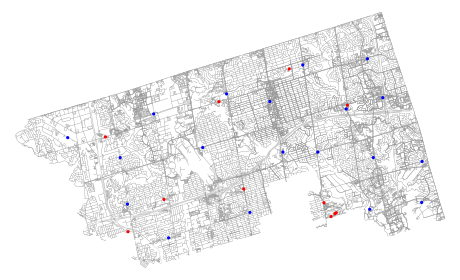

In [18]:
all_nodes = list(nodes.to_dict()['osmid'].keys())
nc, ns = node_color_and_size(amenities, all_nodes)

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=0.2, bgcolor = 'white')

Stategy going forward: 
1. Heat map of traafic data 
2. Implement the algorithm - currently we are utilizing the algorithm from prof

**Mapping Logic**

In [90]:
ll_map = {}
for i in range(len(amenities)):
    ll_map[amenities[i].osmid] = {'lat': amenities[i].lat, 'lon': amenities[i].lon}


tags1 = {
    'amenity':['hospital'],
}

emergency_locations1 = ox.geometries_from_place('North York, Ontario, Canada', tags=tags1)
df = pd.DataFrame(emergency_locations1)
df = df.head(3) # reduce the amenities for demo 2 
dic = df['osmid'].to_dict() 
nod_ = [dic[a] for a, b in dic.items()] # list of osmid of amenities 

dest = {}
cap = [2 for i in range(len(nod_))] # cap = capacity at each amenity (hospital + fire-station)
for i in range(len(nod_)):
    dest[nod_[i]] = cap[i] # dest = map amenity (hospital/fire-station) osmid to its capacity

# source = [56922195, 29658912, 6894245117, 29656792, 1287736695, 73461503, 267197091, 393521690, 1758011800, 432736587]
###### Comment these when using hard coded source
source = []

for emergency_incident in emergency_incidents: # holds the nearest node to each top 10 accident
    point = (float(emergency_incident.get_summary()['origin coordinate latitude']), float(emergency_incident.get_summary()['origin coordinate longitude']))
    source.append(osmnx.distance.get_nearest_node(north_york_map.graph, point, method='haversine', return_dist=False))
######
from collections import OrderedDict
source = list(OrderedDict.fromkeys(source))


res = {}    
for i in range(len(source)):
    temp_ = {}
    for a, b in dest.items(): # for each source (acccident), look at each destination (hospital/firestation)
        dist = osmnx.distance.euclidean_dist_vec(ll_map[a]['lat'], 
                                             ll_map[a]['lon'], 
                                             ny_nodes[source[i]]['lat'],
                                             ny_nodes[source[i]]['lon'])

        temp_[a] = dist # temp holds osmid_hospital/firestation -> distance

    # Pick the closest destination (hospital/firestation) and the one that has capacity > 0
    od = {a: b for a, b in sorted(temp_.items(), key=lambda item: item[1], reverse=False)}
    Touched = False
    for x, y in od.items():
        if x in dest and dest[x]!=0 and Touched==False:
            res[source[i]] = x # res = source (accident) osmid -> desitination (hospital/firestation) osmid
            dest[x] = dest[x] - 1
            Touched = True

            
count = 0
for a, b in dest.items(): # a = hostpial/firestation osmid , b = capacity
    if b==0: count += 1

secondary_dest_nodes = {}  

if count==len(dest): # all hospital/firestations have no spare capcity
#     secondary_dest_nodes = source 
    for i in source:
        if i in res:
            secondary_dest_nodes[i] = 1


if count==len(dest):
    print('All ER busy.. finding the closest responder')
    for i in range(len(source)):
        if source[i] not in res:
            temp__ = {}
            for a, b in secondary_dest_nodes.items():
                dist_ = osmnx.distance.euclidean_dist_vec(ny_nodes[a]['lat'],
                                                    ny_nodes[a]['lon'], 
                                                    ny_nodes[source[i]]['lat'],
                                                    ny_nodes[source[i]]['lon'])

                temp__[a] = dist_
            od_ = {a: b for a, b in sorted(temp__.items(), key=lambda item: item[1], reverse=False)}


            Touched = False
            for x, y in od_.items():
                if x in secondary_dest_nodes and secondary_dest_nodes[x]!= -1 and Touched==False:
                    res[source[i]] = x
                    secondary_dest_nodes[x] = -1
                    Touched = True



                
                
                
tags2 = {
    'amenity':['fire_station'],
}
emergency_locations2 = ox.geometries_from_place('North York, Ontario, Canada', tags=tags2)
df2 = pd.DataFrame(emergency_locations2)
df2 = df2.head(3) # reduce the amenities for demo 2 
dic2 = df2['osmid'].to_dict()

nod_2 = [dic2[a] for a, b in dic2.items()] # list of osmid of amenities 

dest2 = {}
cap2 = [2 for i in range(len(nod_2))] # cap = capacity at each amenity (hospital + fire-station)
for i in range(len(nod_2)):
    dest2[nod_2[i]] = cap2[i] # dest = map amenity (hospital/fire-station) osmid to its capacity


res2 = {}    
for i in range(len(source)):
    temp_2 = {}
    for a, b in dest2.items(): # for each source (acccident), look at each destination (hospital/firestation)
        dist2 = osmnx.distance.euclidean_dist_vec(ll_map[a]['lat'], 
                                             ll_map[a]['lon'], 
                                             ny_nodes[source[i]]['lat'],
                                             ny_nodes[source[i]]['lon'])
        temp_2[a] = dist2 # temp holds osmid_hospital/firestation -> distance

    # Pick the closest destination (hospital/firestation) and the one that has capacity > 0
    od2 = {a: b for a, b in sorted(temp_2.items(), key=lambda item: item[1], reverse=False)}
    Touched2 = False
    for x, y in od2.items():
        if x in dest2 and dest2[x]!=0 and Touched2==False:
            res2[source[i]] = x # res = source (accident) osmid -> desitination (hospital/firestation) osmid
            dest2[x] = dest2[x] - 1
            Touched2 = True




count2 = 0
for a, b in dest2.items(): # a = hostpial/firestation osmid , b = capacity
    if b==0:
        count2 += 1

# secondary_dest_nodes2 = {}

secondary_dest_nodes2 = {}  

if count2==len(dest2): # all hospital/firestations have no spare capcity
#     secondary_dest_nodes2 = source
    for i in source:
        if i in res2:
            secondary_dest_nodes2[i] = 1

if count2==len(dest2):
    print('All ER busy.. finding the closest responder')
    for i in range(len(source)):
        if source[i] not in res2:
            temp__2 = {}
            for a, b in secondary_dest_nodes2.items():
                dist_2 = osmnx.distance.euclidean_dist_vec(ny_nodes[a]['lat'],
                                                    ny_nodes[a]['lon'], 
                                                    ny_nodes[source[i]]['lat'],
                                                    ny_nodes[source[i]]['lon'])

                temp__2[a] = dist_2
            od_2 = {a: b for a, b in sorted(temp__2.items(), key=lambda item: item[1], reverse=False)}


            Touched2 = False
            for x, y in od_2.items():
                if x in secondary_dest_nodes2 and secondary_dest_nodes2[x]!= -1 and Touched2==False:
                    res2[source[i]] = x
                    secondary_dest_nodes2[x] = -1
                    Touched2 = True

print(f'Source: {source}')
print(f'Destination - FIRE: {dest2}')
print(f'Mapping Source to destination - FIRE: {res}')
print(f'Destination - AMBULANCE: {dest}')
print(f'Mapping Source to destination - AMBULANCE: {res2}')



All ER busy.. finding the closest responder
All ER busy.. finding the closest responder
Source: [73244094, 431402843, 29656792, 267197091, 450617895, 73461503, 56922195, 393521690]
Destination - FIRE: {609290577: 0, 1601962650: 0, 31372887: 0}
Mapping Source to destination - FIRE: {73244094: 673002279, 431402843: 673002279, 29656792: 27006473, 267197091: 671607430, 450617895: 27006473, 73461503: 671607430, 56922195: 450617895, 393521690: 29656792}
Destination - AMBULANCE: {27006473: 0, 671607430: 0, 673002279: 0}
Mapping Source to destination - AMBULANCE: {73244094: 1601962650, 431402843: 1601962650, 29656792: 609290577, 267197091: 609290577, 450617895: 31372887, 73461503: 31372887, 56922195: 450617895, 393521690: 29656792}


# The Algorithm

## -------- A* -----------

In [62]:
def A_star(G, origin, destination):
    toGoal, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)

    %time
    route = []
    frontier = list()

    bar = tqdm(total=len(G)) # for the progress bar

    frontier.append(origin)
    explored = set()
    found = False

    while frontier and not found:
        bar.update(1); time.sleep(0.05)

        # choose a node based on its heuristic value
        node = min(frontier, key = lambda node : toGoal[node.osmid] + toDestination[node.osmid])
        frontier.remove(node)
        explored.add(node)

        # expand its children
        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    found = True
                    continue
                frontier.append(child)

    bar.close()
    return route 

In [64]:
routes_ = []
nn_map = {}
for i in range(len(amenities)):
    nn_map[amenities[i].osmid] = amenities[i].nearestNode

for a, b in res.items():
    nn_map[a] = a 

for a, b in res2.items():
    nn_map[a] = a 

for a, b in res.items():
    routes_.append(A_star(G, Node(graph = G, osmid = a), Node(graph = G, osmid = nn_map[b])))
    
for a, b in res2.items():
    routes_.append(A_star(G, Node(graph = G, osmid = a), Node(graph = G, osmid = nn_map[b]))) 


  0%|          | 3/35988 [00:00<20:06, 29.83it/s]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


  0%|          | 3/35988 [00:00<20:07, 29.81it/s]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.7 µs


  0%|          | 3/35988 [00:00<20:07, 29.81it/s]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


  0%|          | 3/35988 [00:00<20:07, 29.81it/s]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.11 µs


  0%|          | 3/35988 [00:00<20:06, 29.83it/s]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs


  0%|          | 3/35988 [00:00<20:06, 29.84it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


  0%|          | 3/35988 [00:00<20:05, 29.85it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


  0%|          | 3/35988 [00:00<20:05, 29.84it/s]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


  0%|          | 3/35988 [00:00<20:20, 29.49it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 15.3 µs


  0%|          | 3/35988 [00:00<20:09, 29.76it/s]

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


  0%|          | 3/35988 [00:00<20:06, 29.83it/s]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


  0%|          | 3/35988 [00:00<20:07, 29.81it/s]

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.6 µs


  0%|          | 3/35988 [00:00<20:07, 29.81it/s]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


  0%|          | 3/35988 [00:00<20:05, 29.84it/s]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


  0%|          | 3/35988 [00:00<20:06, 29.81it/s]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


  0%|          | 3/35988 [00:00<20:06, 29.83it/s]

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.54 µs


  0%|          | 3/35988 [00:00<20:05, 29.86it/s]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


  0%|          | 3/35988 [00:00<20:05, 29.86it/s]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


  0%|          | 3/35988 [00:00<20:07, 29.79it/s]

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


  0%|          | 3/35988 [00:00<20:06, 29.82it/s]

CPU times: user 148 µs, sys: 7 µs, total: 155 µs
Wall time: 166 µs


  1%|          | 262/35988 [00:13<30:23, 19.59it/s]


In [91]:
for a, b in secondary_dest_nodes2.items():
    if b==-1:
        amenities.append(Amenity('secondary_node', 0, 0, 'NA', a, a))

for a, b in secondary_dest_nodes.items():
    if b==-1:
        amenities.append(Amenity('secondary_node', 0, 0, 'NA', a, a))
        
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1

def node_color_and_size(amenities, nodes):
    node_colors = ['w'] * len(nodes)
    node_size = [0] * len(nodes)
    for i in range(len(amenities)): 
        idx = find_element_in_list(amenities[i].nearestNode, nodes)
        if (idx != -1):
            if (amenities[i].amenity == 'fire_station'):
                node_colors[idx] = 'red'
                node_size[idx] = 100
            if (amenities[i].amenity == 'hospital'):
                node_colors[idx] = 'white'
                node_size[idx] = 100
        if (amenities[i].amenity == 'secondary_node'):
            print(amenities[i].amenity)
            node_colors[idx] = 'yellow'
            node_size[idx] = 200
    return node_colors, node_size

number_of_colors = len(routes_)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
color_map = {}
for i in range(len(source)):
    color_map[source[i]] = color[i]

mod_color_list = []
for i in range(len(routes_)):
    mod_color_list.append(color_map[routes_[i][0]])

all_nodes = list(nodes.to_dict()['osmid'].keys())
nc, ns = node_color_and_size(amenities, all_nodes)


fig, ax = ox.plot_graph_routes(G, routes_, route_colors=mod_color_list, route_linewidth=2, route_alpha=1, orig_dest_size = 50, node_color=nc, node_size=ns, edge_linewidth=0.1, bgcolor = 'black', figsize = (10, 10))
    

KeyError: 29658912

## -------- PARTICLE SWARM OPTIMIZATION -----------

In [ ]:
dd = {} 

for ny_edge in ny_edges:     
    dd[(ny_edge.start_osmid, ny_edge.end_osmid)] = ny_edge.risk_score

def pso(G, source, dest):
    origin = Node(graph = G, osmid = a)
    destination = Node(graph = G, osmid = nn_map[b])

    particles_swarm = 200
    num_of_swarms = 4
    num_of_iterations = 50

    particles = [randomized_search(G, a, nn_map[b]) for _ in range(particles_swarm)]

    from itertools import product
    from random import choice

    for iteration in range(num_of_iterations):
        # we need to have `num_of_swarms` particles to lead
        # a swarm and be its lbest ... that changes every iteration
        particles.sort(key = lambda particle : cost_pso(G, particle, dd))
        swarm_particles = particles_swarm // num_of_swarms

        leaders = particles[:swarm_particles][:]

        for i in range(num_of_swarms): 
            particles[i] , particles[i * (swarm_particles) - 1] = particles[i * (swarm_particles) - 1], particles[i]

        swarms = list()

        for i in range(num_of_swarms):
            swarms.append(particles[i * (swarm_particles): i*(swarm_particles) + swarm_particles])

        # for each swarm follow the leader of the swarm
        def follow_leader_local(population):
            for i in range(1, len(population)):
                population[i] = cross_over(population[0], population[i]) # this is what we are doing

        for swarm in swarms:
            follow_leader_local(swarm)

        def follow_leader_global():
            for u, v in product(range(0, len(leaders)), range(0, len(leaders))):
                tobeMutated = choice([u, v])
                leaders[tobeMutated] = cross_over(leaders[u], leaders[v])

        follow_leader_global()

        # adding the new leaders

        for i in range(num_of_swarms):
            particles[i*(swarm_particles - 1)] = leaders[i]

    route = min(particles, key = lambda particle : cost_pso(G, particle, dd))
    return route
    
route_p = []

for a, b in res.items():
    route_p.append(pso(G, a, b))
for a, b in res2.items():
    route_p.append(pso(G, a, b))

    

In [ ]:
# def node_color_and_size(amenities, nodes):
#     node_colors = ['w'] * len(nodes)
#     node_size = [0] * len(nodes)
#     for i in range(len(amenities)): 
#         idx = find_element_in_list(amenities[i].nearestNode, nodes)
#         if (idx != -1):
#             if (amenities[i].amenity == 'fire_station'):
#                 node_colors[idx] = 'red'
#             if (amenities[i].amenity == 'hospital'):
#                 node_colors[idx] = 'white'
#             node_size[idx] = 100
#     return node_colors, node_size

# for a, b in secondary_dest_nodes2.items():
#     if b==-1:
#         amenities.append(Amenity('secondary_node', 0, 0, 'NA', a, 0))
# for a, b in secondary_dest_nodes.items():
#     if b==-1:
#         amenities.append(Amenity('secondary_node', 0, 0, 'NA', a, 0))

# def node_color_and_size(amenities, nodes):
#     node_colors = ['w'] * len(nodes)
#     node_size = [0] * len(nodes)
#     for i in range(len(amenities)): 
#         idx = find_element_in_list(amenities[i].nearestNode, nodes)
#         if (idx != -1) or amenities[i].amenity == 'secondary_node':
#             if (amenities[i].amenity == 'fire_station'):
#                 node_colors[idx] = 'red'
#             if (amenities[i].amenity == 'hospital'):
#                 node_colors[idx] = 'white'
#             if (amenities[i].amenity == 'secondary_node'):
#                 node_colors[idx] = 'yellow'
#             node_size[idx] = 100
#     return node_colors, node_size

# number_of_colors = len(route_p)
# color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for i in range(number_of_colors)]

# color_map = {}
# for i in range(len(source)):
#     color_map[source[i]] = color[i]
# mod_color_list = []
# for i in range(len(route_p)):
#     mod_color_list.append(color_map[route_p[i][0]])

# all_nodes = list(nodes.to_dict()['osmid'].keys())
# nc, ns = node_color_and_size(amenities, all_nodes)



fig, ax = ox.plot_graph_routes(G, route_p, route_colors=mod_color_list, route_linewidth=2, route_alpha=1, orig_dest_size = 50, node_color=nc, node_size=ns, edge_linewidth=0.1, bgcolor = 'black', figsize = (10, 10))

--------------------------------------------------------------------------